In [626]:
#import modules
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors
import seaborn as sns
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn.decomposition import KernelPCA
import umap
import copy

In [627]:
#load the data and subset only the required columns
basepath = "C:/Users/ashuk/Desktop/MLProject/ashrae-energy-prediction/"
train = pd.read_csv(basepath + "train.csv")
building = pd.read_csv(basepath + "building_metadata.csv")
train = pd.merge(train, building, left_on="building_id", right_on="building_id", how="left")
train = train[['building_id','timestamp', 'meter', 'meter_reading', 'primary_use']]
del building

## Section for some custom functions that are to be used frequently.

In [628]:
color_values = ["red", "green","brown","purple","cyan"]
def plot_tsne(X,pivot=None, alpha=0.6, xlabel="x-axis", ylabel="y-axis", title="Dimension reduced by t-SNE"):
    plt.figure(figsize=(20,10))
    tsne = TSNE()
    results_tsne = tsne.fit_transform(X)
    cluster_values = sorted(pivot.index.get_level_values("cluster").unique())
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_values)
    plt.scatter(results_tsne[:,0], results_tsne[:,1],
        c=pivot.index.get_level_values('cluster'),
        cmap=cmap, 
        alpha=0.6, 
    )
    plt.title(title)
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    return
def plot_isomap(X,pivot=None, alpha=0.6, neighbor = 8, dimension=2, xlabel="x-axis", ylabel="y-axis", title="Dimension reduced by ISOMAP"):
    plt.figure(figsize=(20,10))
    isomap = Isomap(n_components=dimension, n_neighbors=neighbor)
    results_isomap = isomap.fit_transform(X)
    cluster_values = sorted(pivot.index.get_level_values("cluster").unique())
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_values)
    plt.scatter(results_isomap[:,0], results_isomap[:,1],
        c=pivot.index.get_level_values('cluster'),
        cmap=cmap, 
        alpha=0.6, 
        )
    plt.title(title)
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    return
def plot_umap(X,pivot=None, neighbor = 8, dimension=2, alpha=0.6, xlabel="x-axis", ylabel="y-axis", title="Dimension reduced by UMAP"):
    plt.figure(figsize=(20,10))
    reducer = umap.UMAP(n_neighbors=neighbor, n_components=dimension)
    umap_result = reducer.fit_transform(X)
    cluster_values = sorted(pivot.index.get_level_values("cluster").unique())
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_values)
    plt.scatter(umap_result[:,0], umap_result[:,1],
        c=pivot.index.get_level_values('cluster'),
        cmap=cmap, 
        alpha=0.6, 
        )
    plt.title(title)
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    return

def plot_kernel_pca(X, pivot=None, kernel="rbf", esolver="auto", rzev = True, g = 15, deg = None, title="Representation obtained usinf Kernel PCA"):
    plt.figure(figsize=(20,10))
    if deg is not None:
        kpca = KernelPCA(n_components=2, n_jobs=-1, eigen_solver=esolver, remove_zero_eig=rzev, gamma=g, kernel=kernel, degree=deg)
    else:
        kpca = KernelPCA(n_components=2, n_jobs=-1, eigen_solver=esolver, remove_zero_eig=rzev, gamma=g, kernel=kernel)
    
    kpca_result = kpca.fit_transform(X)
    cluster_values = sorted(pivot.index.get_level_values("cluster").unique())
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_values)
    plt.scatter(kpca_result[:,0], kpca_result[:,1],
        c=pivot.index.get_level_values('cluster'),
        cmap=cmap, 
        alpha=0.6, 
        )
    plt.title(title)
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    return

In [629]:
def perform_clustering_quarter_wise(quarter_no=1, train = None, drop_columns=None):
    
    quarter1 = copy.deepcopy(train)
    if quarter_no>0:
        quarter1["quarter"] = quarter1["timestamp"].dt.quarter
        quarter1 = quarter1[quarter1["quarter"]==quarter_no]
    quarter1["meter_reading"].fillna(0, inplace=True)
    
    if quarter_no>0:
        perHourElectricityConsumptionEachBuildingQ1 = quarter1.pivot_table(values="meter_reading", index="building_id", columns="hour", aggfunc={"meter_reading":np.mean})
        perHourElectricityConsumptionEachBuildingQ1.fillna(0, inplace=True)
    else:
        perHourElectricityConsumptionEachBuildingQ1 = quarter1.pivot(values="meter_reading", index="building_id", columns="timestamp")
        perHourElectricityConsumptionEachBuildingQ1.fillna(0, inplace=True)
    #perHourElectricityConsumptionEachBuildingQ1.drop(perHourElectricityConsumptionEachBuildingQ1.index[[1100,779,1198,1089,1022,1169,1160,1149,1285]], inplace=True)
    perHourElectricityConsumptionEachBuildingQ1.head(5)
    if drop_columns is not None:
        perHourElectricityConsumptionEachBuildingQ1.drop(perHourElectricityConsumptionEachBuildingQ1.index[drop_columns], inplace=True)
    
    XQ1 = MinMaxScaler().fit_transform(perHourElectricityConsumptionEachBuildingQ1.values.copy())
    XQ1
    
    silhouette_scores_q1 = list()
    inertia = list()
    no_cluster = np.arange(2,28).astype("int")
    for cluster in no_cluster:
        kmeansQ1 = KMeans(n_clusters=cluster, init="k-means++")
        c_f = kmeansQ1.fit_predict(XQ1)
        silhouette_scores_q1.append(silhouette_score(XQ1, kmeansQ1.labels_))
        inertia.append(kmeansQ1.inertia_)
    
    
    plt.figure(figsize=(20,10))
    plt.plot([i for i in range(0,26,1)], silhouette_scores_q1)
    plt.xticks([i for i in range(0,26,1)])
    plt.yticks(np.arange(0,1,0.1))
    plt.ylabel("silhouette score")
    plt.xlabel("cluster number")
    plt.grid()
    
    plt.figure(figsize=(20,10))
    plt.plot([i for i in range(1,27,1)], inertia)
    plt.xticks([i for i in range(1,27,1)])
    plt.ylabel("within cluster SSE")
    plt.xlabel("cluster number")
    plt.grid()
    kmeans = KMeans(n_clusters=3)
    cluster_found_q1 = kmeans.fit_predict(XQ1)
    cluster_found_sr_q1 = pd.Series(cluster_found_q1, name="cluster")
    perHourElectricityConsumptionEachBuildingQ1.set_index(cluster_found_sr_q1, append=True, inplace=True)

    plot_isomap(XQ1, perHourElectricityConsumptionEachBuildingQ1, dimension=2, neighbor=10, title="KMeans with euclidean distance")
    
    perHourElectricityConsumptionEachBuildingQ1.index = perHourElectricityConsumptionEachBuildingQ1.index.droplevel(-1)
    kmeansTslearn = TimeSeriesKMeans(n_clusters=3, max_iter=1000, metric="dtw", n_jobs=4, init="k-means++")
    cluster_found_q1 = kmeansTslearn.fit_predict(XQ1)
    cluster_found_sr_q1 = pd.Series(cluster_found_q1, name="cluster")
    perHourElectricityConsumptionEachBuildingQ1.set_index(cluster_found_sr_q1, append=True, inplace=True)
    
    plot_isomap(XQ1, perHourElectricityConsumptionEachBuildingQ1, dimension=2, neighbor = 10, title="KMeans with DTW distance")
    
    # printing the score of internal validation measures
    print("Internal Validation scores for quarter {}".format(quarter_no))
    print("silhouette score on euclidean metric: ",silhouette_score(XQ1, kmeans.labels_))
    print("silhouette score on dtw metric: ",silhouette_score(XQ1, kmeansTslearn.labels_))
    print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(XQ1, kmeans.labels_))
    print("calsinki-H score on dtw metric: ",calinski_harabasz_score(XQ1, kmeansTslearn.labels_))
    print("davis-B score on euclidean metric: ",davies_bouldin_score(XQ1, kmeans.labels_))
    print("davis-B score on dtw metric: ",davies_bouldin_score(XQ1, kmeansTslearn.labels_))
    return

### Extract only the meter readings for electricity (meter_type = 1)

In [630]:
train = train.loc[train["meter"]==1]

In [631]:
train = train[~train["building_id"].isin([1100,779,1198,1089,1022,1169,1160,1149,1285])]

In [632]:
#convert timestamp in strin to type timestamp and set it as index of the dataframe.
train["timestamp"] = pd.to_datetime(train["timestamp"])
train.set_index(["timestamp"], inplace=True)

In [633]:
#check the shape of the extracted dataframe
print(train.shape)

(4147314, 4)


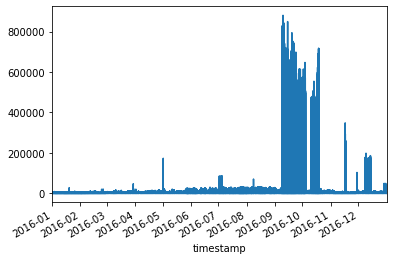

In [634]:
# simple plot  of meter readings over the whole year
train.loc[:, "meter_reading"].plot()

In [635]:
# summarizing electricity consumption over the whole year according to timestamp
summaryTimestampData = train.groupby([ "primary_use","timestamp"])["meter_reading"].agg("mean").reset_index()
summaryTimestampData.set_index(["primary_use"], inplace=True)
summaryTimestampData.set_index(["timestamp"], append=True, inplace=True)
summaryTimestampData

meter_reading
primary_use timestamp                         
Education   2016-01-01 00:00:00     145.650674
            2016-01-01 01:00:00     166.890381
            2016-01-01 02:00:00     160.938443
            2016-01-01 03:00:00     156.920528
            2016-01-01 04:00:00     153.807789
...                                        ...
Utility     2016-12-31 19:00:00     351.228000
            2016-12-31 20:00:00     269.707000
            2016-12-31 21:00:00     215.513000
            2016-12-31 22:00:00     188.960000
            2016-12-31 23:00:00     258.242000

[119406 rows x 1 columns]

Text(0, 0.5, 'mean meter reading')

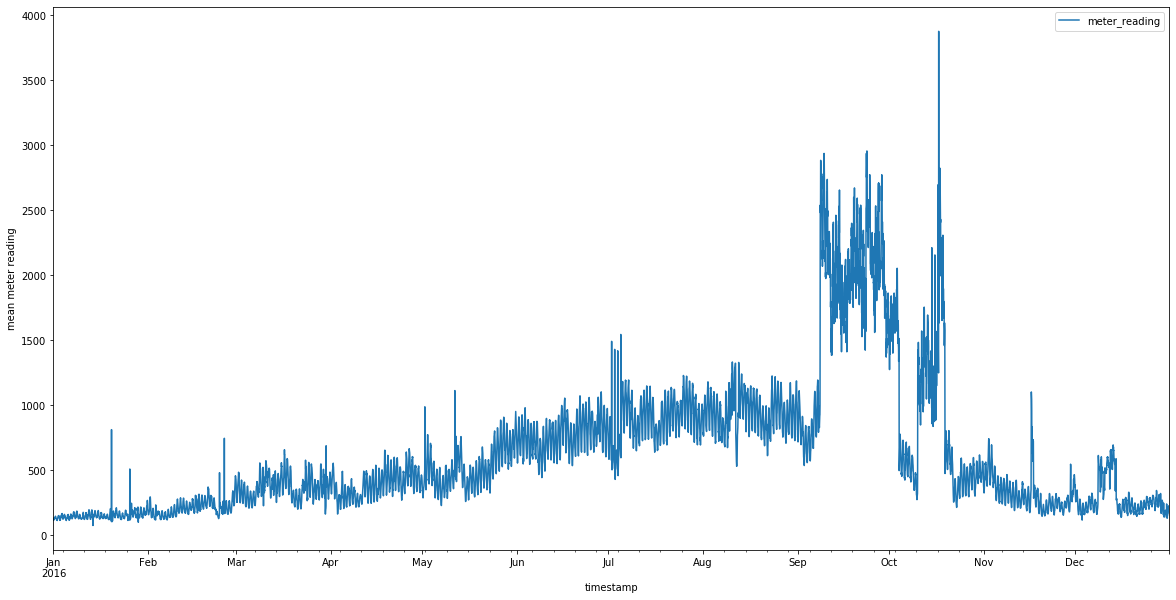

In [636]:
#plot the mean consumption of energy per month for the whole year to find patterns in data.
summaryTimestampOnly = train.groupby(["timestamp"]).agg("mean").reset_index()
summaryTimestampOnly.plot(x = "timestamp", y="meter_reading", figsize=(20,10))
plt.ylabel("mean meter reading")

### Generate the descriptive stats for each building

In [637]:
descriptiveStats = copy.deepcopy(train)
descriptiveStats.set_index(["building_id"], inplace=True)
descriptiveStats = descriptiveStats.groupby(descriptiveStats.index)["meter_reading"].agg(["min","max","mean","var"]).reset_index()
descriptiveStats.head(5)

building_id  min      max         mean           var
0            7  0.0  8442.07  3097.043665  3.742930e+06
1            9  0.0  2954.72   664.825978  3.341630e+05
2           13  0.0  7893.34  2007.955523  2.238661e+06
3           14  0.0  9581.75  2521.551463  2.655000e+06
4           15  0.0  5571.77  2032.579977  1.198813e+06

In [638]:
#Adding a column for hour in the main dataframe to facilitate further analysis.
train["hour"] = train.index.hour
train.reset_index(inplace=True)
train.head(2)

timestamp  building_id  meter  meter_reading primary_use  hour
0 2016-01-01          161      1            0.0   Education     0
1 2016-01-01          162      1            0.0   Education     0

## Clustering over aggregate (mean) meter reading of each building for whole year for hour from 1 to 24

### Generate the pivot table using mean as the statistic

In [639]:
perHourElectricityConsumptionEachBuilding = train.pivot_table(values="meter_reading", index="building_id", columns="hour", aggfunc={"meter_reading":np.mean})
perHourElectricityConsumptionEachBuilding.reset_index(inplace=True)
perHourElectricityConsumptionEachBuilding.head(5)

hour  building_id            0            1            2            3  \
0               7  1178.814573  1282.717701  1379.058286  1426.737821   
1               9   260.670001   252.841538   333.896691   337.682957   
2              13   266.746058   215.316993   238.113512   245.173105   
3              14   786.901762   761.188824   756.561103   745.342419   
4              15  1293.565783  1282.017065  1254.390826  1202.083681   

hour            4            5            6            7            8  ...  \
0     1441.742488  1464.600767  2830.898508  3780.842027  3751.252492  ...   
1      325.342377   322.537630   731.786796   801.574629   832.669442  ...   
2      453.430375   659.481620  2186.408366  2925.457171  2427.022160  ...   
3      746.043571   745.202176  1803.546495  1883.199203  2821.222505  ...   
4     1112.334116  1047.686166  2064.380911  2003.098867  2021.750009  ...   

hour           14           15           16           17           18  \
0     4315.836098  4298.536754  4285.251016  4122.775541  3933.866918   
1      953.538305   965.855330   963.502683   919.078179   846.421271   
2     3089.451158  2998.959182  2873.484387  2748.749842  2667.955852   
3     4062.989138  3980.921043  3776.235443  3574.871134  3304.863361   
4     2637.385988  2653.439636  2642.091220  2646.935364  2525.009446   

hour           19           20           21           22           23  
0     3724.900592  3524.077261  3311.214290  2465.056700  1027.954139  
1      774.087757   745.159206   285.163757   269.700610   263.849654  
2     2562.786424  2442.358478  2301.121990  1458.813485   194.547419  
3     3084.918773  2876.712409  2151.056370  2012.027350  1292.221350  
4     2498.798852  2563.687008  2551.845861  1396.424586  1335.686173  

[5 rows x 25 columns]

### Generate the wcss vs cluster count and silhouette score vs cluster count plot

In [640]:
#setup for generating plot according to silhouette score for each number of clusters to extrcat the optimal number of clusters.
silhouette_scores = list()
inertia_list = list()
no_cluster = np.arange(2,30).astype(int) 

In [641]:
#scale the data for faster processing.
X = MinMaxScaler().fit_transform(perHourElectricityConsumptionEachBuilding.values.copy())

In [642]:
#perform clustering with the required counts of clusters
for cluster in no_cluster:
    kmeans = KMeans(n_clusters=cluster, init="k-means++", n_init=10, n_jobs=-1,)
    c_f = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    inertia_list.append(kmeans.inertia_)

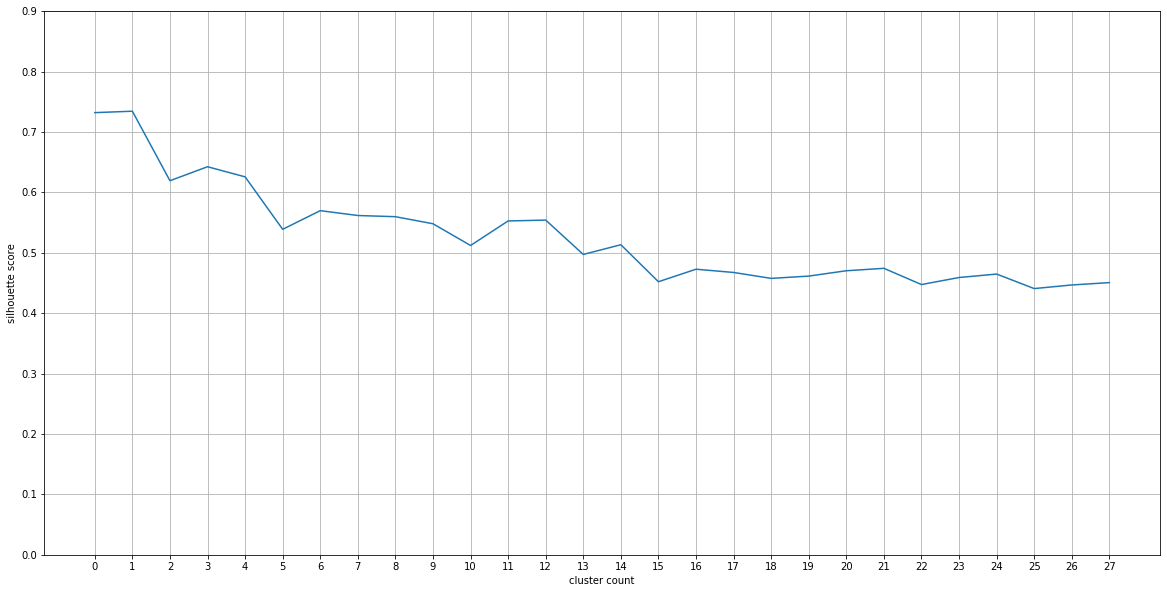

In [643]:
#plot the sihouette score vs cluster count graph.
plt.figure(figsize=(20,10))
plt.plot([i for i in range(0,28,1)], silhouette_scores)
plt.xticks([i for i in range(0,28,1)])
plt.yticks(np.arange(0,1,0.1))
plt.xlabel("cluster count")
plt.ylabel("silhouette score")
plt.grid()

### As silhouette score vs cluster count plot is not giving the desired result, we use elbow method to determine the best number of clusters

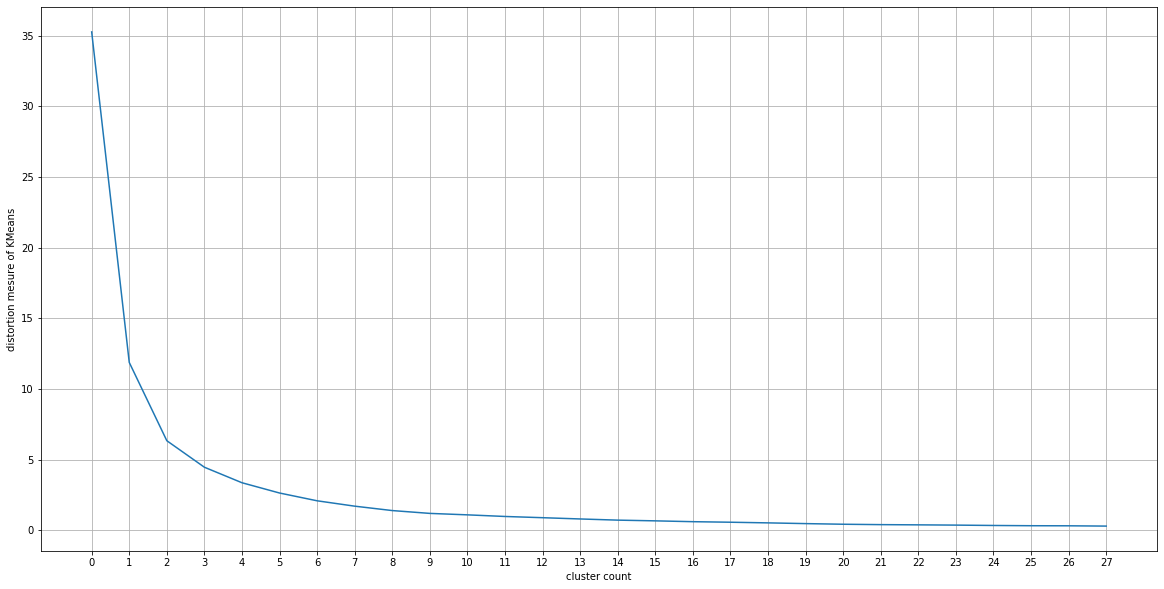

In [644]:
# plot the wcss vs cluster count graph
plt.figure(figsize=(20,10))
plt.plot([i for i in range(0,28,1)], inertia_list)
plt.xticks([i for i in range(0,28,1)])
plt.xlabel("cluster count")
plt.ylabel("distortion mesure of KMeans")
plt.grid()

### check the output of internal validation measure for cluster count = 2

In [645]:
kmeans = KMeans(n_clusters=2)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = pd.Series(cluster_found, name="cluster")
perHourElectricityConsumptionEachBuilding.set_index("building_id", inplace=True)
perHourElectricityConsumptionEachBuilding.set_index(cluster_found_sr, append=True, inplace=True)
print("silhouette sample on euclidean metric: ",silhouette_samples(X, cluster_found))
print("silhouette score on euclidean metric: ",silhouette_score(X, cluster_found))
print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(X, cluster_found))
print("davis-B score on euclidean metric: ",davies_bouldin_score(X, cluster_found))

silhouette sample on euclidean metric:  [0.61907173 0.74515586 0.68527866 0.65481368 0.69973975 0.73477759
 0.53493953 0.62288747 0.6277493  0.75951595 0.6596053  0.76725432
 0.69171861 0.72283607 0.2718184  0.73832143 0.78046294 0.66384457
 0.78269674 0.65006186 0.57185722 0.67048362 0.6320059  0.78637489
 0.80815733 0.81326188 0.81768904 0.78906464 0.81752615 0.79994596
 0.75458209 0.81655162 0.81739742 0.82131713 0.82087837 0.82181374
 0.82263629 0.81704073 0.82179062 0.81516242 0.81964537 0.81449354
 0.8231501  0.82321816 0.81875529 0.81622068 0.81594688 0.81474804
 0.82501874 0.8224893  0.817121   0.8231666  0.8152852  0.82426724
 0.82504122 0.82423119 0.80775619 0.82126167 0.80330177 0.82086347
 0.82155081 0.82490685 0.82146874 0.81733104 0.70662314 0.8238679
 0.73438838 0.82157544 0.81166073 0.81678548 0.82171275 0.8140377
 0.81468867 0.8120668  0.76883658 0.8118321  0.82051304 0.81963927
 0.81625591 0.81380266 0.81795732 0.81679082 0.80875762 0.80590486
 0.80743999 0.8129289  0

### visualizing the clusters obtained by reducing the data to 2 dimensions using ISOMAP, t-SNE, UMAP

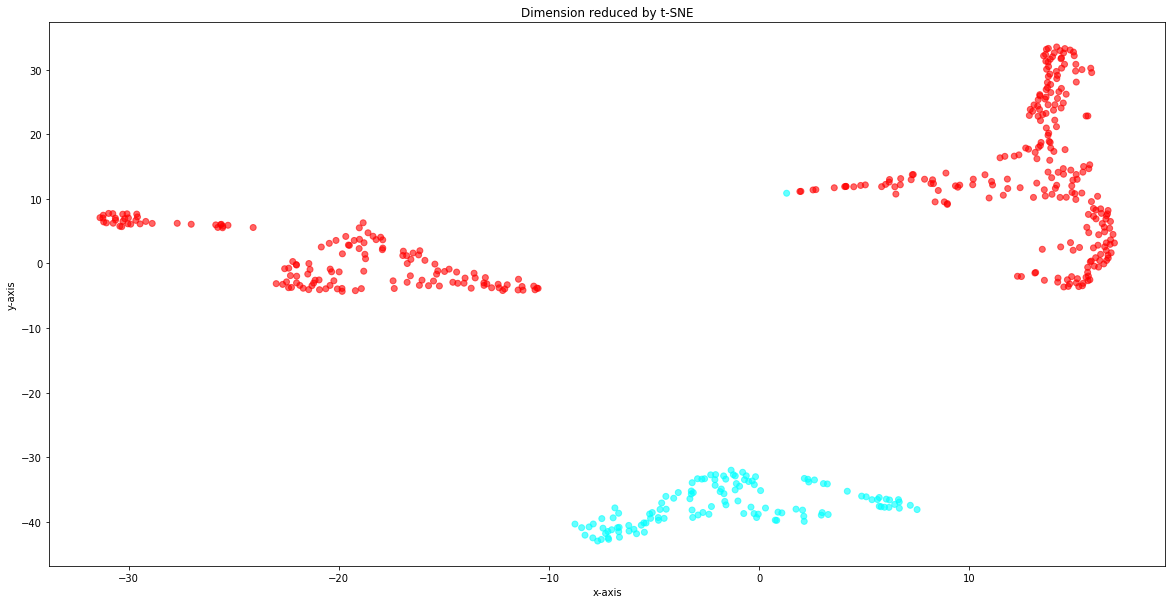

In [646]:
plot_tsne(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7)

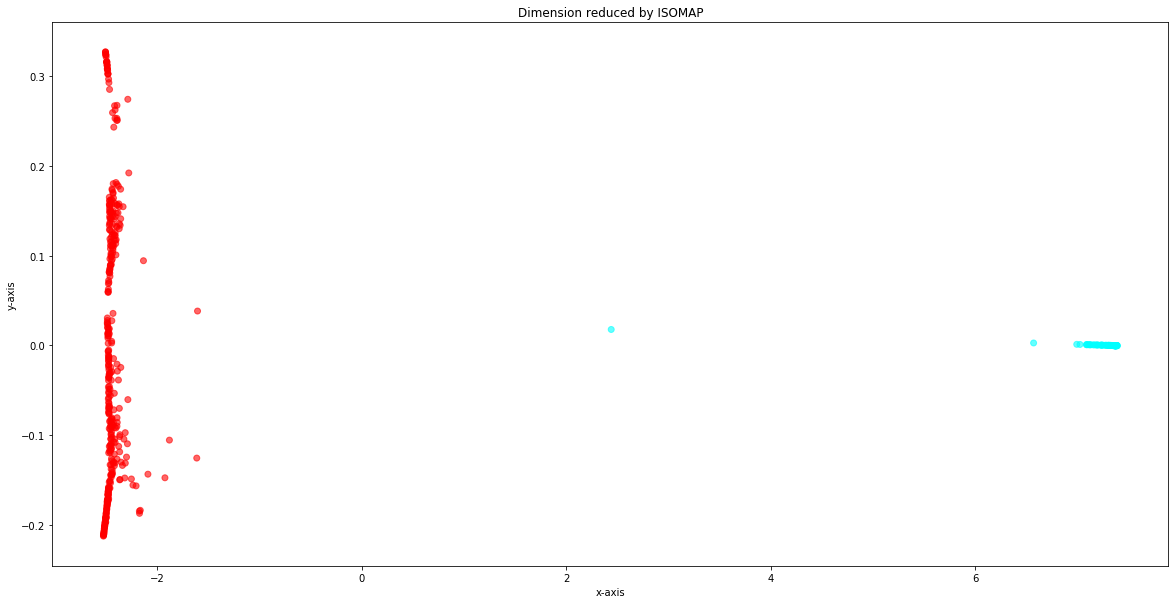

In [647]:
plot_isomap(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7, neighbor=20, dimension=2)

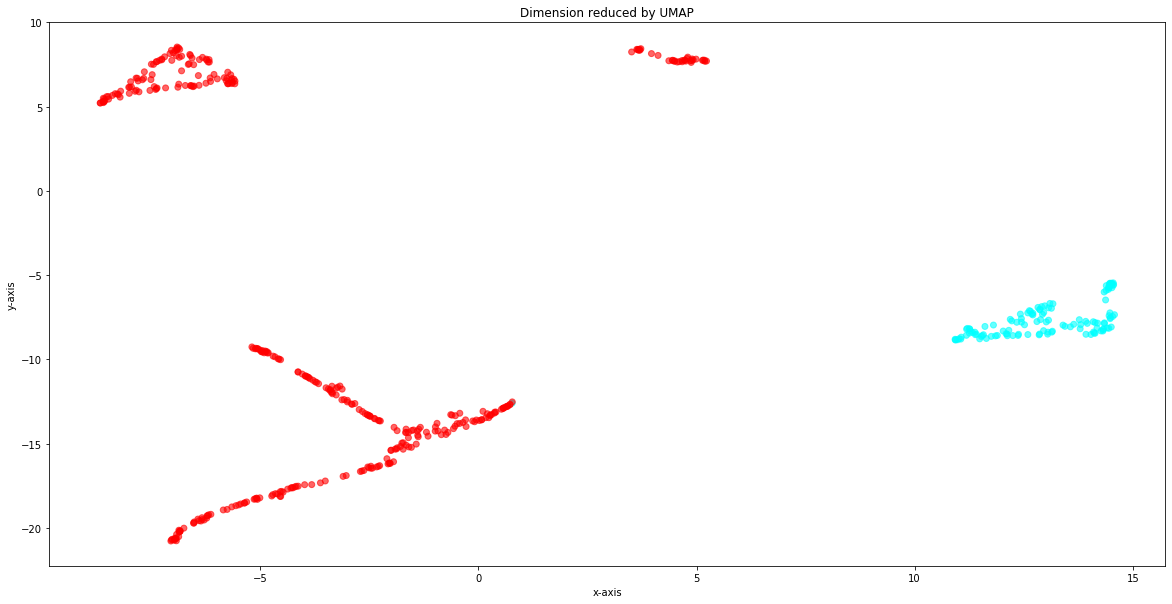

In [648]:
plot_umap(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7, neighbor=20, dimension=2)

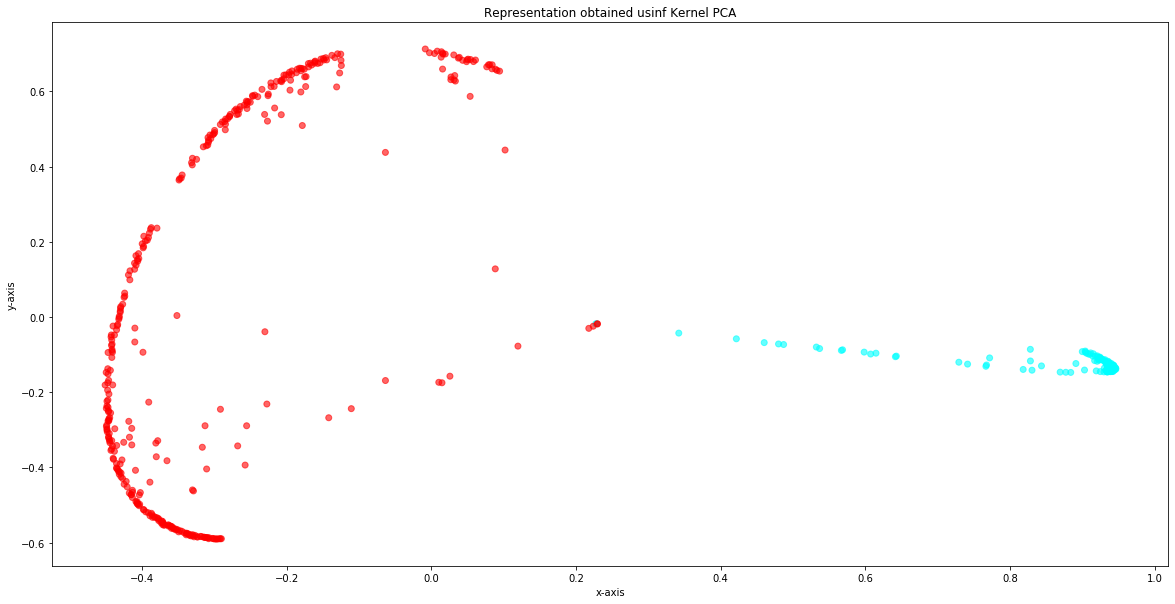

In [649]:
plot_kernel_pca(X, pivot=perHourElectricityConsumptionEachBuilding, kernel="rbf", g=15,rzev=True, deg = 1)

### As we see isomap gives the best representation of 2D for our data. In the subsequent sections we still will plot the points obtained via all 3 dimensionality reduction techniques but ISOMAP will be our emphasis.

### check the output of internal validation measure for cluster count = 3

In [650]:
perHourElectricityConsumptionEachBuilding.index = perHourElectricityConsumptionEachBuilding.index.droplevel(-1)
kmeans = KMeans(n_clusters=3)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = pd.Series(cluster_found, name="cluster")
perHourElectricityConsumptionEachBuilding.set_index(cluster_found_sr, append=True, inplace=True)
print("silhouette sample on euclidean metric: ",silhouette_samples(X, cluster_found))
print("silhouette score on euclidean metric: ",silhouette_score(X, cluster_found))
print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(X, cluster_found))
print("davis-B score on euclidean metric: ",davies_bouldin_score(X, cluster_found))

silhouette sample on euclidean metric:  [0.66147004 0.79321724 0.73073458 0.69901737 0.74560737 0.78264293
 0.57446613 0.66648839 0.67119761 0.80968025 0.70514931 0.81752771
 0.7389835  0.77206815 0.29753327 0.78822086 0.83265494 0.71148404
 0.83550813 0.69703108 0.61557709 0.71836041 0.67837301 0.83939689
 0.86507537 0.87023136 0.87467216 0.84489386 0.87477963 0.85626611
 0.8094085  0.87402058 0.8749223  0.87884127 0.87848558 0.87946396
 0.88030733 0.87489194 0.87946307 0.87314237 0.87767438 0.87259958
 0.881263   0.88142814 0.87710752 0.87477092 0.87455808 0.8734233
 0.88366264 0.88126827 0.87546824 0.88209585 0.87433916 0.88338436
 0.88420579 0.88339658 0.86635748 0.88040848 0.86189623 0.88047418
 0.88121945 0.88452014 0.88127162 0.87721411 0.76233277 0.88370148
 0.79133177 0.8817447  0.87192733 0.87711294 0.88197014 0.87403238
 0.8747848  0.87215944 0.8276201  0.87261666 0.88134385 0.88046292
 0.87728714 0.87496742 0.87898127 0.87798875 0.87025757 0.86687081
 0.86906943 0.87459895 

### visualizing the clusters obtained by reducing the data to 2 dimensions using ISOMAP, t-SNE, UMAP

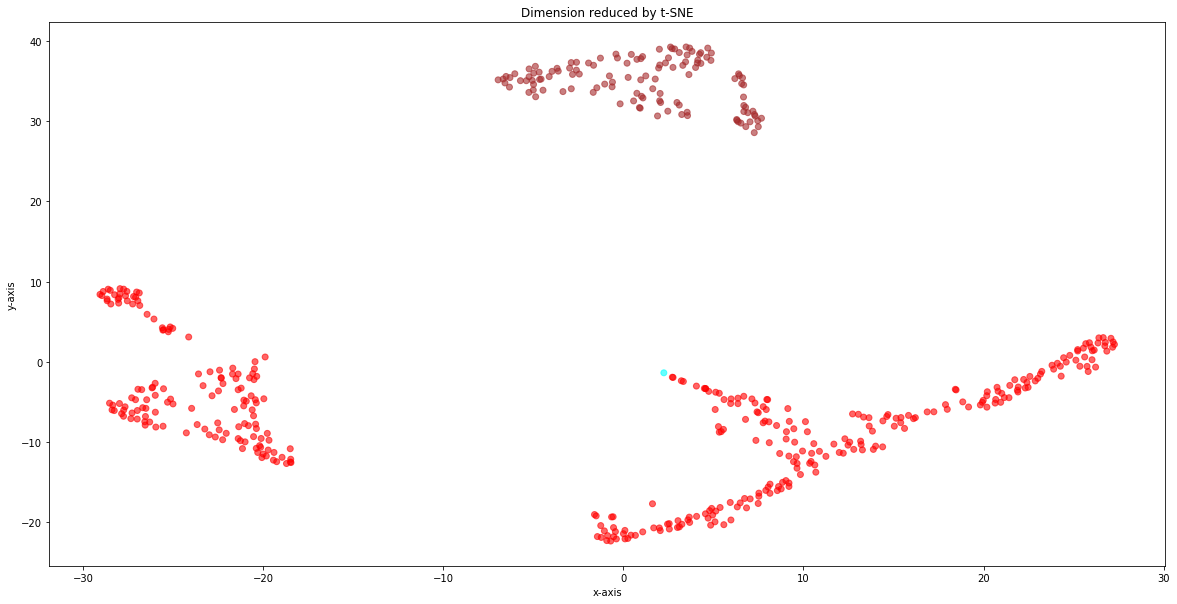

In [651]:
plot_tsne(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7)

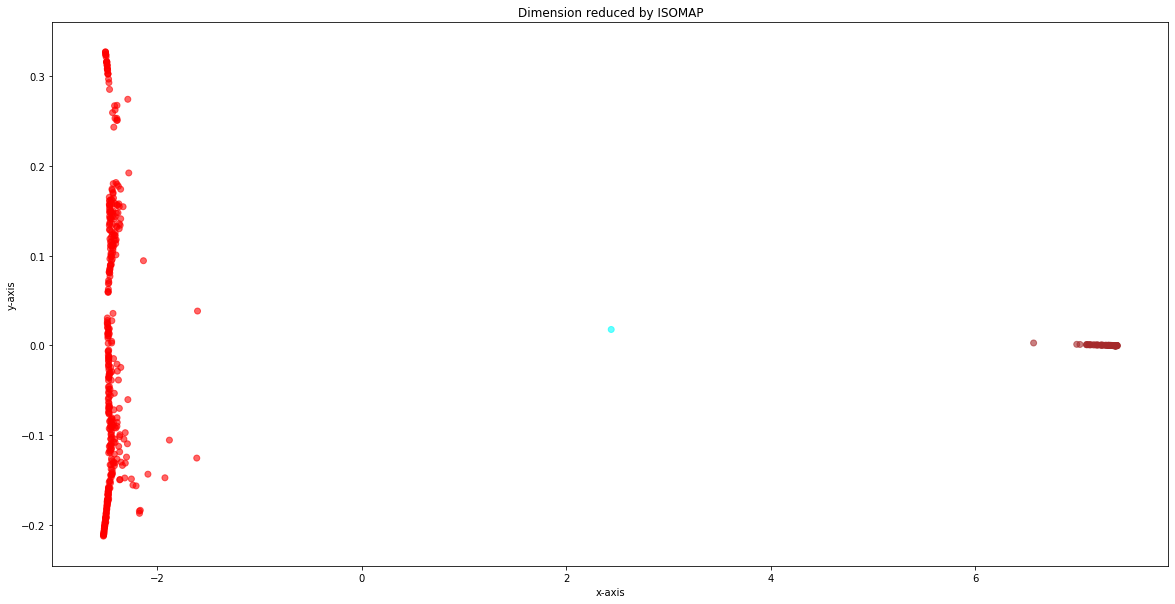

In [652]:
plot_isomap(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7, neighbor=20, dimension=2)

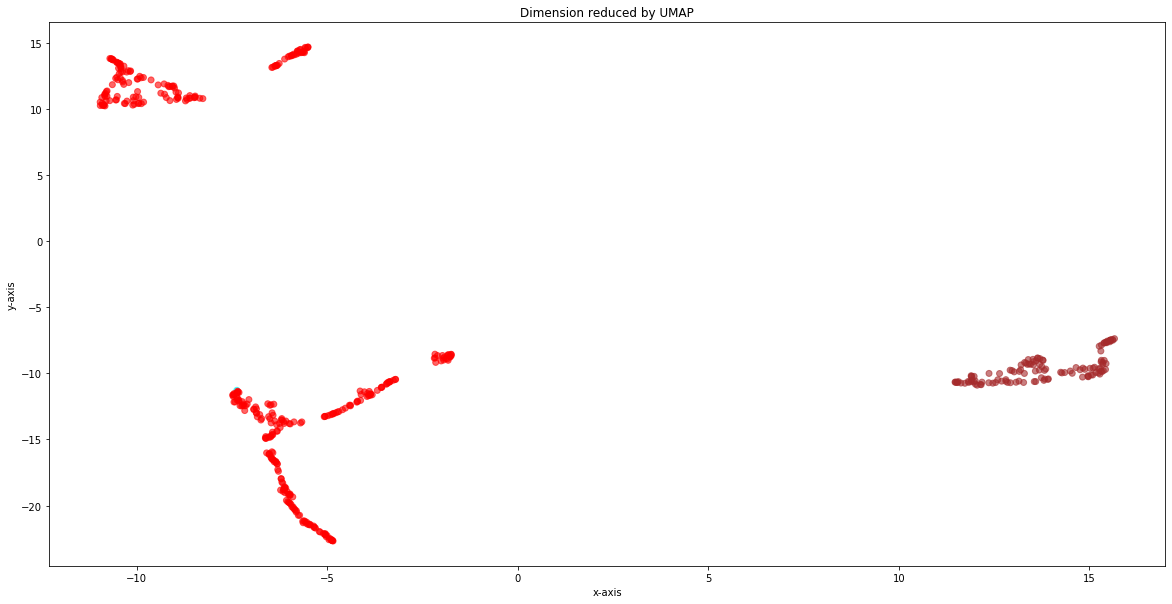

In [653]:
plot_umap(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7, neighbor=20, dimension=2)

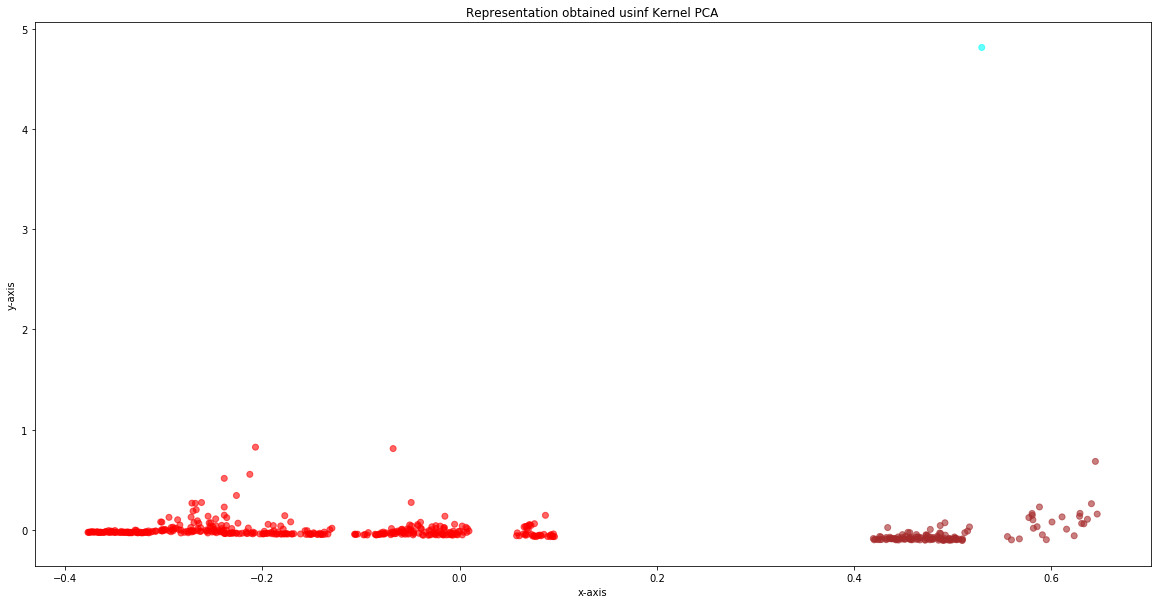

In [654]:
plot_kernel_pca(X, pivot=perHourElectricityConsumptionEachBuilding, kernel="linear", g=30,rzev=True, deg = 1)

### check the output of internal validation measure for cluster count = 4

In [655]:
perHourElectricityConsumptionEachBuilding.index = perHourElectricityConsumptionEachBuilding.index.droplevel(-1)
kmeans = KMeans(n_clusters=4)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = pd.Series(cluster_found, name="cluster")
perHourElectricityConsumptionEachBuilding.set_index(cluster_found_sr, append=True, inplace=True)
print("silhouette sample on euclidean metric: ",silhouette_samples(X, cluster_found))
print("silhouette score on euclidean metric: ",silhouette_score(X, cluster_found))
print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(X, cluster_found))
print("davis-B score on euclidean metric: ",davies_bouldin_score(X, cluster_found))

silhouette sample on euclidean metric:  [ 0.59759939  0.74838212  0.67558625  0.63938448  0.69283989  0.73541833
  0.50165531  0.60182251  0.60744046  0.76669777  0.64467628  0.77590138
  0.683186    0.7210717   0.23105197  0.74007898  0.793112    0.64958306
  0.79618711  0.63300466  0.54182345  0.65737719  0.61160573  0.80057052
  0.82995837  0.83637648  0.84190768  0.80472999  0.84188287  0.81874482
  0.76092474  0.84080529  0.84189366  0.84678531  0.84629818  0.84748778
  0.848507    0.84164983  0.84735678  0.8393623   0.84503074  0.83859282
  0.84946923  0.84958799  0.84410229  0.84102114  0.84070981  0.83923113
  0.85212515  0.84905564  0.8416846   0.84996306  0.84011428  0.85147192
  0.85247008  0.85135637  0.82977029  0.84747569  0.82404292  0.84747519
  0.84837605  0.85251611  0.84834969  0.8431483   0.70064933  0.85129367
  0.735663    0.84867062  0.83612935  0.84267853  0.84879561  0.83863095
  0.83950711  0.83611317  0.77988133  0.8365919   0.84761802  0.84644141
  0.8423403

### visualizing the clusters obtained by reducing the data to 2 dimensions using ISOMAP, t-SNE, UMAP

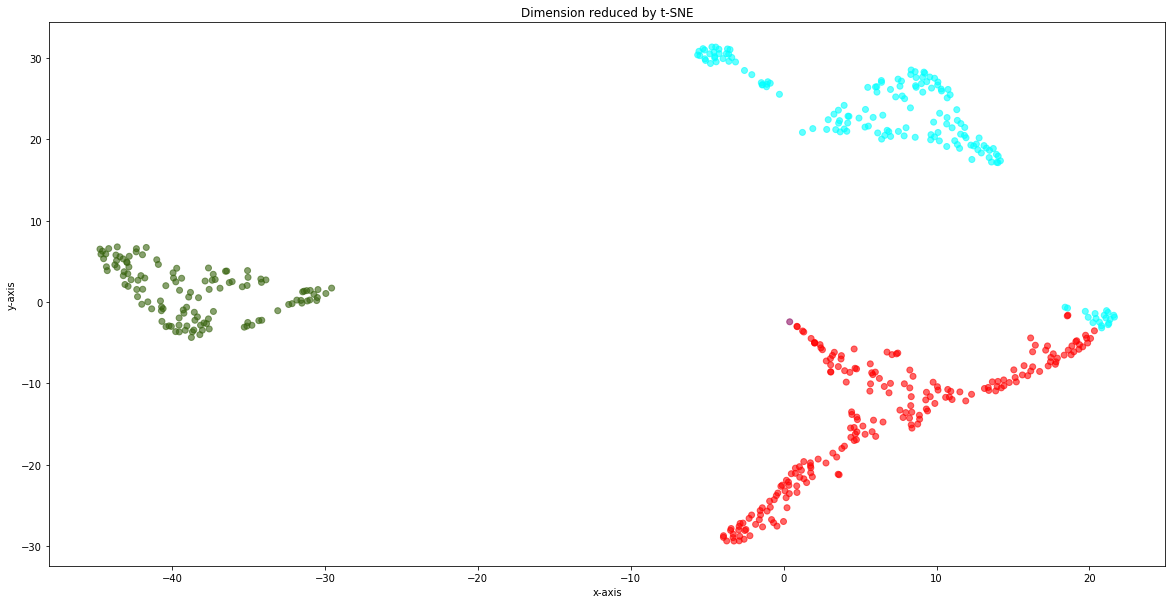

In [656]:
plot_tsne(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7)

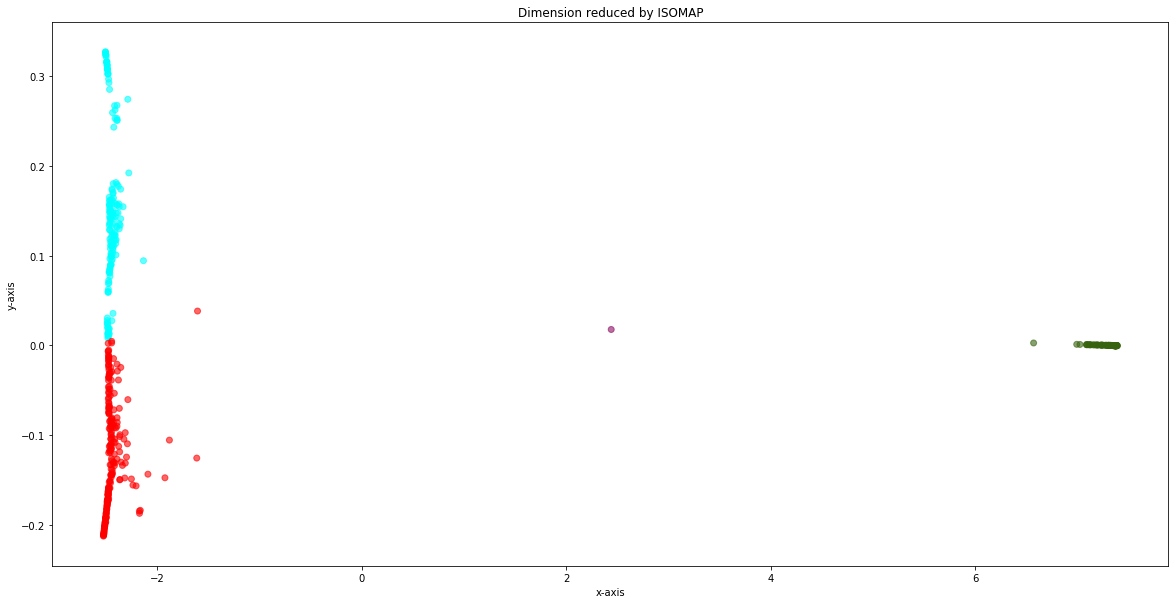

In [657]:
plot_isomap(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7, neighbor=20, dimension=2)

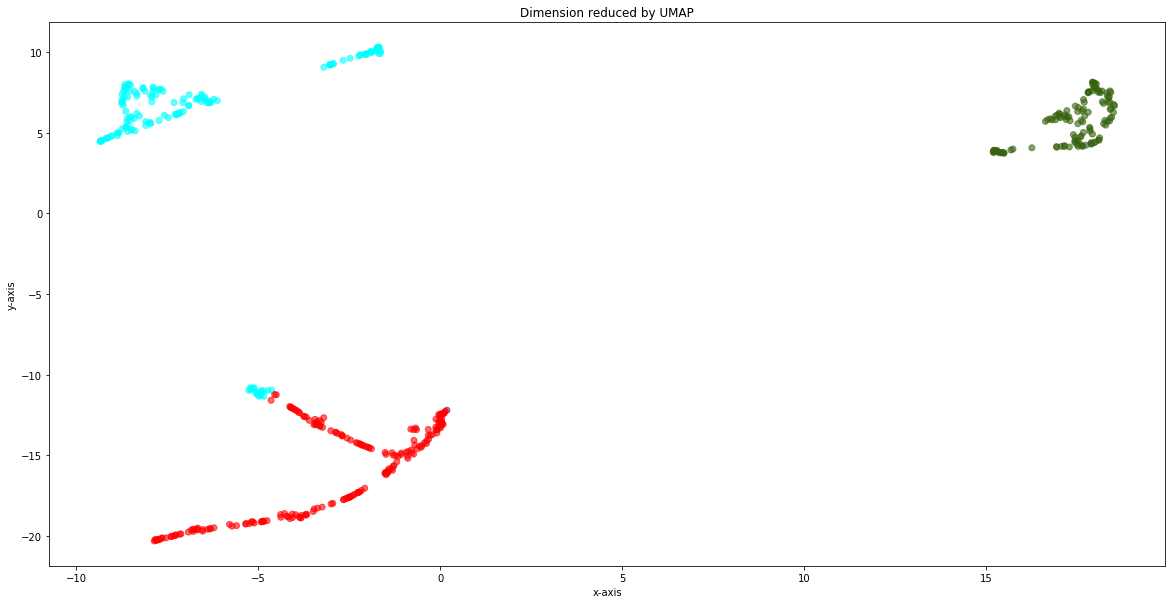

In [658]:
plot_umap(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7, neighbor=20, dimension=2)

### We see that even increasing the cluster count does not improve the internal validation score of our clusters. Hence, we shall be dividing the data into quarters and experimenting with the same technique once again. 

### Some other observations

### Associate each building with its primary use

In [659]:
#map corresponding building to its primary use
temp = train.drop_duplicates(["building_id","primary_use"])
temp = temp[["building_id", "primary_use"]]
temp.set_index("building_id")
temp.sort_values(by="building_id", inplace=True) 

### Get a count of total number of each category in primary use

In [660]:
#make a copy oforiginalpivot_table
temp2 = copy.deepcopy(perHourElectricityConsumptionEachBuilding)
perHourElectricityConsumptionEachBuilding.reset_index(level = ["building_id","cluster"], inplace=True)
perHourElectricityConsumptionEachBuilding = pd.merge(perHourElectricityConsumptionEachBuilding,temp, left_on="building_id", right_on="building_id", how="left")
perHourElectricityConsumptionEachBuilding.set_index(["building_id","cluster"], inplace=True)
perHourElectricityConsumptionEachBuilding.groupby([perHourElectricityConsumptionEachBuilding.index.get_level_values("cluster"),"primary_use"])["primary_use"].agg("count")
perHourElectricityConsumptionEachBuilding

0            1            2            3  \
building_id cluster                                                       
7           1        1178.814573  1282.717701  1379.058286  1426.737821   
9           1         260.670001   252.841538   333.896691   337.682957   
13          1         266.746058   215.316993   238.113512   245.173105   
14          1         786.901762   761.188824   756.561103   745.342419   
15          1        1293.565783  1282.017065  1254.390826  1202.083681   
...                          ...          ...          ...          ...   
1409        0          45.172800    43.555753    42.349082    41.299507   
1410        0          37.462231    36.711747    36.054020    34.789019   
1411        0           7.654904     7.281184     6.598680     6.199281   
1412        0           3.159444     3.066691     2.964252     2.948800   
1413        0           2.914858     2.981089     3.014467     2.834536   

                               4            5            6            7  \
building_id cluster                                                       
7           1        1441.742488  1464.600767  2830.898508  3780.842027   
9           1         325.342377   322.537630   731.786796   801.574629   
13          1         453.430375   659.481620  2186.408366  2925.457171   
14          1         746.043571   745.202176  1803.546495  1883.199203   
15          1        1112.334116  1047.686166  2064.380911  2003.098867   
...                          ...          ...          ...          ...   
1409        0          40.594241    40.883564    42.300817    43.568154   
1410        0          34.450168    34.854324    35.632684    35.515857   
1411        0           6.029770     5.869592     5.989491     6.218257   
1412        0           2.792451     3.900064     4.097280     4.219452   
1413        0           2.887680     2.995222     3.245891     3.108158   

                               8            9  ...           15           16  \
building_id cluster                            ...                             
7           1        3751.252492  3905.224191  ...  4298.536754  4285.251016   
9           1         832.669442   903.691365  ...   965.855330   963.502683   
13          1        2427.022160  2743.527336  ...  2998.959182  2873.484387   
14          1        2821.222505  3506.106343  ...  3980.921043  3776.235443   
15          1        2021.750009  2173.763739  ...  2653.439636  2642.091220   
...                          ...          ...  ...          ...          ...   
1409        0          46.324876    50.177162  ...    62.367582    61.053433   
1410        0          37.099227    39.830203  ...    46.652452    46.468903   
1411        0           7.133082     8.389064  ...    14.965760    15.620881   
1412        0           4.006193     4.518169  ...     6.000356     5.687556   
1413        0           2.963813     2.818136  ...     3.021161     2.916117   

                              17           18           19           20  \
building_id cluster                                                       
7           1        4122.775541  3933.866918  3724.900592  3524.077261   
9           1         919.078179   846.421271   774.087757   745.159206   
13          1        2748.749842  2667.955852  2562.786424  2442.358478   
14          1        3574.871134  3304.863361  3084.918773  2876.712409   
15          1        2646.935364  2525.009446  2498.798852  2563.687008   
...                          ...          ...          ...          ...   
1409        0          59.382637    57.593188    55.260256    52.500667   
1410        0          46.202548    44.449415    41.273025    40.279507   
1411        0          15.197720    13.709331    12.529686    11.142545   
1412        0           5.576437     5.295983     5.014128     3.488222   
1413        0           2.909952     3.272102     3.214550     3.063209   

                              21           22           23  \


### assign a numeric value to each categpry in primary use for further use in later sections

In [661]:
perHourElectricityConsumptionEachBuilding["code"] = perHourElectricityConsumptionEachBuilding["primary_use"].astype("category").cat.codes
perHourElectricityConsumptionEachBuilding

0            1            2            3  \
building_id cluster                                                       
7           1        1178.814573  1282.717701  1379.058286  1426.737821   
9           1         260.670001   252.841538   333.896691   337.682957   
13          1         266.746058   215.316993   238.113512   245.173105   
14          1         786.901762   761.188824   756.561103   745.342419   
15          1        1293.565783  1282.017065  1254.390826  1202.083681   
...                          ...          ...          ...          ...   
1409        0          45.172800    43.555753    42.349082    41.299507   
1410        0          37.462231    36.711747    36.054020    34.789019   
1411        0           7.654904     7.281184     6.598680     6.199281   
1412        0           3.159444     3.066691     2.964252     2.948800   
1413        0           2.914858     2.981089     3.014467     2.834536   

                               4            5            6            7  \
building_id cluster                                                       
7           1        1441.742488  1464.600767  2830.898508  3780.842027   
9           1         325.342377   322.537630   731.786796   801.574629   
13          1         453.430375   659.481620  2186.408366  2925.457171   
14          1         746.043571   745.202176  1803.546495  1883.199203   
15          1        1112.334116  1047.686166  2064.380911  2003.098867   
...                          ...          ...          ...          ...   
1409        0          40.594241    40.883564    42.300817    43.568154   
1410        0          34.450168    34.854324    35.632684    35.515857   
1411        0           6.029770     5.869592     5.989491     6.218257   
1412        0           2.792451     3.900064     4.097280     4.219452   
1413        0           2.887680     2.995222     3.245891     3.108158   

                               8            9  ...           16           17  \
building_id cluster                            ...                             
7           1        3751.252492  3905.224191  ...  4285.251016  4122.775541   
9           1         832.669442   903.691365  ...   963.502683   919.078179   
13          1        2427.022160  2743.527336  ...  2873.484387  2748.749842   
14          1        2821.222505  3506.106343  ...  3776.235443  3574.871134   
15          1        2021.750009  2173.763739  ...  2642.091220  2646.935364   
...                          ...          ...  ...          ...          ...   
1409        0          46.324876    50.177162  ...    61.053433    59.382637   
1410        0          37.099227    39.830203  ...    46.468903    46.202548   
1411        0           7.133082     8.389064  ...    15.620881    15.197720   
1412        0           4.006193     4.518169  ...     5.687556     5.576437   
1413        0           2.963813     2.818136  ...     2.916117     2.909952   

                              18           19           20           21  \
building_id cluster                                                       
7           1        3933.866918  3724.900592  3524.077261  3311.214290   
9           1         846.421271   774.087757   745.159206   285.163757   
13          1        2667.955852  2562.786424  2442.358478  2301.121990   
14          1        3304.863361  3084.918773  2876.712409  2151.056370   
15          1        2525.009446  2498.798852  2563.687008  2551.845861   
...                          ...          ...          ...          ...   
1409        0          57.593188    55.260256    52.500667    50.411730   
1410        0          44.449415    41.273025    40.279507    39.505268   
1411        0          13.709331    12.529686    11.142545    10.123382   
1412        0           5.295983     5.014128     3.488222     3.469769   
1413        0           3.272102     3.214550     3.063209     2.960324   

                              22           23          primary

# Divide data into quarters and perform the above experiment.

#### Experiment over quarter 1

In [662]:
quarter1 = copy.deepcopy(train)
quarter1["quarter"] = quarter1["timestamp"].dt.quarter
quarter1 = quarter1[quarter1["quarter"]==1]
quarter1["meter_reading"].fillna(0, inplace=True)

In [663]:
perHourElectricityConsumptionEachBuildingQ1 = quarter1.pivot_table(values="meter_reading", index="building_id", columns="hour", aggfunc={"meter_reading":np.mean})
perHourElectricityConsumptionEachBuildingQ1.fillna(0, inplace=True)
#perHourElectricityConsumptionEachBuildingQ1.drop(perHourElectricityConsumptionEachBuildingQ1.index[[1100,779,1198,1089,1022,1169,1160,1149,1285]], inplace=True)
perHourElectricityConsumptionEachBuildingQ1.head(5)

hour                 0           1           2           3           4   \
building_id                                                               
7            865.993258  916.373194  979.007710  946.328742  949.051968   
9             25.870865   20.424377   25.870881   25.870884   34.040616   
13           126.631061   87.143984  159.310174   91.228855  108.929968   
14           679.450645  660.387968  684.897226  667.196129  702.598258   
15           955.860903  964.030903  987.177861  831.952658  738.000668   

hour                 5            6            7            8            9   \
building_id                                                                   
7            944.967161  1603.994097  2917.960645  2817.201290  2963.957813   
9            197.435574   671.280787   687.620268   665.834410   733.404881   
13           441.166500  1279.927387  2491.772806  1855.894258  2105.242313   
14           701.236581  1614.885161  1612.162581  2234.425806  2628.913125   
15           695.790368  1367.070842  1232.270894  1199.591839  1383.708000   

hour         ...           14           15           16           17  \
building_id  ...                                                       
7            ...  3673.620625  3686.810625  3569.413438  3452.015937   
9            ...   853.440691   860.035981   816.506525   772.977287   
13           ...  2462.710219  2456.115562  2254.297125  2198.896250   
14           ...  3263.388750  3217.220313  2982.425625  2847.879687   
15           ...  2291.230250  2336.078844  2086.773438  2238.467375   

hour                  18           19           20           21           22  \
building_id                                                                    
7            3341.214063  2989.020000  2808.306875  2615.722188  1815.045313   
9             746.595806   680.642141   605.455041    67.272753    32.976856   
13           2156.685219  2073.582969  1874.404750  1738.539469  1046.024875   
14           2821.498438  2507.558750  2328.164375  1886.275938  1803.172812   
15           2015.543031  1956.185406  1796.578531  1757.005969  1030.196406   

hour                  23  
building_id               
7             840.249875  
9              31.657778  
13            104.206850  
14           1185.846250  
15            987.986562  

[5 rows x 24 columns]

In [664]:
XQ1 = MinMaxScaler().fit_transform(perHourElectricityConsumptionEachBuildingQ1.values.copy())
XQ1

array([[0.16158538, 0.17269693, 0.18906125, ..., 0.46009265, 0.32722947,
        0.1499529 ],
       [0.00482724, 0.00384912, 0.00499606, ..., 0.01183295, 0.00594531,
        0.00564972],
       [0.02362805, 0.01642289, 0.03076521, ..., 0.30580053, 0.18858491,
        0.01859699],
       ...,
       [0.00200569, 0.00176093, 0.00220762, ..., 0.00219619, 0.00229444,
        0.00190616],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [665]:
silhouette_scores_q1 = list()
inertia = list()
no_cluster = np.arange(2,28).astype("int")
for cluster in no_cluster:
    kmeansQ1 = KMeans(n_clusters=cluster, init="k-means++")
    c_f = kmeansQ1.fit_predict(XQ1)
    silhouette_scores_q1.append(silhouette_score(XQ1, kmeansQ1.labels_))
    inertia.append(kmeansQ1.inertia_)
    

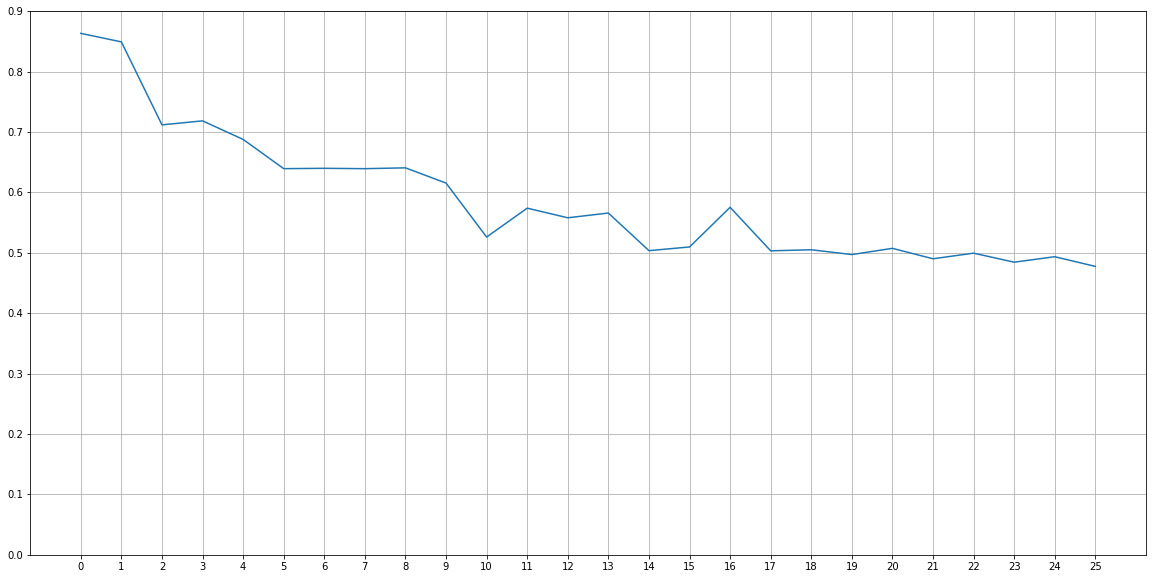

In [666]:
plt.figure(figsize=(20,10))
plt.plot([i for i in range(0,26,1)], silhouette_scores_q1)
plt.xticks([i for i in range(0,26,1)])
plt.yticks(np.arange(0,1,0.1))
plt.grid()

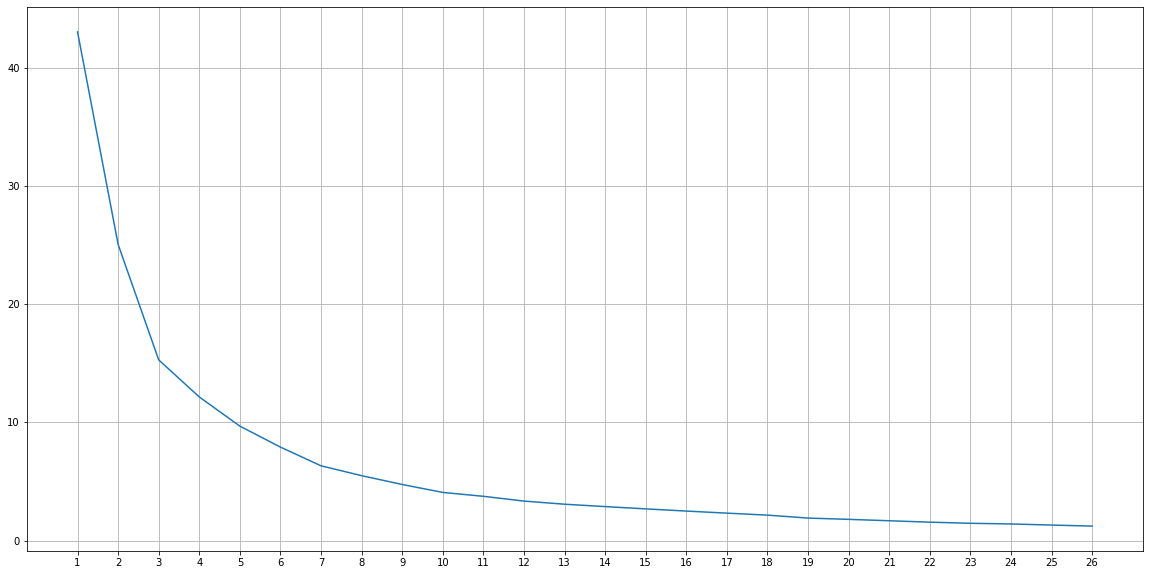

In [667]:
plt.figure(figsize=(20,10))
plt.plot([i for i in range(1,27,1)], inertia)
plt.xticks([i for i in range(1,27,1)])
plt.grid()

#### Clustering with euclidean distance

In [668]:
kmeans = KMeans(n_clusters=3)
cluster_found_q1 = kmeans.fit_predict(XQ1)
cluster_found_sr_q1 = pd.Series(cluster_found_q1, name="cluster")
perHourElectricityConsumptionEachBuildingQ1.set_index(cluster_found_sr_q1, append=True, inplace=True)

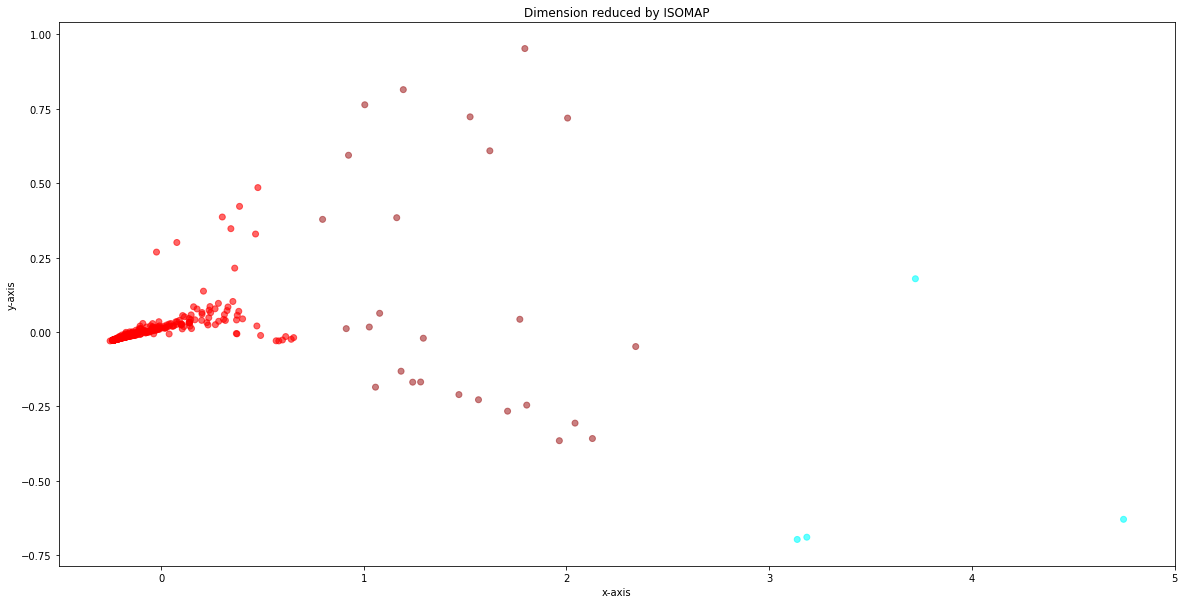

In [669]:
plot_isomap(XQ1, perHourElectricityConsumptionEachBuildingQ1, dimension=2, neighbor=10)

#### Clustering with DTW distance

In [670]:
perHourElectricityConsumptionEachBuildingQ1.index = perHourElectricityConsumptionEachBuildingQ1.index.droplevel(-1)
kmeansTslearn = TimeSeriesKMeans(n_clusters=3, max_iter=1000, metric="dtw", n_jobs=4, init="k-means++")
cluster_found_q1 = kmeansTslearn.fit_predict(XQ1)
cluster_found_sr_q1 = pd.Series(cluster_found_q1, name="cluster")
perHourElectricityConsumptionEachBuildingQ1.set_index(cluster_found_sr_q1, append=True, inplace=True)

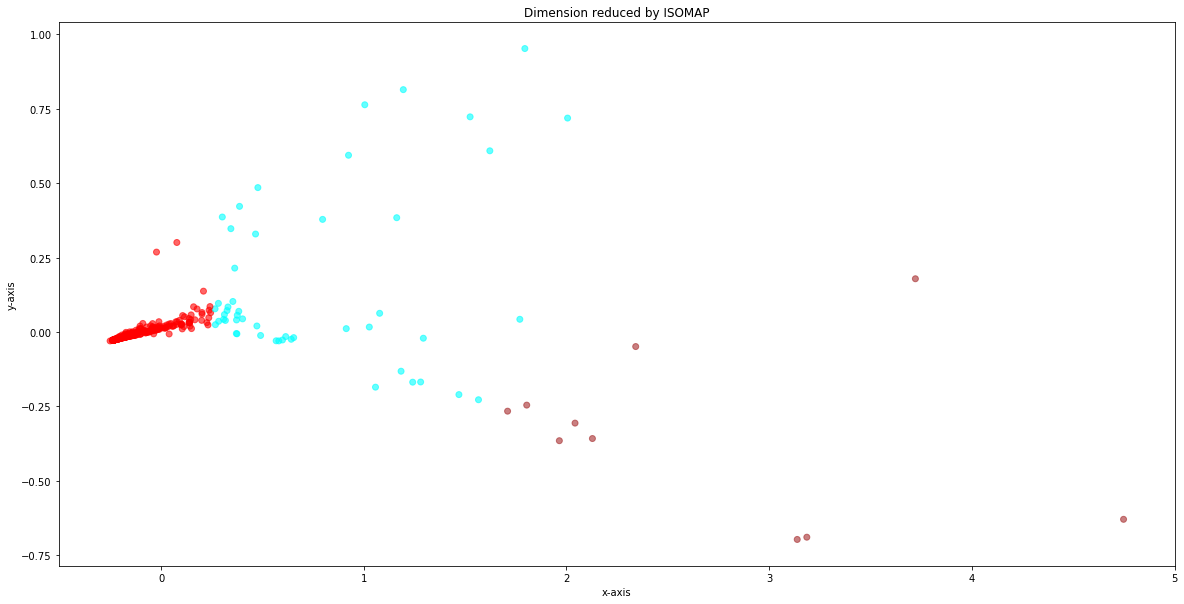

In [671]:
plot_isomap(XQ1, perHourElectricityConsumptionEachBuildingQ1, dimension=2, neighbor = 10)

In [672]:
# printing the score of internal validation measures
print("silhouette score on euclidean metric: ",silhouette_score(XQ1, kmeans.labels_))
print("silhouette score on dtw metric: ",silhouette_score(XQ1, kmeansTslearn.labels_))
print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(XQ1, kmeans.labels_))
print("calsinki-H score on dtw metric: ",calinski_harabasz_score(XQ1, kmeansTslearn.labels_))
print("davis-B score on euclidean metric: ",davies_bouldin_score(XQ1, kmeans.labels_))
print("davis-B score on dtw metric: ",davies_bouldin_score(XQ1, kmeansTslearn.labels_))

silhouette score on euclidean metric:  0.8492086284799023
silhouette score on dtw metric:  0.7719975118664216
calsinki-H score on euclidean metric:  993.0130566314452
calsinki-H score on dtw metric:  794.8890123586399
davis-B score on euclidean metric:  0.5340645243124801
davis-B score on dtw metric:  0.7151719919710526


## Perform Kmeans on quarter 2 with distances: euclidean, DTW

Internal Validation scores for quarter 2
silhouette score on euclidean metric:  0.7432109187417731
silhouette score on dtw metric:  0.7146124124847646
calsinki-H score on euclidean metric:  907.1946633112249
calsinki-H score on dtw metric:  820.6737835942497
davis-B score on euclidean metric:  0.5665497875711214
davis-B score on dtw metric:  0.6320971698652819


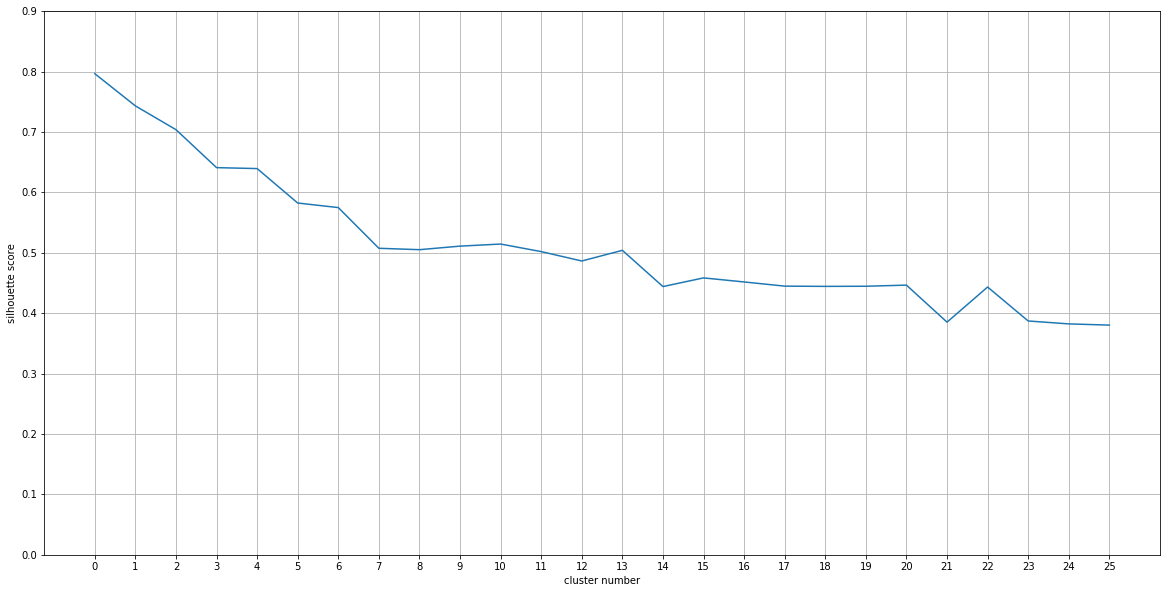

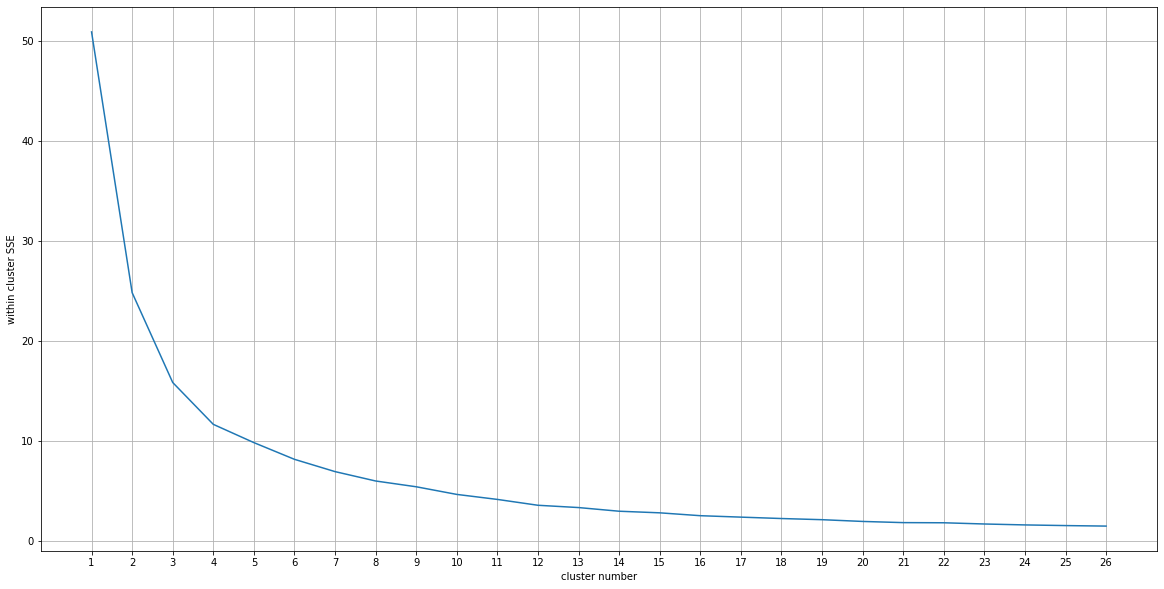

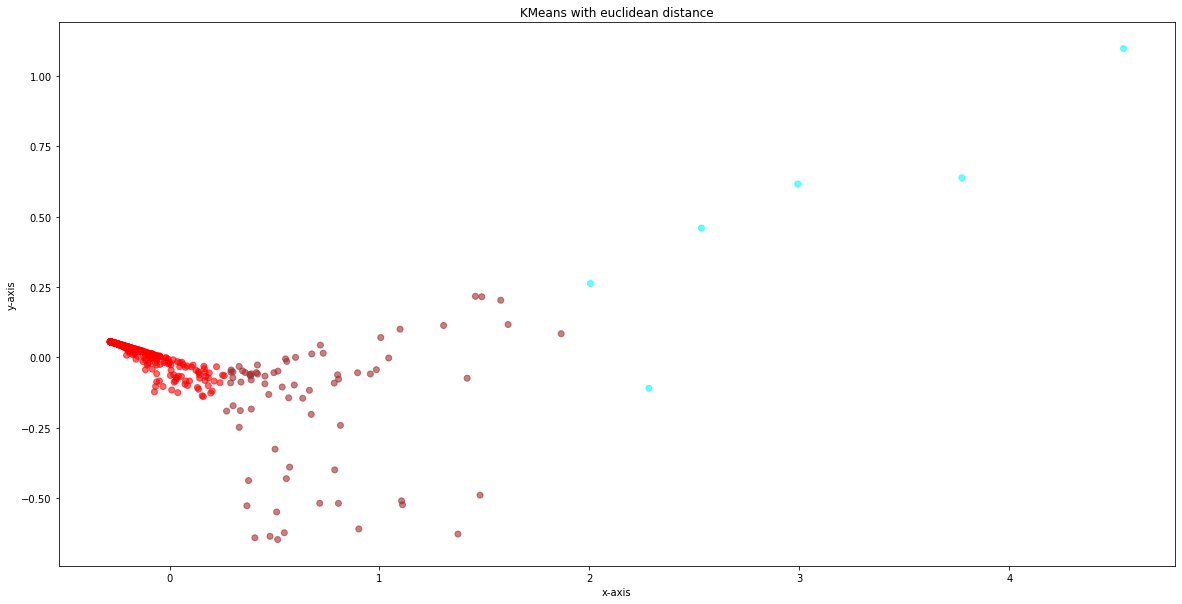

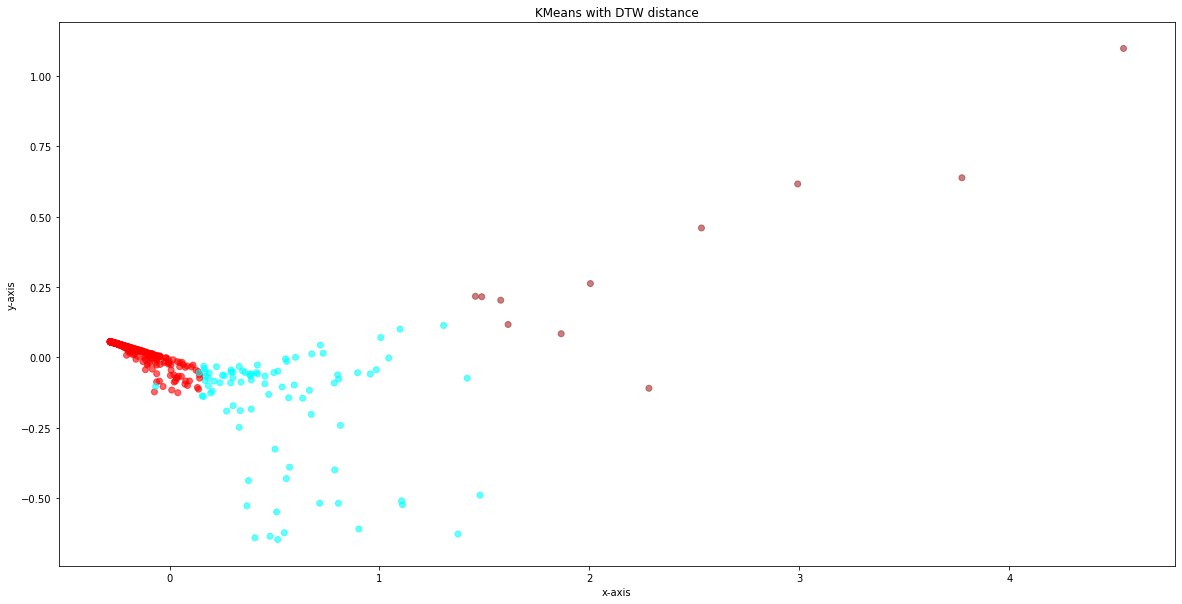

In [673]:
perform_clustering_quarter_wise(2, train)

## Perform Kmeans on quarter 3 with distances: euclidean, DTW

Internal Validation scores for quarter 3
silhouette score on euclidean metric:  0.9099230447529394
silhouette score on dtw metric:  0.8537674385664887
calsinki-H score on euclidean metric:  6035.866857230583
calsinki-H score on dtw metric:  5495.69186065202
davis-B score on euclidean metric:  0.3001079697145517
davis-B score on dtw metric:  0.4280942500275707


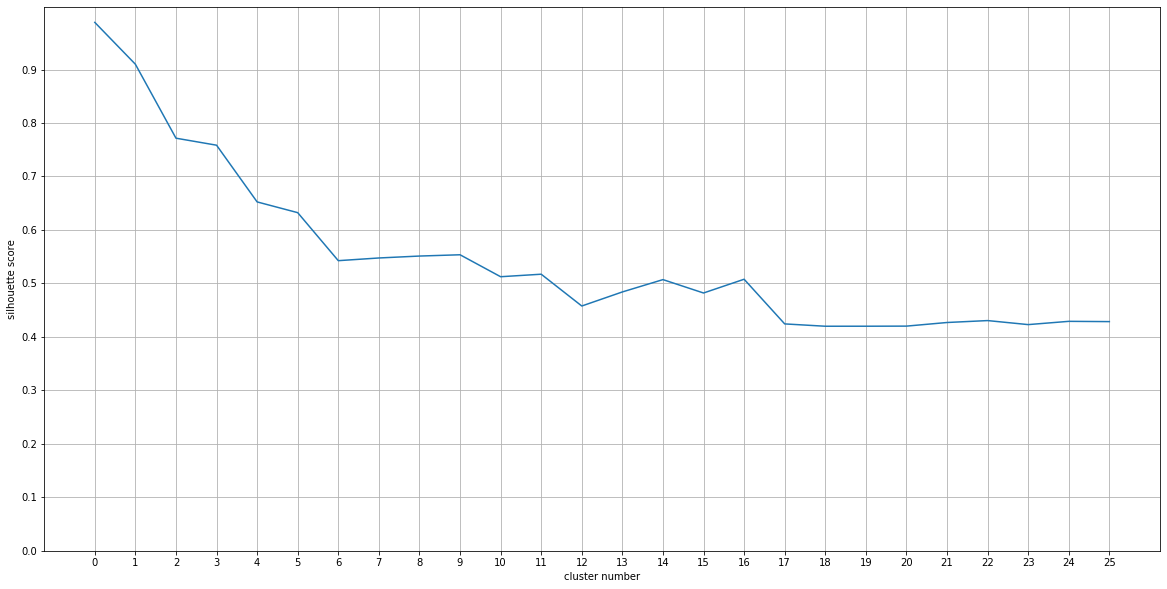

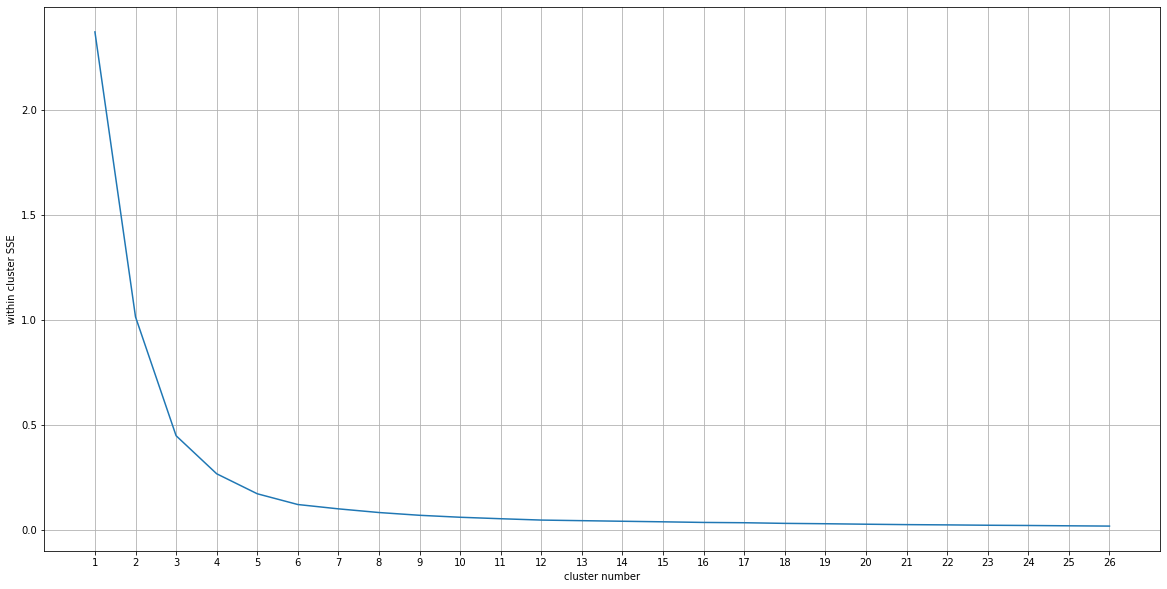

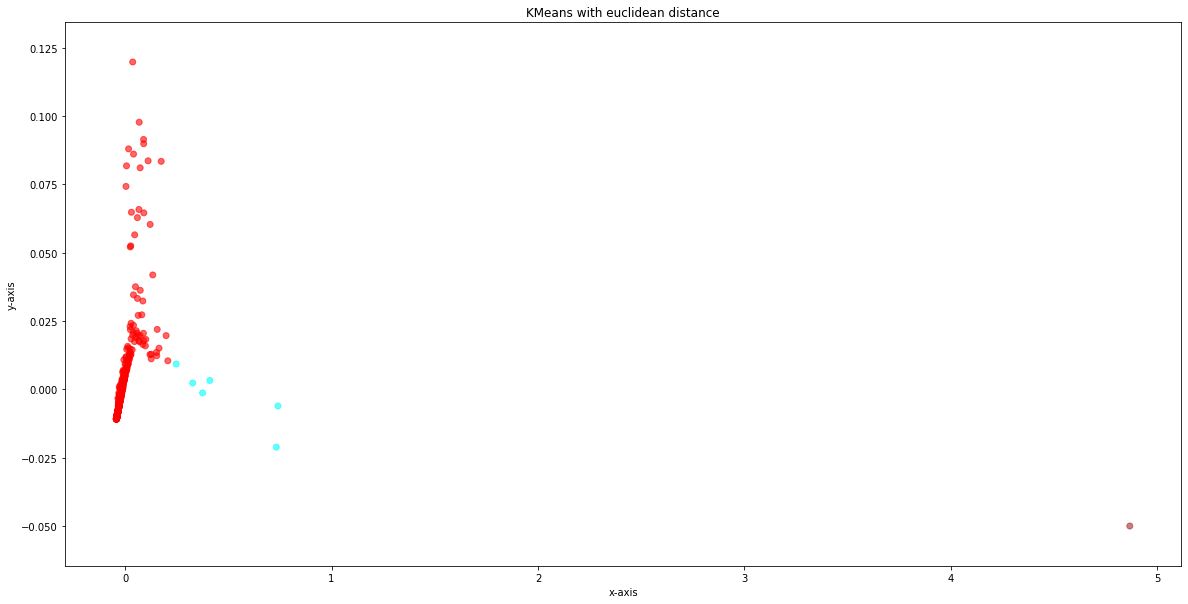

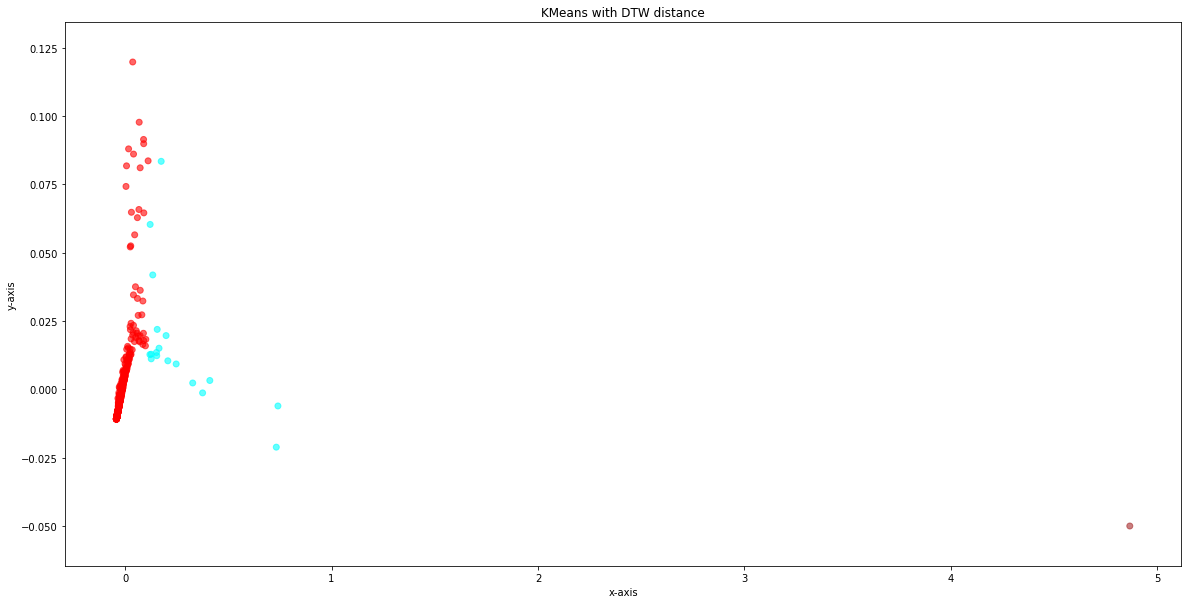

In [674]:
perform_clustering_quarter_wise(3, train)

## Perform Kmeans on quarter 4 with distances: euclidean, DTW

Internal Validation scores for quarter 4
silhouette score on euclidean metric:  0.9595455274123195
silhouette score on dtw metric:  0.9595455274123195
calsinki-H score on euclidean metric:  4256.849542769397
calsinki-H score on dtw metric:  4256.849542769397
davis-B score on euclidean metric:  0.019678407333023572
davis-B score on dtw metric:  0.019678407333023572


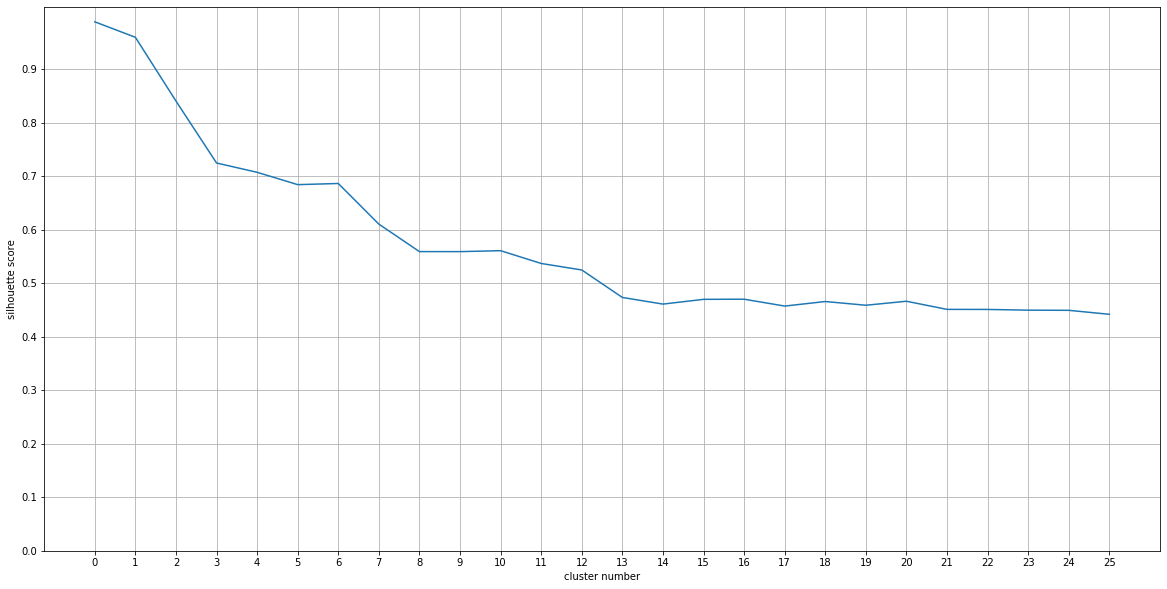

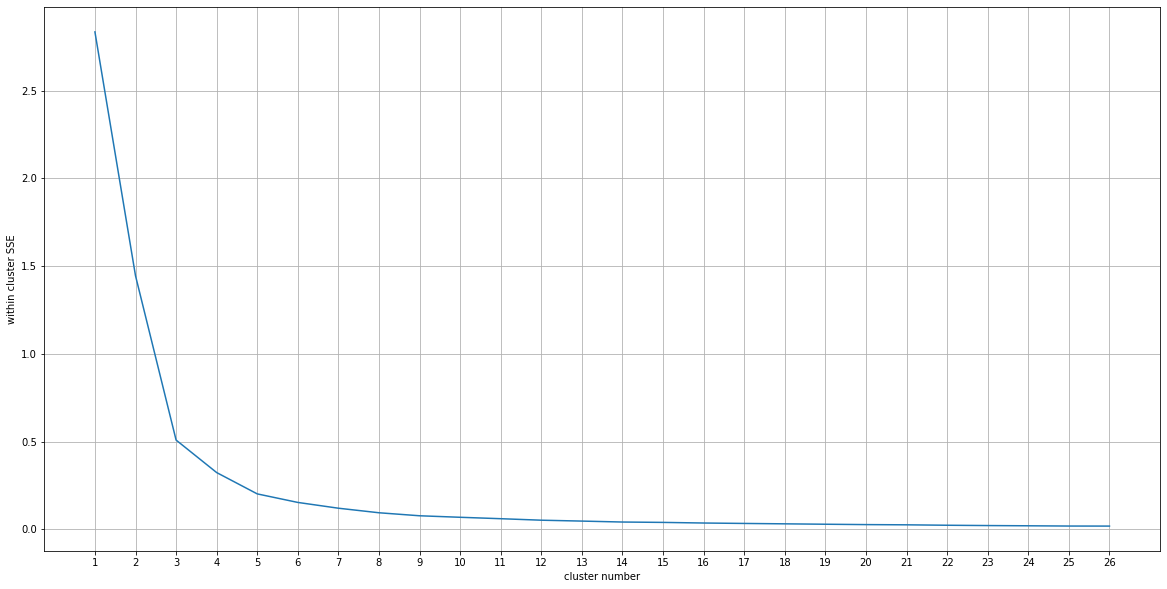

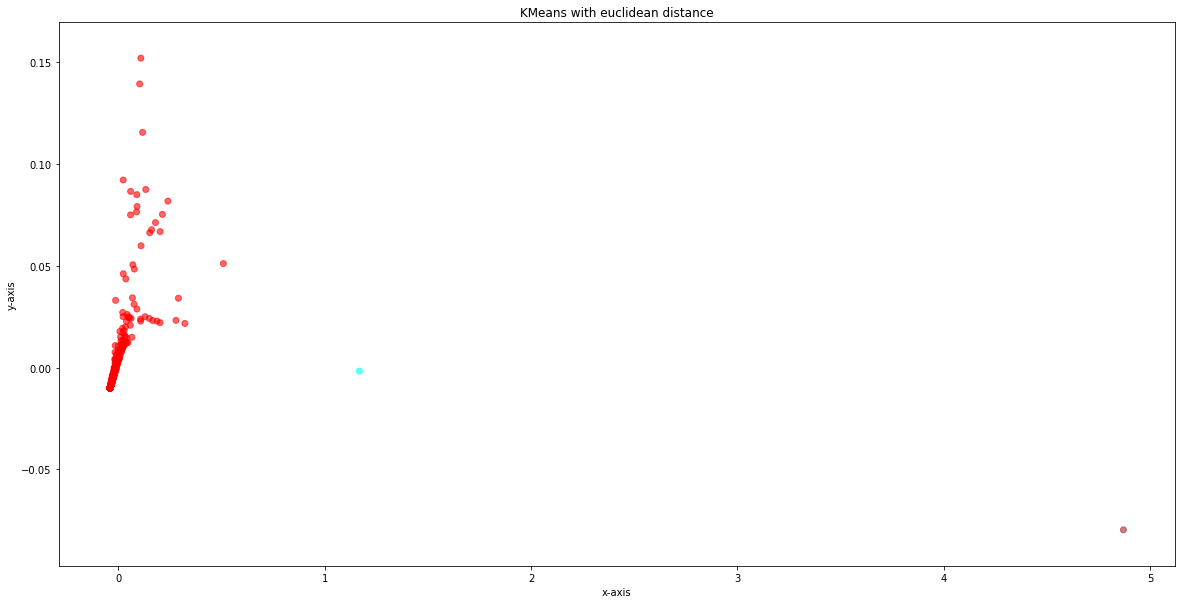

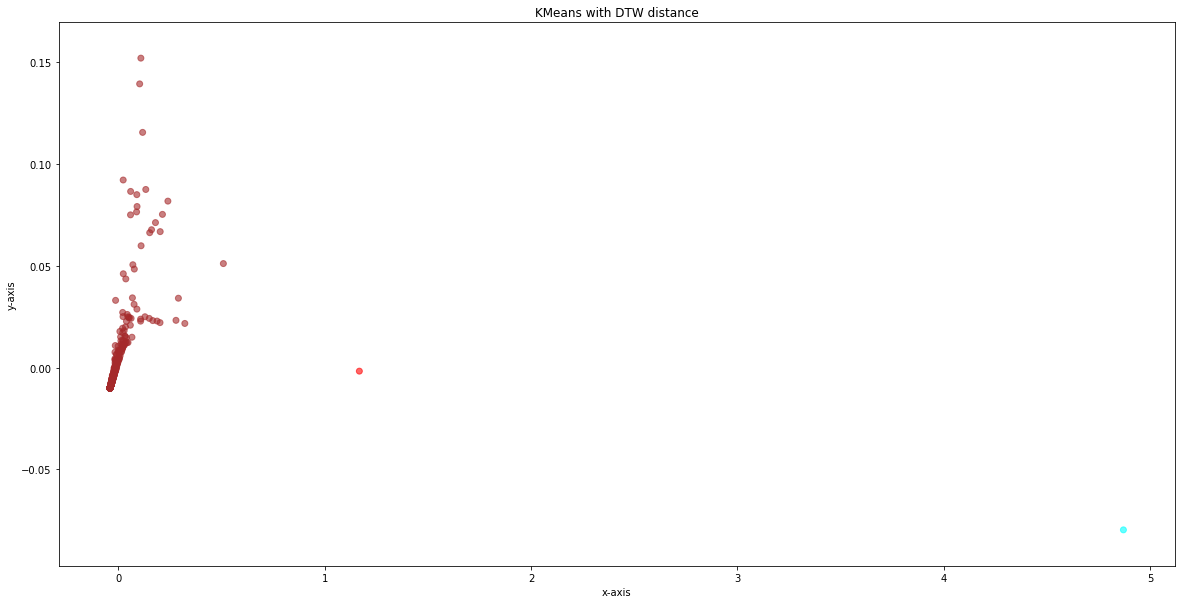

In [675]:
perform_clustering_quarter_wise(4, train)

## Outcome: KMeans with DTW distance does perform better than euclidean distance i.e. Measures based on editing of the time series performed better than shape based distance in the above case. 

# Experiment with spectral clustering..
### 1. First with whole year aggregate data
### 2. Then with quarterly data if the score is not according to the requirement.

In [676]:
wholeYear = copy.deepcopy(train)
perHourElectricityConsumptionEachBuildingWholeYear = wholeYear.pivot_table(values="meter_reading", index="building_id", columns="hour", aggfunc={"meter_reading":np.mean})
XQ1 = MinMaxScaler().fit_transform(perHourElectricityConsumptionEachBuildingWholeYear.values.copy())

spectralCluster = SpectralClustering(n_clusters=2, n_init=10, assign_labels="discretize", n_jobs=-1, random_state=0, degree=3, affinity="nearest_neighbors")
cluster_found_q1 = spectralCluster.fit_predict(XQ1)
cluster_found_sr_q1 = pd.Series(cluster_found_q1, name="cluster")
perHourElectricityConsumptionEachBuildingWholeYear.set_index(cluster_found_sr_q1, append=True, inplace=True)

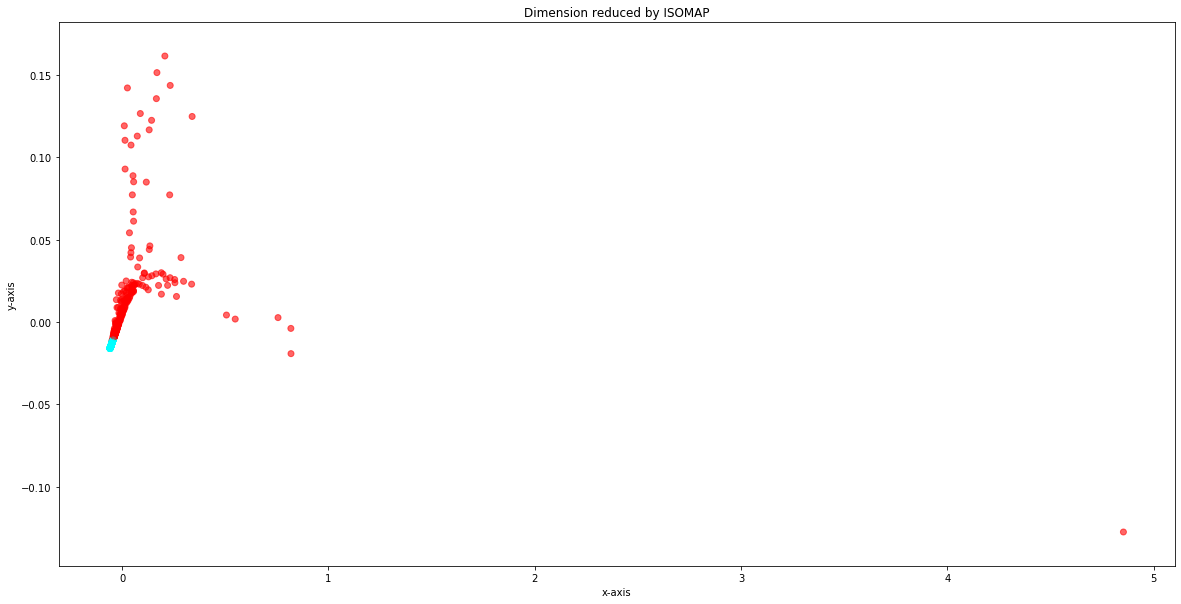

In [677]:
plot_isomap(XQ1, perHourElectricityConsumptionEachBuildingWholeYear, neighbor=10, dimension=2)

In [678]:
print("silhouette score on euclidean metric: ",silhouette_score(XQ1, spectralCluster.labels_))
print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(XQ1, spectralCluster.labels_))
print("davis-B score on euclidean metric: ",davies_bouldin_score(XQ1, spectralCluster.labels_))

silhouette score on euclidean metric:  0.22973018132909415
calsinki-H score on euclidean metric:  22.583217635404363
davis-B score on euclidean metric:  1.0616703895547288


In [679]:
def perform_spectral_cluster_quarter_wise(quarter_no=1, ncl  = 8,train=None):
    wholeYear = copy.deepcopy(train)
    if quarter_no>0:
        wholeYear["quarter"] = wholeYear["timestamp"].dt.quarter
        wholeYear = wholeYear[wholeYear["quarter"]==quarter_no]
    wholeYear.fillna(0, inplace=True)
    
    perHourElectricityConsumptionEachBuilding = wholeYear.pivot(values="meter_reading", index="building_id", columns="timestamp")
    perHourElectricityConsumptionEachBuilding.fillna(0, inplace=True)
    XQ1 = MinMaxScaler().fit_transform(perHourElectricityConsumptionEachBuilding.values.copy())
    spectralCluster = SpectralClustering(n_clusters=ncl, n_init=10, assign_labels="kmeans", n_jobs=-1,eigen_solver="arpack", )
    print("params: ", spectralCluster.get_params)
    cluster_found_q1 = spectralCluster.fit_predict(XQ1)
    cluster_found_sr_q1 = pd.Series(cluster_found_q1, name="cluster")
    perHourElectricityConsumptionEachBuilding.set_index(cluster_found_sr_q1, append=True, inplace=True)
    plot_isomap(XQ1, perHourElectricityConsumptionEachBuilding, neighbor=8, dimension=2)
    
    print("silhouette score on euclidean metric: ",silhouette_score(XQ1, spectralCluster.labels_))
    print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(XQ1, spectralCluster.labels_))
    print("davis-B score on euclidean metric: ",davies_bouldin_score(XQ1, spectralCluster.labels_))
    return 

### Spectral clustering on quarter 1

params:  <bound method BaseEstimator.get_params of SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver='arpack', eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=2, n_init=10, n_jobs=-1,
                   n_neighbors=10, random_state=None)>
silhouette score on euclidean metric:  0.8947873949604763
calsinki-H score on euclidean metric:  159.7776078056937
davis-B score on euclidean metric:  0.24154336080509137


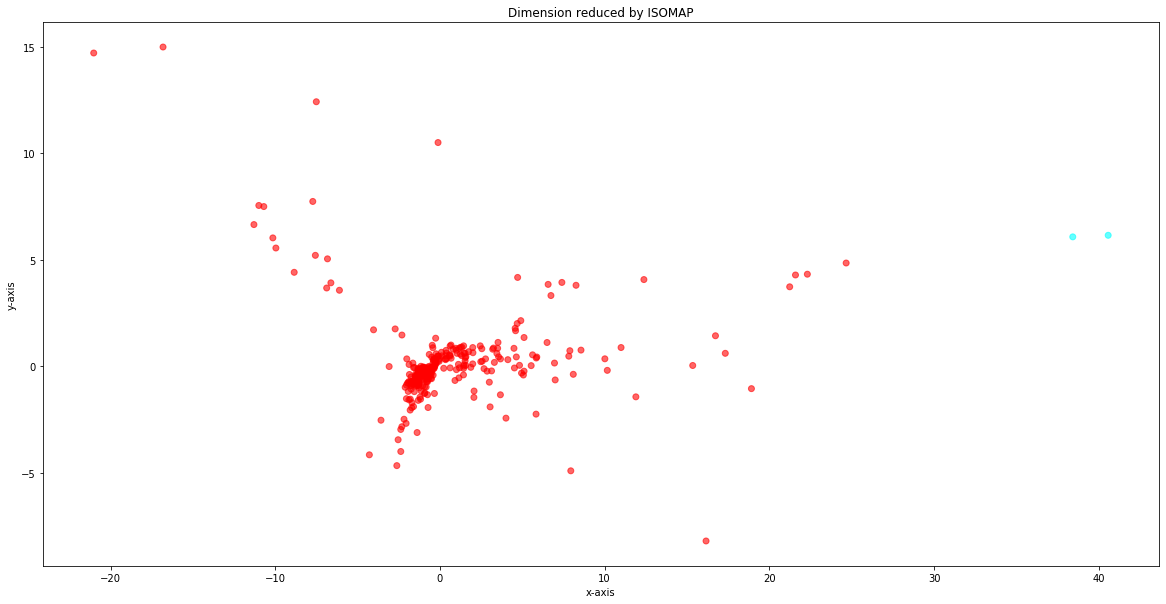

In [680]:
perform_spectral_cluster_quarter_wise(1,2, train)

### Spectral clustering on quarter 2

params:  <bound method BaseEstimator.get_params of SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver='arpack', eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=2, n_init=10, n_jobs=-1,
                   n_neighbors=10, random_state=None)>
silhouette score on euclidean metric:  0.8873866713032648
calsinki-H score on euclidean metric:  74.24314198960775
davis-B score on euclidean metric:  0.07575665757817576


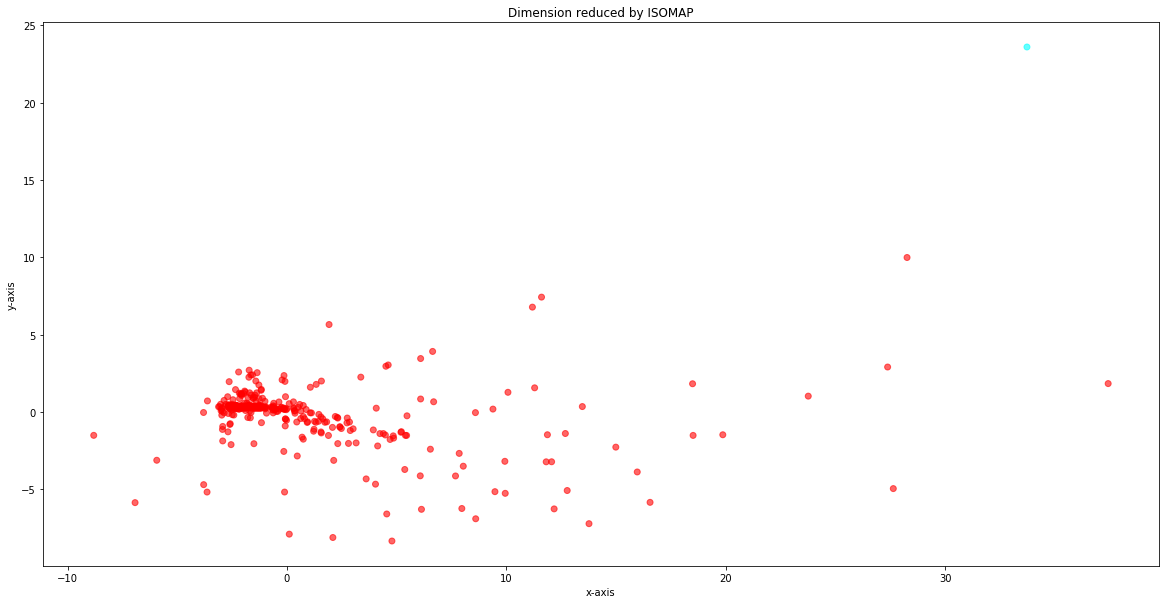

In [681]:
perform_spectral_cluster_quarter_wise(2,2, train)

### Spectral clustering on quarter 3

params:  <bound method BaseEstimator.get_params of SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver='arpack', eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=2, n_init=10, n_jobs=-1,
                   n_neighbors=10, random_state=None)>
silhouette score on euclidean metric:  0.889158102880799
calsinki-H score on euclidean metric:  45.58290959321099
davis-B score on euclidean metric:  0.0847293392063866


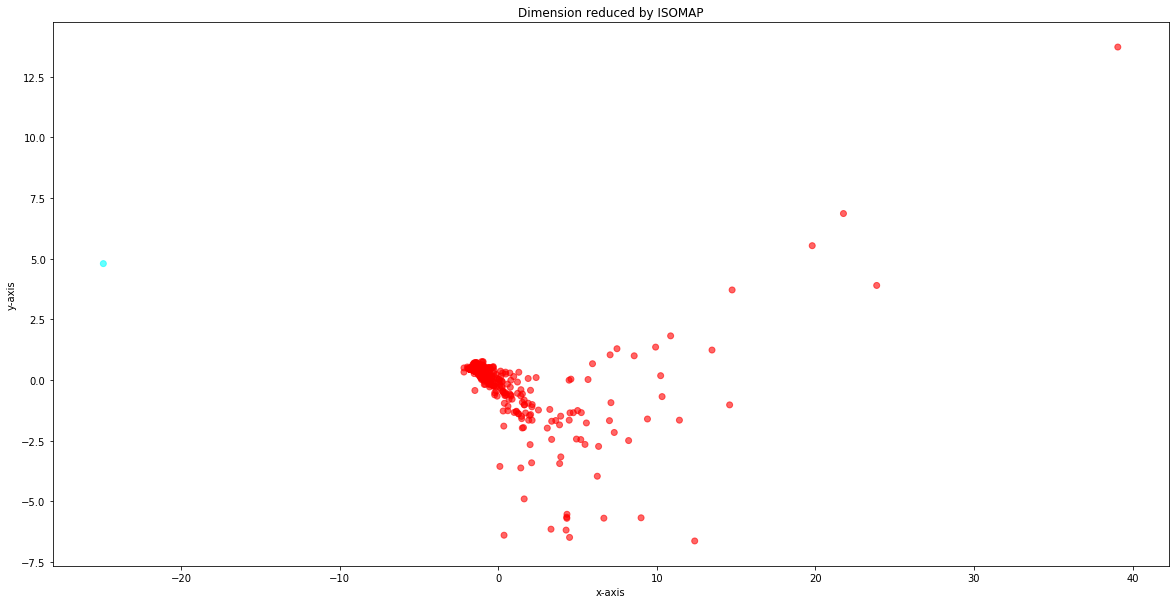

In [682]:
perform_spectral_cluster_quarter_wise(3,2, train)

### Spectral clustering on quarter 4

params:  <bound method BaseEstimator.get_params of SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver='arpack', eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=2, n_init=10, n_jobs=-1,
                   n_neighbors=10, random_state=None)>
silhouette score on euclidean metric:  0.8995431441048234
calsinki-H score on euclidean metric:  88.37258830562799
davis-B score on euclidean metric:  0.06616796773961764


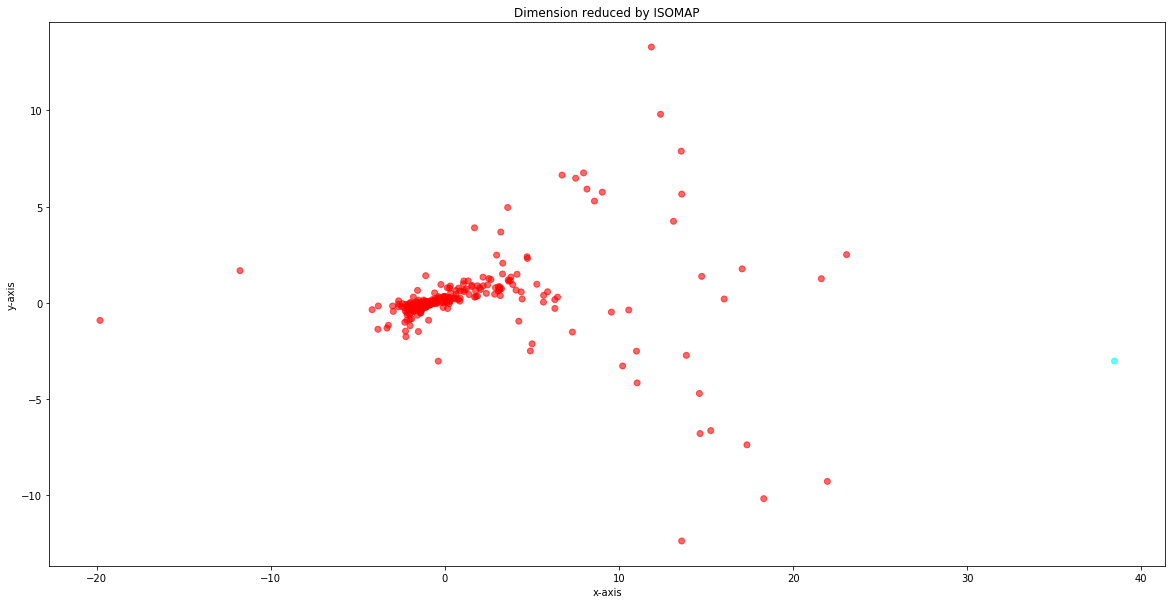

In [683]:
perform_spectral_cluster_quarter_wise(4,2, train)

### Spectral clustering on whole year - function testing part - can be ignored

params:  <bound method BaseEstimator.get_params of SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver='arpack', eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=8, n_init=10, n_jobs=-1,
                   n_neighbors=10, random_state=None)>


C:\Users\ashuk\.conda\envs\udacityDL\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\ashuk\.conda\envs\udacityDL\lib\site-packages\sklearn\cluster\spectral.py:268: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  n_init=n_init)


silhouette score on euclidean metric:  0.8489857770282637
calsinki-H score on euclidean metric:  43.687780239589834
davis-B score on euclidean metric:  0.09819641826150886


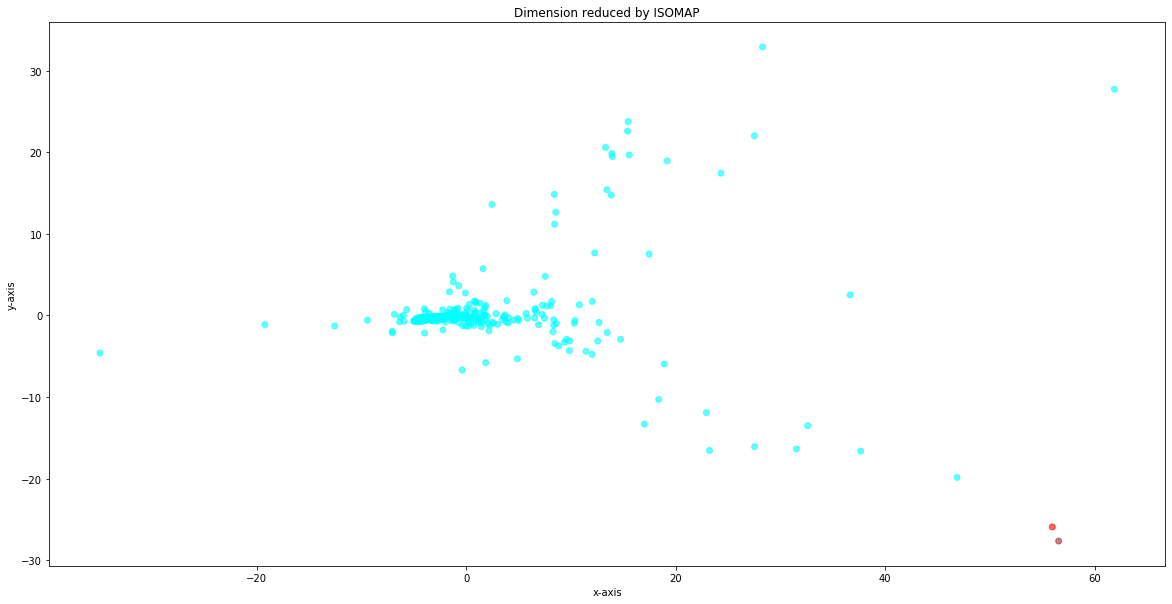

In [684]:
perform_spectral_cluster_quarter_wise(0, train=train)

### Perform Agglomerative clustering and see if any pattern can be extracted.

In [685]:
def plot_scipy_edndogram(pivot=None):
    z = sch.linkage(MinMaxScaler().fit_transform(pivot),"ward")
    plt.figure(figsize=(20,10))
    a = sch.dendrogram(z, show_leaf_counts=False,leaf_font_size=12.,show_contracted=True, leaf_rotation=90)
    return

def performAgglomerativeClustering(ncl = 2, affinity="euclidean", linkage="ward", X=None, pivot=None):
    AGModel = AgglomerativeClustering(n_clusters=ncl,affinity=affinity, linkage=linkage)
    x = MinMaxScaler().fit_transform(X)
    cluster_found = AGModel.fit_predict(x)
    #pivot.set_index("building_id", inplace=True)
    cluster_found = pd.Series(cluster_found, name="cluster")
    pivot.set_index(cluster_found, append=True, inplace=True)
    print("silhouette sample on euclidean metric: ",silhouette_samples(x, cluster_found))
    print("silhouette score on euclidean metric: ",silhouette_score(x, cluster_found))
    print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(x, cluster_found))
    print("davis-B score on euclidean metric: ",davies_bouldin_score(x, cluster_found))
    plot_isomap(x, pivot)
    plot_kernel_pca(x, pivot=pivot, kernel="rbf", g=15,rzev=True, deg = 1)
    plot_tsne(x, pivot)
    plot_umap(x, pivot)
    return pivot

def generate_dtw_matrix(pivot=None):
    from dtaidistance import dtw
    mat = dtw.distance_matrix_fast(pivot)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            if i == j:
                mat[i,j] = 0
            else:
                mat[j,i] = mat[i,j]
    return mat

def generate_quarter_pivot_matrix(quarter_no = 0,pivot=None):
    quarter1 = copy.deepcopy(train)
    if quarter_no>0:
        quarter1["quarter"] = quarter1["timestamp"].dt.quarter
        quarter1 = quarter1[quarter1["quarter"]==quarter_no]
    quarter1["meter_reading"].fillna(0, inplace=True)
    
    if quarter_no>0:
        perHourElectricityConsumptionEachBuildingQ1 = quarter1.pivot_table(values="meter_reading", index="building_id", columns="hour", aggfunc={"meter_reading":np.mean})
        perHourElectricityConsumptionEachBuildingQ1.fillna(0, inplace=True)
    else:
        perHourElectricityConsumptionEachBuildingQ1 = quarter1.pivot(values="meter_reading", index="building_id", columns="timestamp")
        perHourElectricityConsumptionEachBuildingQ1.fillna(0, inplace=True)
    return perHourElectricityConsumptionEachBuildingQ1

In [686]:
aggTrain = copy.deepcopy(train)
aggTrain = aggTrain[~aggTrain["building_id"].isin([1100,779,1198,1089,1022,1169,1160,1149,1285,778])]

### Pivot over whole year data

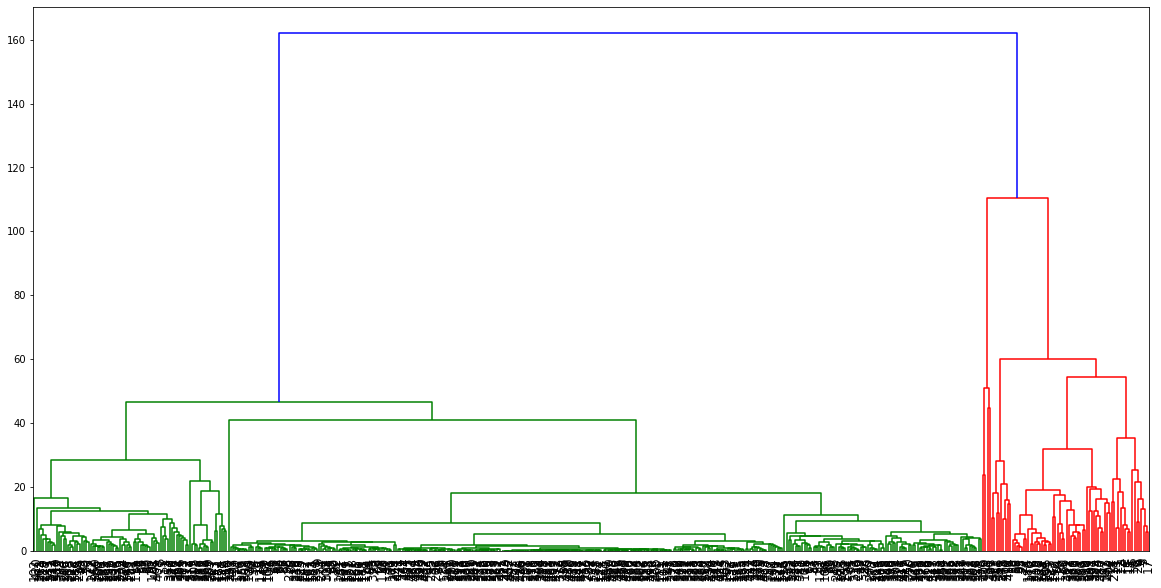

In [687]:
pivot = generate_quarter_pivot_matrix(0,aggTrain)
plot_scipy_edndogram(pivot = pivot.values)

silhouette sample on euclidean metric:  [ 0.13440314  0.63063847 -0.01370089  0.12464646 -0.05513134  0.48827778
  0.16080701  0.15188722  0.16752209  0.83725652  0.07865984  0.64777744
 -0.16282566 -0.14206997  0.16760695 -0.19940319  0.85287379  0.11200147
  0.87352577  0.13168331  0.20153618  0.03503306 -0.06107276  0.69224246
  0.87800109  0.8640564   0.86640288 -0.32460752  0.8750124  -0.48827354
 -0.03661064  0.87830912  0.86956982  0.76976683  0.86502215  0.85593884
  0.81857133  0.87737544  0.74339059  0.88067453  0.87679979  0.87461751
  0.85525767  0.83531763  0.87551015  0.87570237  0.88082408  0.8779758
  0.84401757  0.86190737  0.56417361  0.84369623  0.87899111  0.8424161
  0.83576758  0.75934411 -0.53516274  0.74299274 -0.48262163  0.8705415
  0.86915592  0.80410354  0.86123087  0.88147953  0.17112093  0.81951995
  0.01817666  0.8737668   0.87689945  0.88041487  0.76450456  0.68806714
  0.65249919  0.59949535 -0.21710192  0.88035104  0.80283777  0.80841218
  0.87208609  

timestamp            2016-01-01 00:00:00  2016-01-01 01:00:00  \
building_id cluster                                             
7           0                     0.0000               0.0000   
9           1                     0.0000               0.0000   
13          0                     0.0000               0.0000   
14          0                     0.0000               0.0000   
15          0                     0.0000               0.0000   
...                                  ...                  ...   
1409        1                    23.1770              22.6254   
1410        1                    13.8577              13.6931   
1411        1                     0.0000               0.0000   
1412        1                     0.0000               0.0000   
1413        1                     0.0000               0.0000   

timestamp            2016-01-01 02:00:00  2016-01-01 03:00:00  \
building_id cluster                                             
7           0                     0.0000               0.0000   
9           1                     0.0000               0.0000   
13          0                     0.0000               0.0000   
14          0                     0.0000               0.0000   
15          0                     0.0000               0.0000   
...                                  ...                  ...   
1409        1                    18.4480              18.8264   
1410        1                    14.9525              10.3668   
1411        1                     0.0000               0.0000   
1412        1                     0.0000               0.0000   
1413        1                     0.0000               0.0000   

timestamp            2016-01-01 04:00:00  2016-01-01 05:00:00  \
building_id cluster                                             
7           0                     0.0000               0.0000   
9           1                     0.0000               0.0000   
13          0                     0.0000               0.0000   
14          0                     0.0000               0.0000   
15          0                     0.0000               0.0000   
...                                  ...                  ...   
1409        1                    18.2664              18.2314   
1410        1                    15.3202              14.7201   
1411        1                     0.0000               0.0000   
1412        1                     0.0000               0.0000   
1413        1                     0.0000               0.0000   

timestamp            2016-01-01 06:00:00  2016-01-01 07:00:00  \
building_id cluster                                             
7           0                     0.0000               0.0000   
9           1                     0.0000               0.0000   
13          0                     0.0000               0.0000   
14          0                     0.0000               0.0000   
15          0                     0.0000               0.0000   
...                                  ...                  ...   
1409        1                    18.2861              18.3712   
1410        1                    12.1677              15.5219   
1411        1                     0.0000               0.0000   
1412        1                     0.0000               0.0000   
1413        1                     0.0000               0.0000   

timestamp            2016-01-01 08:00:00  2016-01-01 09:00:00  ...  \
building_id cluster                                            ...   
7           0                     0.0000               0.0000  ...   
9           1                     0.0000               0.0000  ...   
13          0                     0.0000               0.0000  ...   
14          0                     0.0000               0.0000  ...   
15          0                     0.0000               0.0000  ...   
...                                  ...                  ...  ...   
1409        1                    18.3544              18

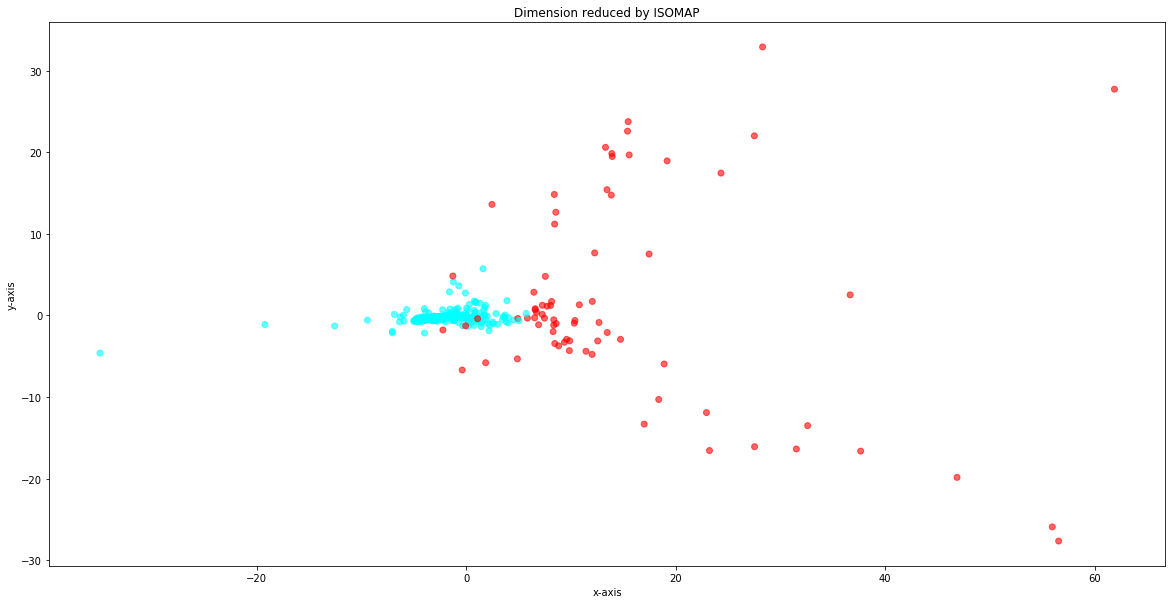

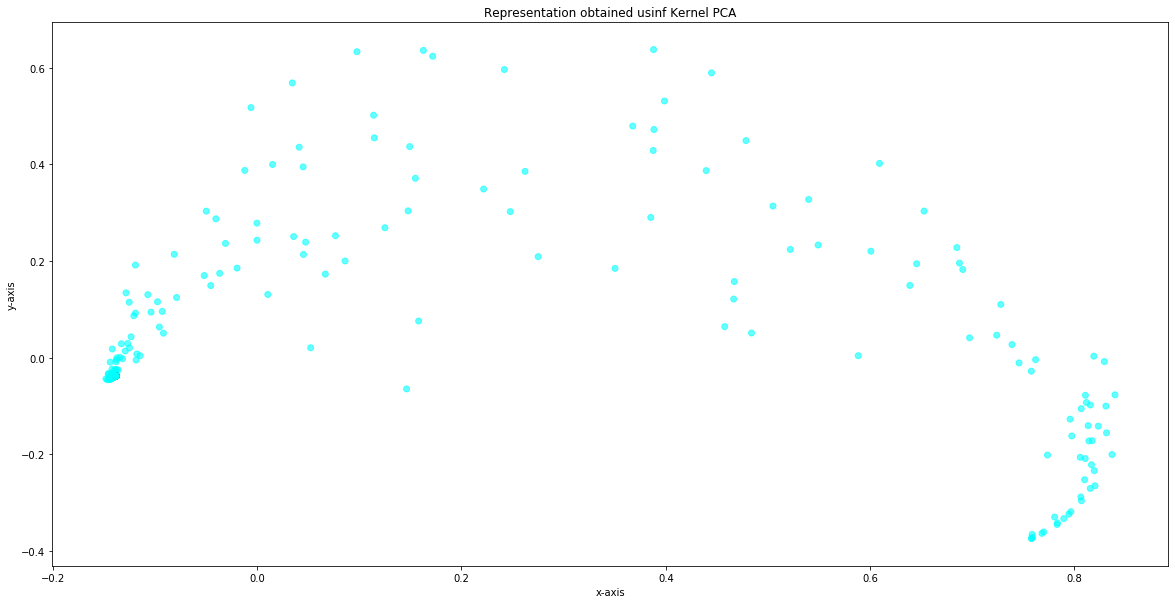

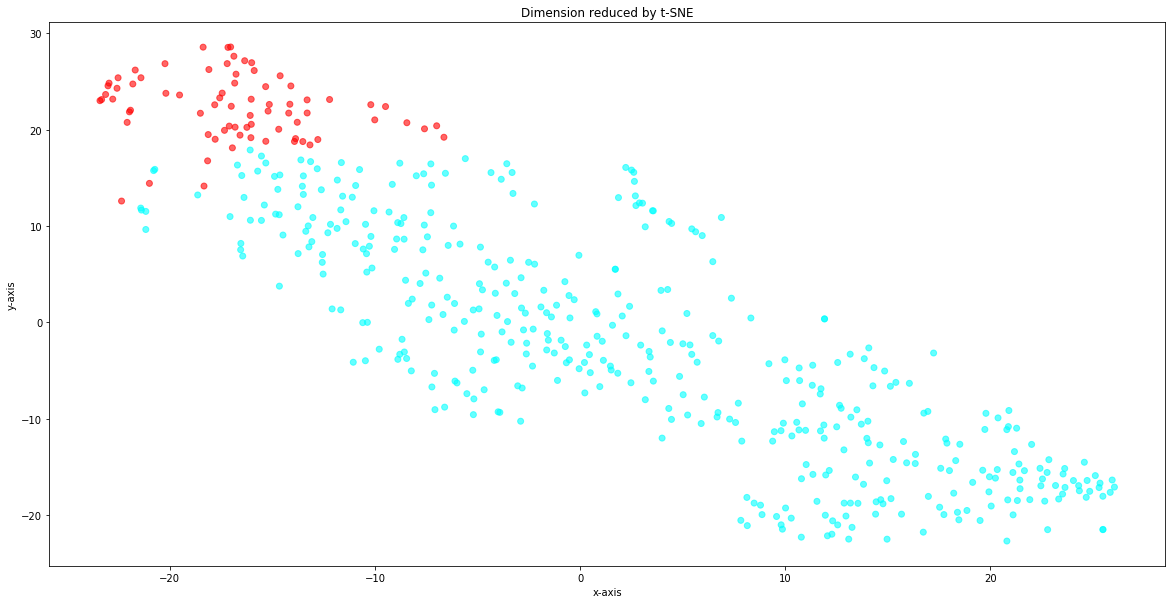

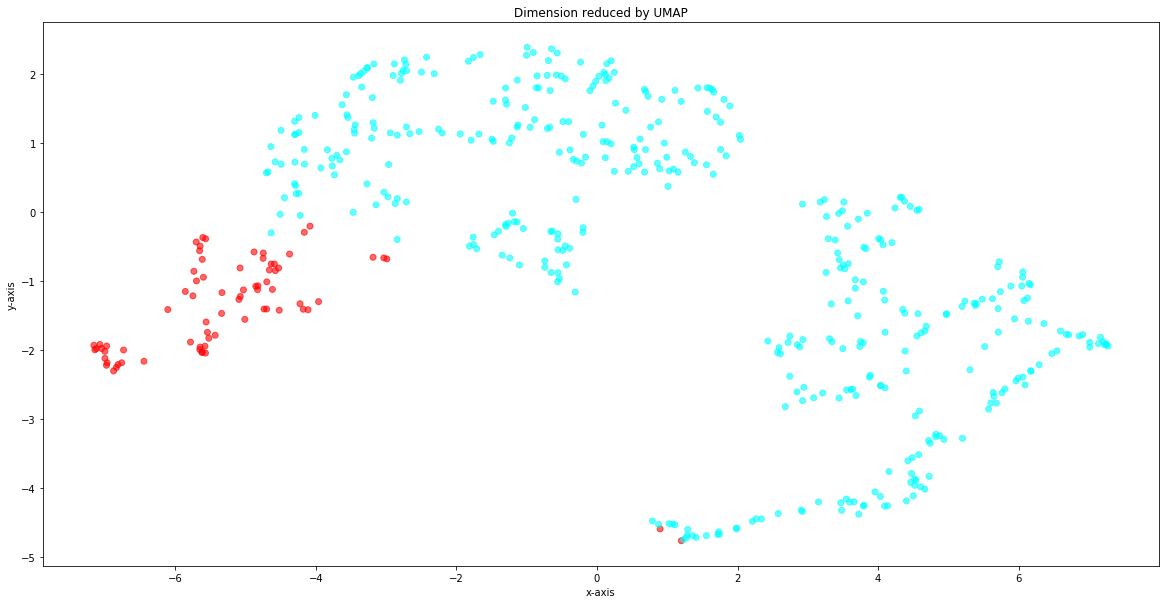

In [688]:
performAgglomerativeClustering(ncl=2, X=pivot.values, pivot=pivot)

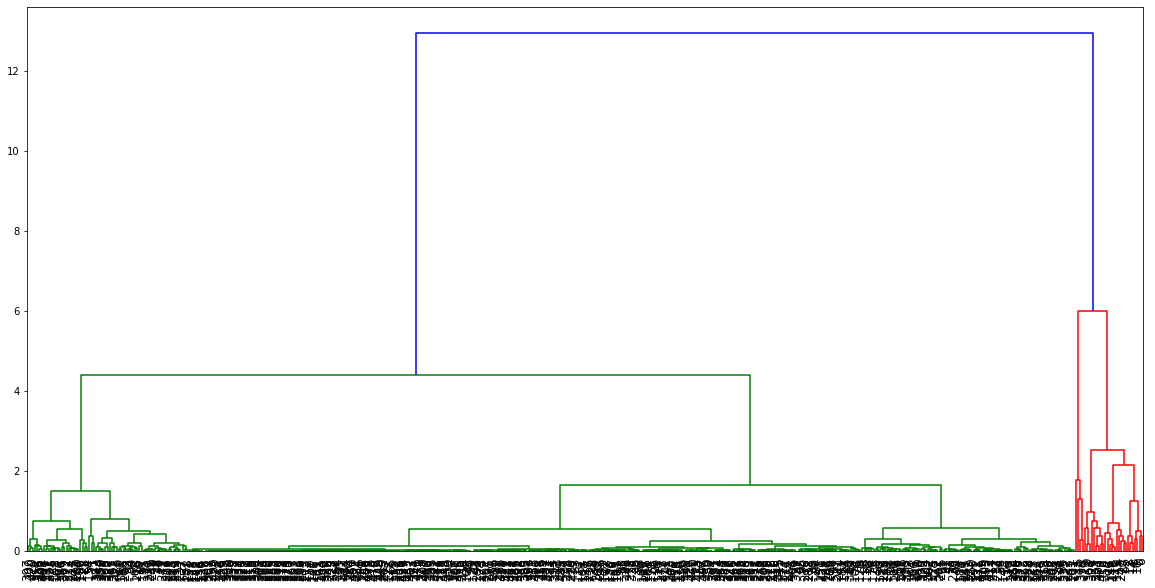

In [689]:
pivot = generate_quarter_pivot_matrix(1,aggTrain)
plot_scipy_edndogram(pivot = pivot.values)


silhouette sample on euclidean metric:  [ 0.45992757  0.72757703  0.18234905  0.41577612  0.23569024  0.40015723
  0.38712227  0.51437731  0.89090222  0.50923496  0.710867    0.93526594
  0.01863129  0.33102072  0.00473653  0.91562355  0.36306007  0.9322951
  0.3674791   0.51627061  0.16530886  0.74395976  0.93605501  0.93535307
  0.93697336  0.71608941  0.93934297  0.81907769  0.55457143  0.93759675
  0.93512818  0.93522421  0.93389636  0.93089495  0.91751563  0.93763182
  0.87205114  0.93843612  0.93823126  0.9368923   0.93420583  0.92278581
  0.93703937  0.93679058  0.93851991  0.93636     0.93820046  0.93340481
  0.83024323  0.92646884  0.93883691  0.92210812  0.92324013  0.87918944
  0.78062537  0.88608858  0.77096664  0.93778885  0.93267715  0.8988121
  0.93693469  0.93721536 -0.06079567  0.92300331  0.47907786  0.93910151
  0.93553049  0.93833721  0.8783832   0.87794562  0.83279276  0.82573488
  0.63517007  0.93809966  0.89525672  0.90524082  0.93476503  0.93897134
  0.89921567 

hour                         0           1           2           3   \
building_id cluster                                                   
7           0        865.993258  916.373194  979.007710  946.328742   
9           1         25.870865   20.424377   25.870881   25.870884   
13          0        126.631061   87.143984  159.310174   91.228855   
14          0        679.450645  660.387968  684.897226  667.196129   
15          0        955.860903  964.030903  987.177861  831.952658   
...                         ...         ...         ...         ...   
1408        1         12.951175   13.077054   13.130779   13.222429   
1409        1         20.369005   20.042991   19.734609   19.402956   
1410        1         10.749216    9.343940   11.431649    8.382293   
1411        1          0.000000    0.000000    0.000000    0.000000   
1412        1          0.000000    0.000000    0.000000    0.000000   

hour                         4           5            6            7   \
building_id cluster                                                     
7           0        949.051968  944.967161  1603.994097  2917.960645   
9           1         34.040616  197.435574   671.280787   687.620268   
13          0        108.929968  441.166500  1279.927387  2491.772806   
14          0        702.598258  701.236581  1614.885161  1612.162581   
15          0        738.000668  695.790368  1367.070842  1232.270894   
...                         ...         ...          ...          ...   
1408        1         13.192154   13.503667    13.919687    14.362429   
1409        1         19.837793   20.834898    20.770562    21.559864   
1410        1          8.975612    8.291535     8.224479     9.223071   
1411        1          0.000000    0.000000     0.000000     0.000000   
1412        1          0.000000    0.000000     0.000000     0.000000   

hour                          8            9   ...           14           15  \
building_id cluster                            ...                             
7           0        2817.201290  2963.957813  ...  3673.620625  3686.810625   
9           1         665.834410   733.404881  ...   853.440691   860.035981   
13          0        1855.894258  2105.242313  ...  2462.710219  2456.115562   
14          0        2234.425806  2628.913125  ...  3263.388750  3217.220313   
15          0        1199.591839  1383.708000  ...  2291.230250  2336.078844   
...                          ...          ...  ...          ...          ...   
1408        1          13.972735    15.119037  ...    17.925248    16.910057   
1409        1          21.757481    22.183995  ...    24.677464    24.800381   
1410        1          10.638993    13.053900  ...    18.540736    18.625686   
1411        1           0.000000     0.000000  ...     0.000000     0.000000   
1412        1           0.000000     0.000000  ...     0.000669     0.034288   

hour                          16           17           18           19  \
building_id cluster                                                       
7           0        3569.413438  3452.015937  3341.214063  2989.020000   
9           1         816.506525   772.977287   746.595806   680.642141   
13          0        2254.297125  2198.896250  2156.685219  2073.582969   
14          0        2982.425625  2847.879687  2821.498438  2507.558750   
15          0        2086.773438  2238.467375  2015.543031  1956.185406   
...                          ...          ...          ...          ...   
1408        1          16.329292    16.095875    15.650362    15.225242   
1409        1          24.275309    24.005251    23.782335    22.776758   
1410        1          19.212870    18.820719    17.410605    14.523305   
1411        1           0.000000     0.000000     0.000000     0.000000   
1412        1           0.029019     0.000000     0.000000     0.000000   

hour                          20           21           22           23  
building_id cluster                

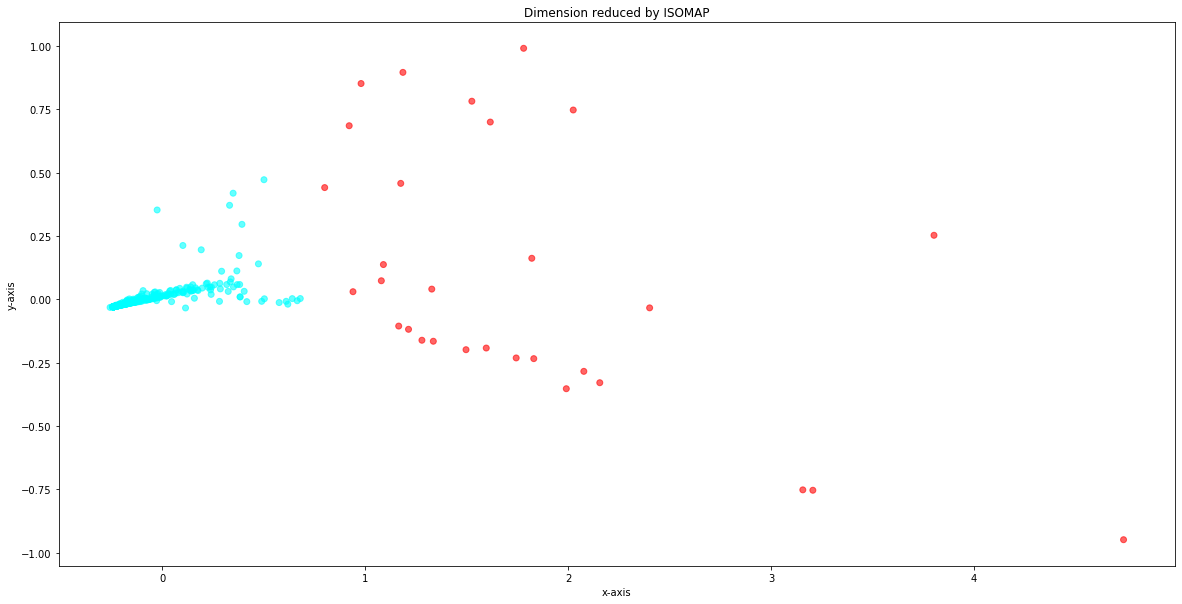

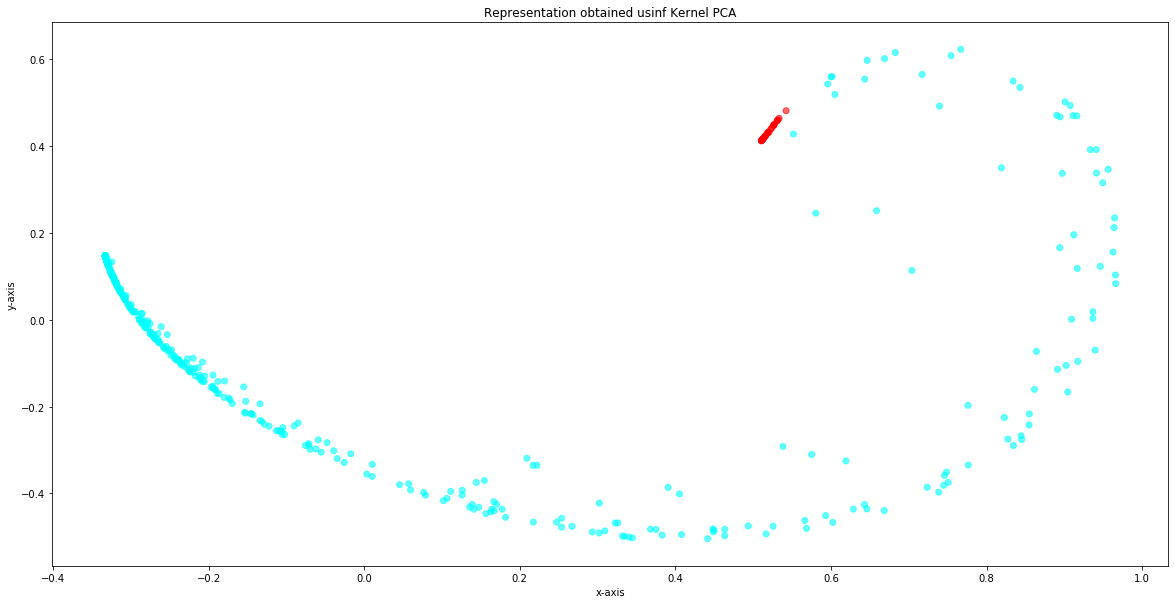

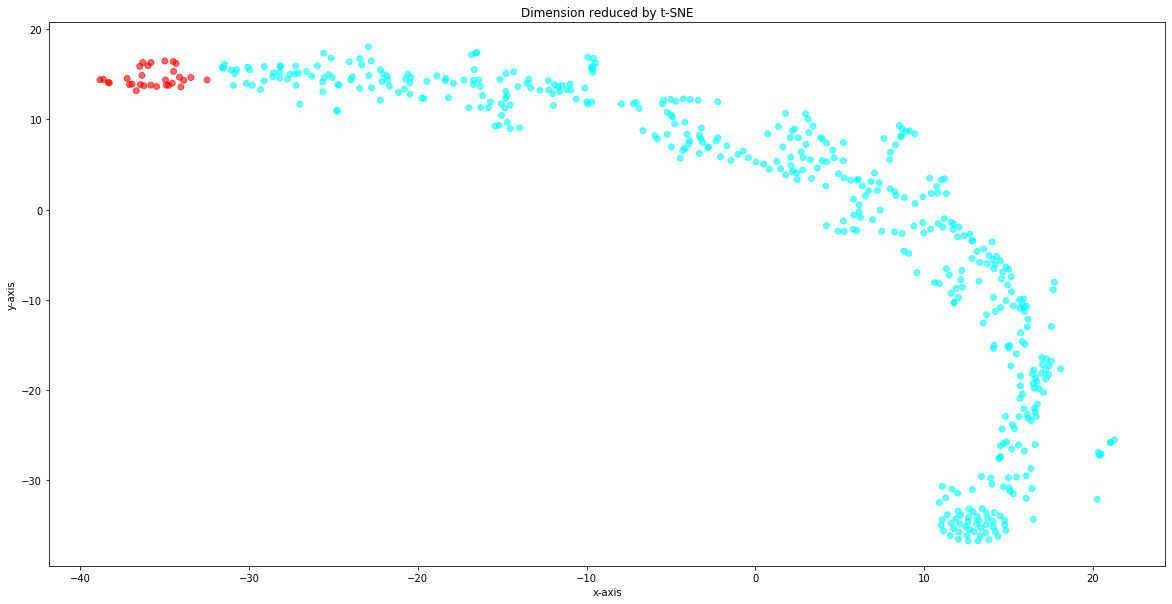

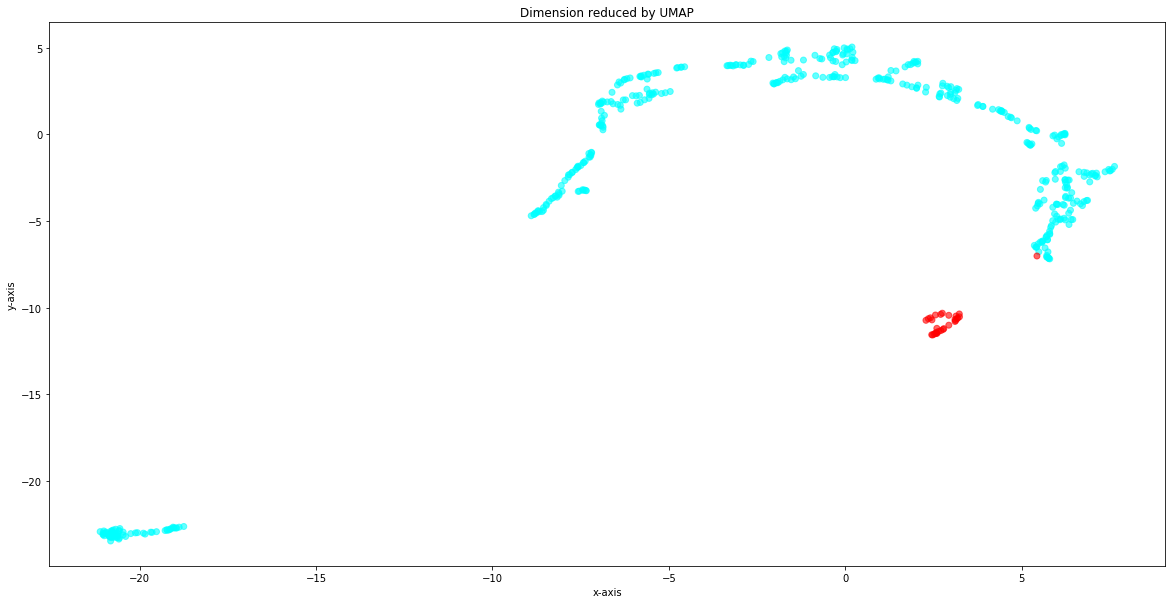

In [690]:
performAgglomerativeClustering(ncl=2, X=pivot.values, pivot=pivot)

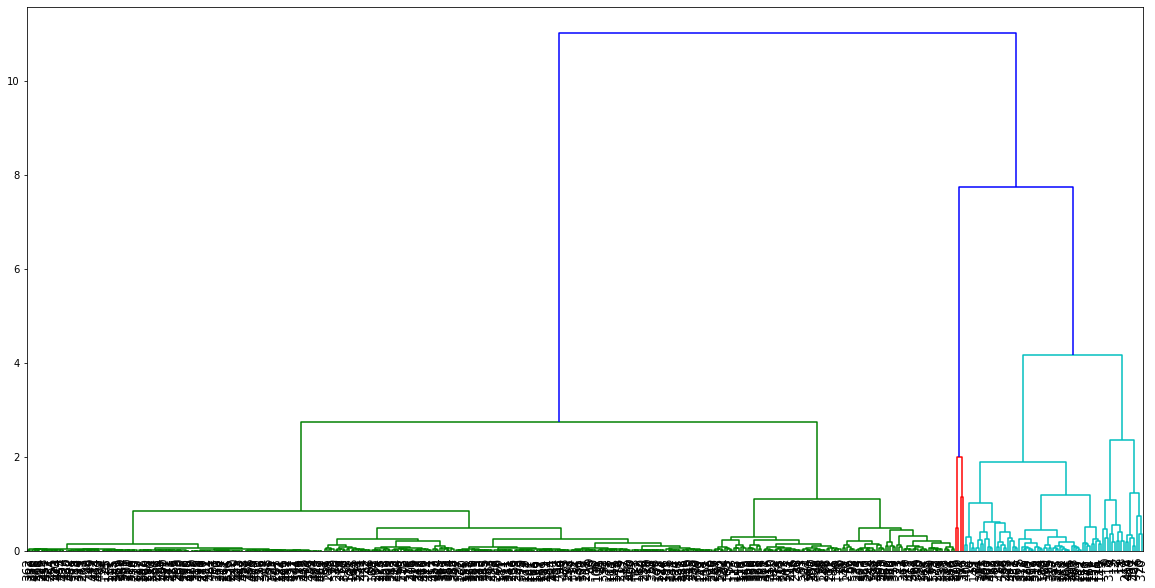

In [691]:
pivot = generate_quarter_pivot_matrix(2,aggTrain)
plot_scipy_edndogram(pivot = pivot.values)


silhouette sample on euclidean metric:  [ 0.41284093  0.55389176  0.38664537  0.43252258  0.49633422  0.13378455
 -0.05684191  0.36635456  0.44793928  0.89360342  0.49634305  0.3796764
  0.45110092  0.38062934  0.64137535  0.10482986  0.87748622  0.42346644
  0.89790998  0.51675487  0.33609905  0.5140171   0.48040174  0.60082869
  0.88472982  0.88871842  0.89186611  0.07048425  0.89545541 -0.11757451
  0.46424633  0.89625616  0.88893455  0.80005055  0.88618024  0.87933792
  0.84860181  0.89575983  0.82070668  0.89188232  0.89875401  0.88294823
  0.87323685  0.8515444   0.89692983  0.88932724  0.89189769  0.88337944
  0.82919523  0.89463457  0.66701488  0.8510373   0.88845594  0.87034485
  0.86970445  0.80142291  0.40002727  0.77010968  0.43762911  0.89672299
  0.89701559  0.85141194  0.87838654  0.89719325  0.51939351  0.82361371
  0.45163954  0.89669868  0.88134905  0.89670576  0.83980441  0.63151522
  0.65711315  0.77179829  0.31206373  0.89151819  0.88622026  0.84165507
  0.89222932

hour                          0            1            2            3   \
building_id cluster                                                       
7           0        1196.732802  1254.713780  1335.423780  1358.616418   
9           1         107.149370   109.468652   265.786343   273.207725   
13          0          85.812290    85.348454   102.047038   107.613281   
14          0         793.183648   765.816484   755.147978   742.160165   
15          0        1440.718308  1395.725033  1346.092802  1301.563110   
...                          ...          ...          ...          ...   
1408        1          30.468897    28.458759    26.938611    25.593320   
1409        1          45.314543    43.447284    42.004179    40.610401   
1410        1          34.546580    34.019235    32.305960    30.867745   
1411        1           5.184960     5.355231     3.880298     3.396490   
1412        1           1.912347     1.949976     1.951223     1.908676   

hour                          4            5            6            7   \
building_id cluster                                                       
7           0        1356.296846  1389.230670  2968.639890  3862.016154   
9           1         245.840577   225.894857   807.098912   852.556195   
13          0         280.165378   554.300613  2383.262044  2929.676923   
14          0         744.015538   728.708516  1913.846593  1833.599670   
15          0        1225.492000  1058.041912  2187.980253  2065.988462   
...                          ...          ...          ...          ...   
1408        1          24.457918    23.905078    25.131652    28.321814   
1409        1          40.041556    40.403087    41.155200    43.438703   
1410        1          29.959851    30.458302    31.639574    31.694902   
1411        1           2.990240     2.891534     3.403699     3.371755   
1412        1           1.865980     2.466831     2.571580     2.615553   

hour                          8            9   ...           14           15  \
building_id cluster                            ...                             
7           0        3941.333846  3919.997143  ...  4274.378352  4342.100440   
9           1         838.640752   904.043514  ...   949.500792   959.241540   
13          0        2504.326780  2721.872022  ...  2982.091692  2871.231670   
14          0        2721.872198  3278.956044  ...  3655.139011  3631.482747   
15          0        2101.704725  2254.775495  ...  2529.838473  2597.096242   
...                          ...          ...  ...          ...          ...   
1408        1          32.853478    39.267814  ...    60.764351    61.061426   
1409        1          47.594447    52.752564  ...    66.621797    67.143319   
1410        1          34.053558    37.304176  ...    43.722376    45.605073   
1411        1           4.732275     6.289584  ...    13.549097    13.122171   
1412        1           3.216341     3.764767  ...     5.062040     4.960737   

hour                          16           17           18           19  \
building_id cluster                                                       
7           0        4338.853516  4190.885275  4011.375495  3884.198901   
9           1         977.331799   956.922367   895.230500   835.393245   
13          0        2784.027626  2714.450110  2602.662659  2502.584330   
14          0        3442.231648  3310.034396  3221.438901  3017.186484   
15          0        2662.035604  2651.366813  2693.577121  2700.725495   
...                          ...          ...          ...          ...   
1408        1          60.324167    58.678691    56.624202    52.664800   
1409        1          65.493825    63.600657    61.919827    59.157043   
1410        1          45.265832    44.798451    43.174296    38.944090   
1411        1          14.654699    15.273842    13.238895    11.623269   
1412        1           4.801508     4.262332     4.167009     3.993476   

hour                          2

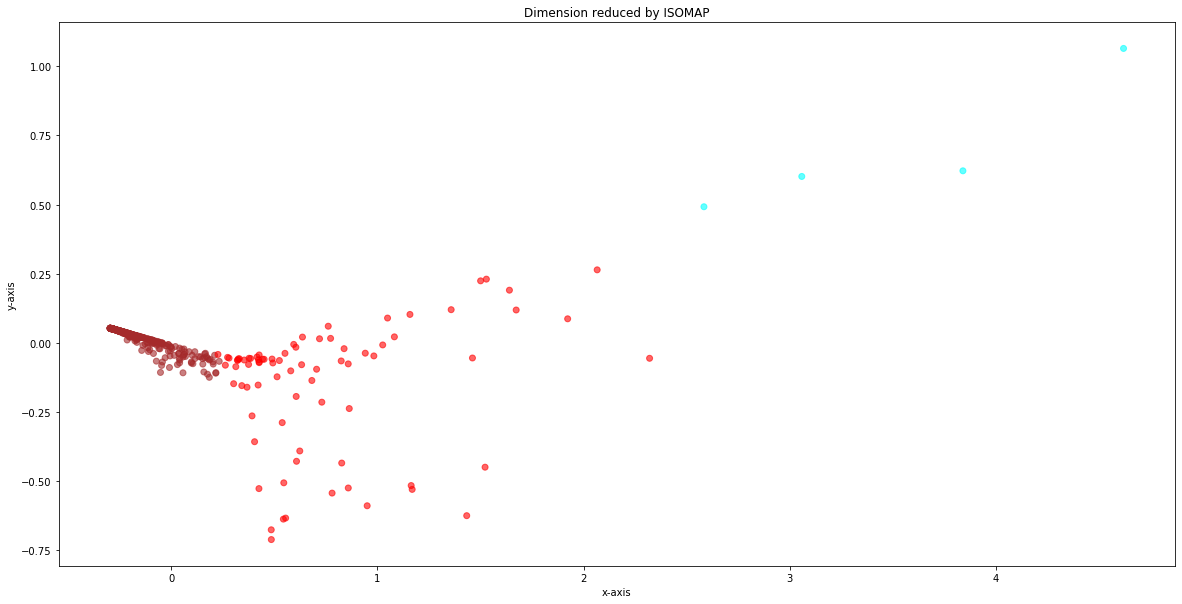

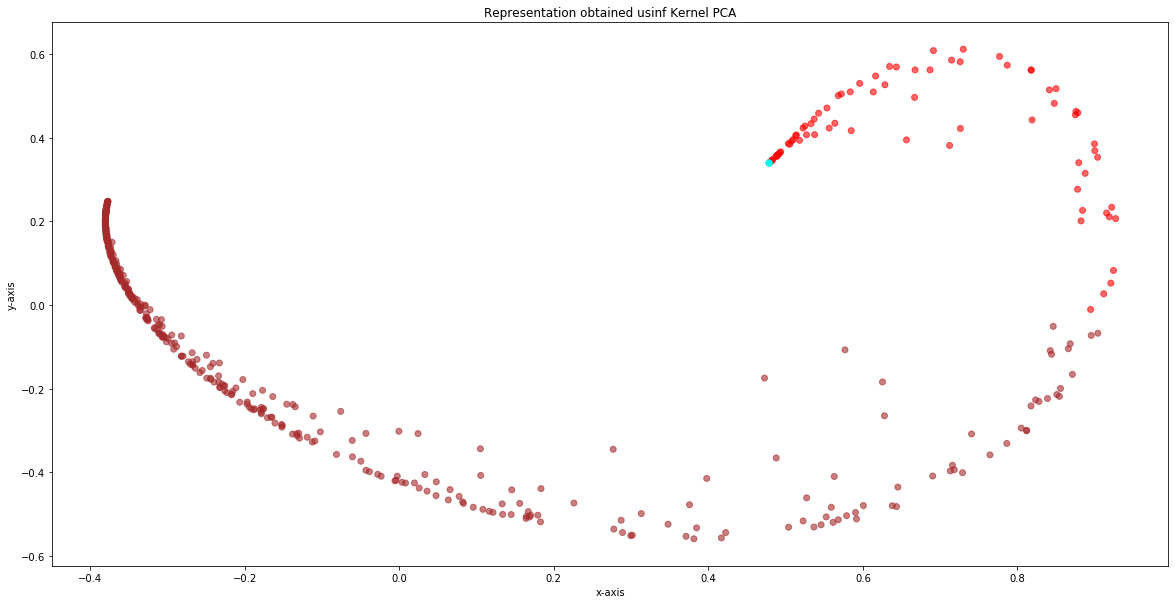

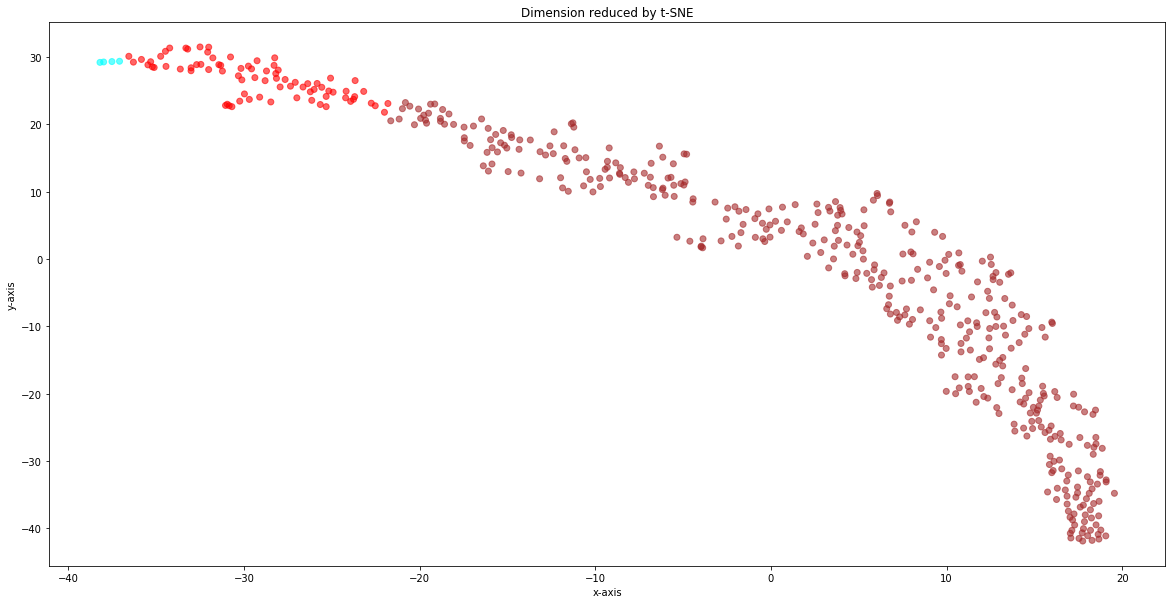

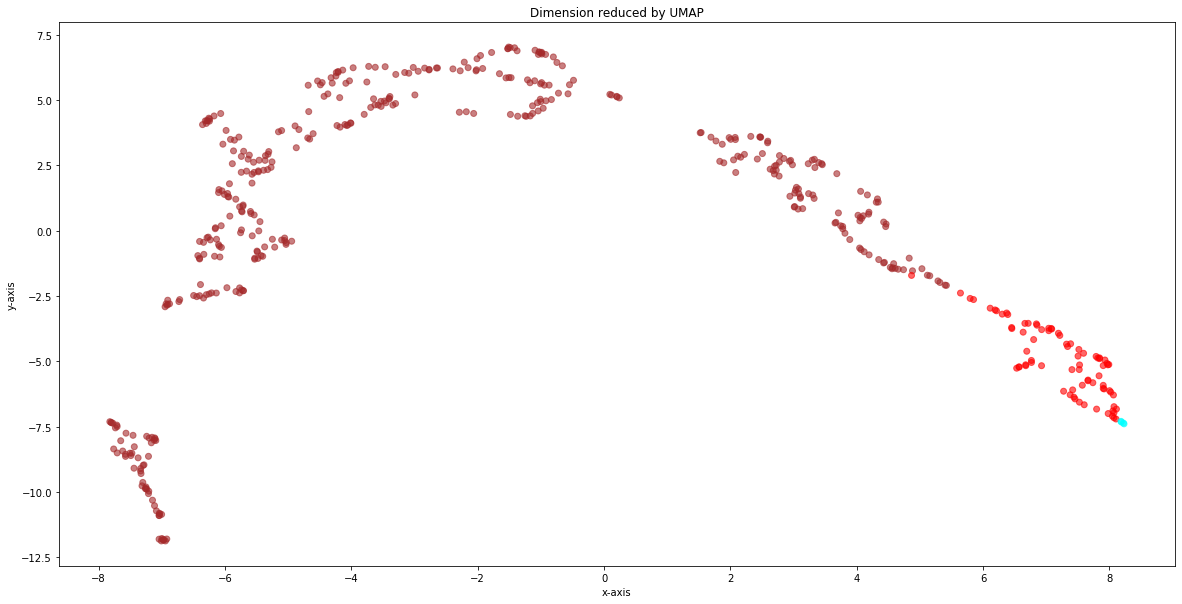

In [692]:
performAgglomerativeClustering(ncl=3, X=pivot.values, pivot=pivot)

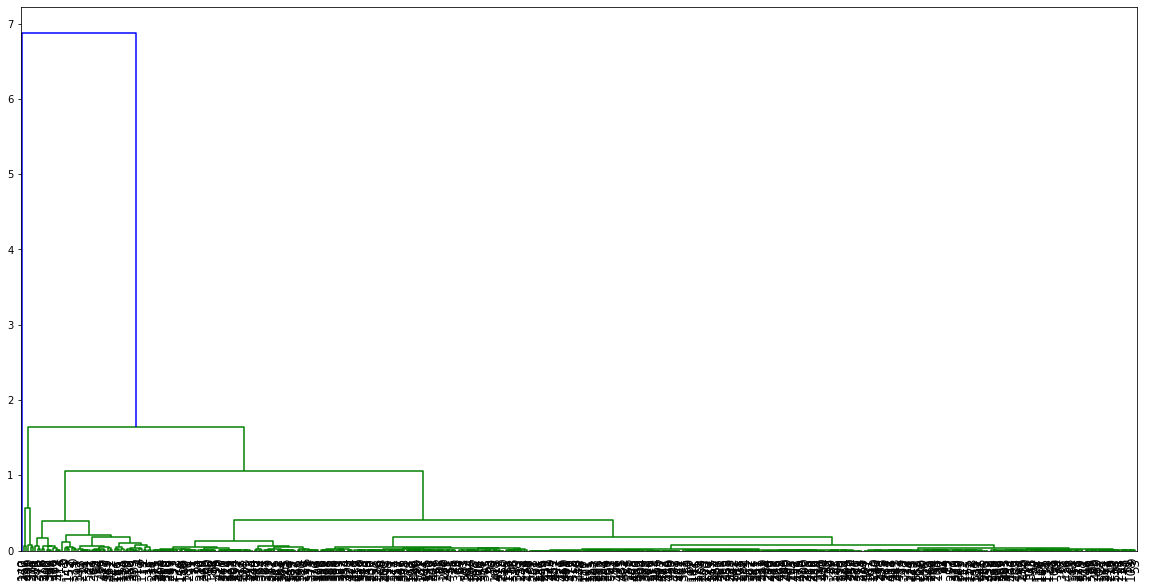

In [693]:
pivot = generate_quarter_pivot_matrix(3,aggTrain)
plot_scipy_edndogram(pivot = pivot.values)


silhouette sample on euclidean metric:  [0.970733   0.99210313 0.97989511 0.97639153 0.98197773 0.98756995
 0.95803247 0.97284361 0.96942266 0.99376267 0.98084303 0.9926002
 0.97473356 0.98538594 0.90712955 0.98507644 0.99402028 0.97859437
 0.99393325 0.97758984 0.96476171 0.97770197 0.9772132  0.99204793
 0.99336399 0.99373569 0.99392829 0.98891798 0.99402151 0.98949667
 0.98385864 0.9938569  0.99377823 0.99403828 0.99403516 0.99402132
 0.99393571 0.9937321  0.99344209 0.99356365 0.99399045 0.99333217
 0.99400087 0.99370835 0.99373853 0.99357774 0.99354104 0.99340251
 0.99401387 0.99397073 0.99344533 0.99359728 0.99332138 0.99384339
 0.99397633 0.99379514 0.99145547 0.99308969 0.99098637 0.99386127
 0.99397544 0.9938934  0.99376396 0.99378584 0.98182062 0.99347861
 0.98231676 0.99403104 0.99329561 0.99386609 0.99363635 0.99202931
 0.9927395  0.99267825 0.98708498 0.99353126 0.99391017 0.99387901
 0.99387409 0.99392671 0.99368387 0.99401146 0.99357876 0.99297049
 0.99358447 0.99389798 

hour                          0            1            2            3   \
building_id cluster                                                       
7           0        1536.547935  1757.694533  1924.241848  2082.530641   
9           0         611.591601   595.074523   700.600359   704.270901   
13          0         266.250058   257.050331   258.673749   284.649365   
14          0         861.641957   848.795348   847.418880   844.207250   
15          0        1786.140511  1790.270109  1770.999978  1743.012783   
...                          ...          ...          ...          ...   
1408        0          63.201323    59.494109    56.543729    54.042115   
1409        0          74.098961    71.396423    69.494017    67.937980   
1410        0          65.297902    64.646648    63.808716    63.623276   
1411        0          19.142513    17.672680    17.018652    16.156012   
1412        0           8.624596     7.745293     7.726155     7.666768   

hour                          4            5            6            7   \
building_id cluster                                                       
7           0        2126.116772  2116.940750  4431.628696  5215.732065   
9           0         690.506611   646.919771   937.803974  1060.764761   
13          0         751.668808   864.229795  3624.678885  3630.632564   
14          0         839.619152   827.690152  2244.949565  2350.475000   
15          0        1602.617065  1562.241489  3121.731522  2896.456196   
...                          ...          ...          ...          ...   
1408        0          51.777156    50.851122    53.564039    58.849918   
1409        0          66.409826    66.350585    68.702974    70.200871   
1410        0          63.099400    63.446909    63.507628    63.296473   
1411        0          16.083571    15.574168    15.363995    16.172227   
1412        0           7.211657    10.232178    10.759678    11.013588   

hour                          8            9   ...           14           15  \
building_id cluster                            ...                             
7           0        5123.052500  5438.712391  ...  5742.443696  5613.977609   
9           0        1137.843880  1236.028565  ...  1283.285163  1307.143054   
13          0        3320.007051  3789.191795  ...  4111.503190  4062.346975   
14          0        3777.827283  4803.262935  ...  5396.960870  5258.400543   
15          0        2952.431304  3110.719783  ...  3469.966196  3429.132174   
...                          ...          ...  ...          ...          ...   
1408        0          66.984940    80.224536  ...   116.024970   116.681515   
1409        0          75.784924    82.715306  ...   102.186855   101.280218   
1410        0          64.300034    67.122174  ...    73.236440    73.412923   
1411        0          17.935454    20.644994  ...    33.119206    34.215482   
1412        0           9.863043    10.983644  ...    13.434594    13.821855   

hour                          16           17           18           19  \
building_id cluster                                                       
7           0        5597.001522  5417.607500  5224.449565  4941.364891   
9           0        1307.143076  1251.627652  1161.701809  1052.047207   
13          0        3861.446076  3627.384744  3589.504359  3421.745256   
14          0        4959.716522  4690.396087  4262.328152  4058.158696   
15          0        3441.519891  3423.627174  3291.948804  3353.429022   
...                          ...          ...          ...          ...   
1408        0         117.141990   115.324104   109.223824   100.819918   
1409        0          99.403315    96.577637    93.583618    90.051832   
1410        0          73.225088    73.270931    70.971845    68.906307   
1411        0          35.172508    33.391837    30.860460    28.794162   
1412        0          13.269117    13.582463    12.796189    12.094679   

hour                          2

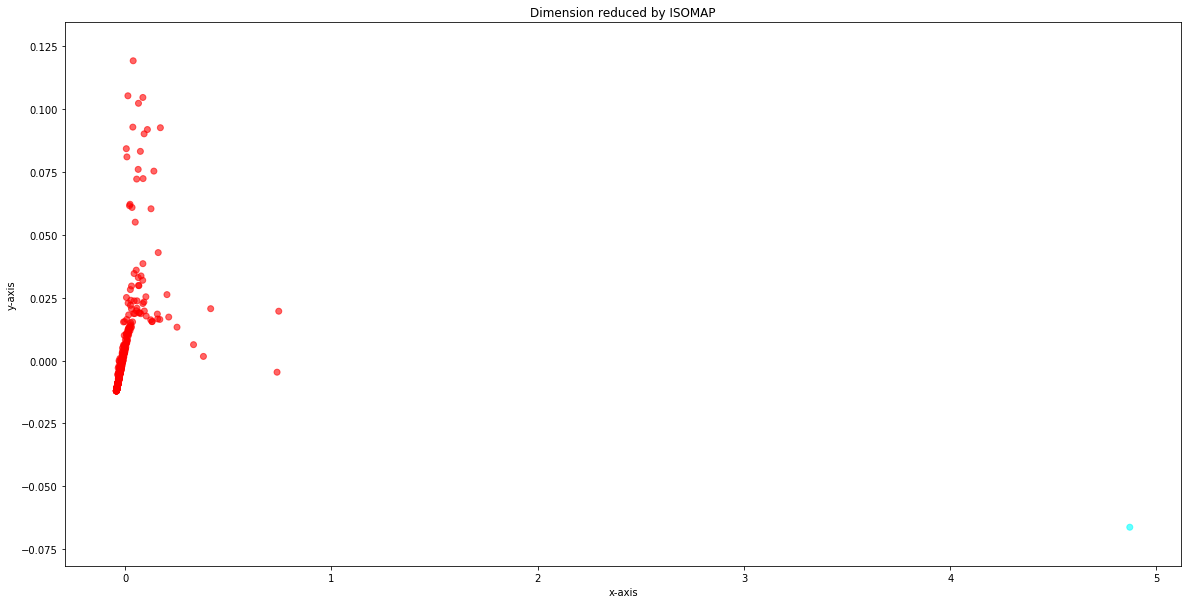

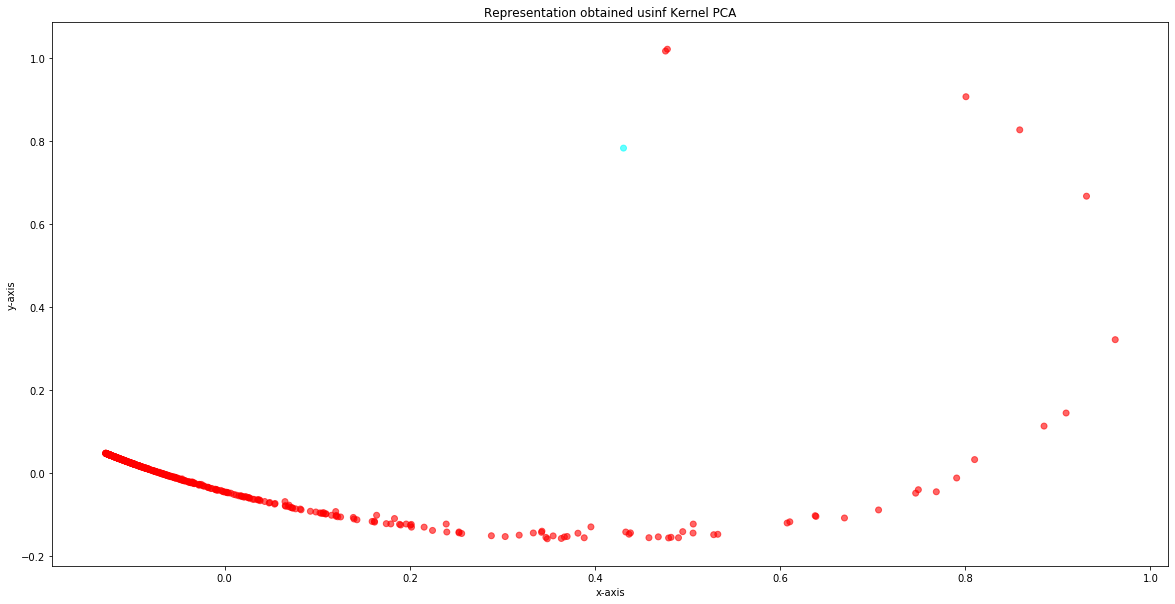

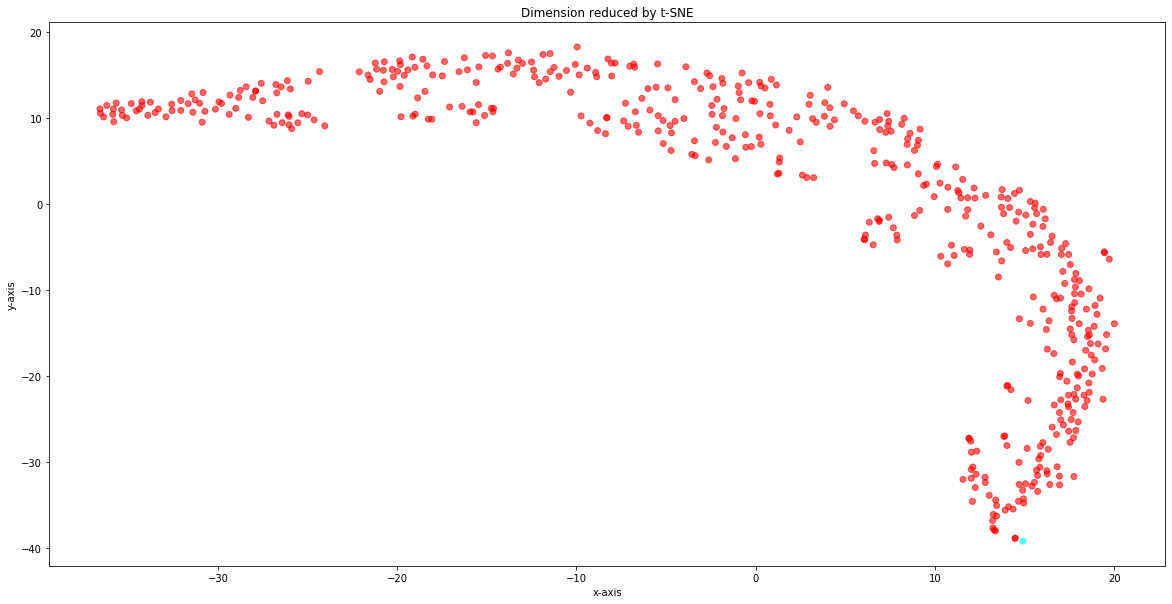

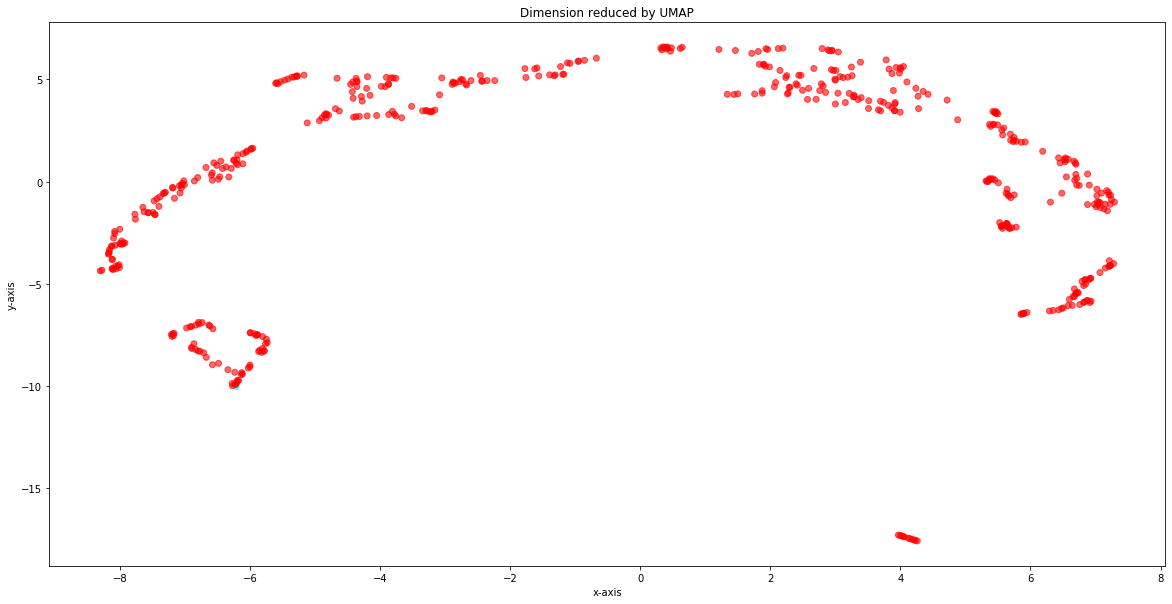

In [694]:
performAgglomerativeClustering(ncl=2, X=pivot.values, pivot=pivot)

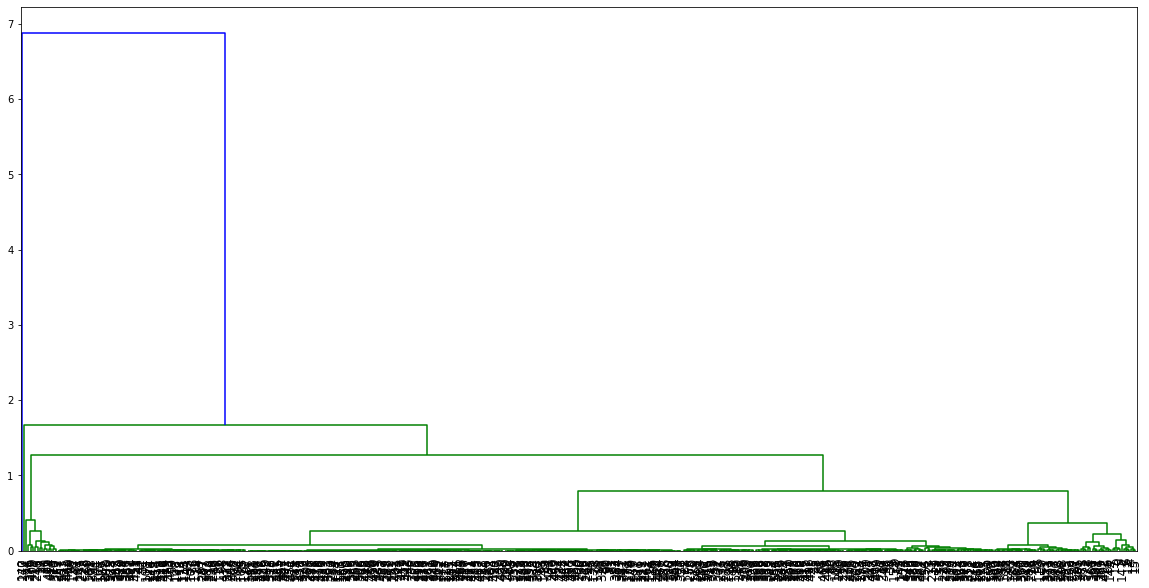

In [695]:
pivot = generate_quarter_pivot_matrix(4,aggTrain)
plot_scipy_edndogram(pivot = pivot.values)


silhouette sample on euclidean metric:  [0.84425415 0.9666045  0.88223788 0.84729952 0.90959862 0.93862758
 0.88250177 0.83065539 0.87680938 0.97622304 0.80264865 0.96415882
 0.88621861 0.90358497 0.24581197 0.90803594 0.97747636 0.84046805
 0.97888279 0.76984308 0.83041218 0.80870459 0.73598394 0.96264236
 0.97738703 0.97770731 0.97883991 0.95124378 0.9789325  0.96479454
 0.93698509 0.97851767 0.97826032 0.97859629 0.97876487 0.97810437
 0.97744295 0.97836365 0.97279409 0.97811089 0.97884371 0.97873569
 0.97801321 0.97770352 0.97809829 0.97780569 0.97742346 0.97775988
 0.97790736 0.97867887 0.95934036 0.97811028 0.97763982 0.97760191
 0.97709392 0.97496475 0.96748366 0.97243513 0.96000041 0.97869915
 0.97890223 0.97766215 0.97853734 0.97818259 0.90105922 0.9777239
 0.92532385 0.97882789 0.9772032  0.97850184 0.97514633 0.97076824
 0.97310095 0.96099591 0.95724067 0.97797911 0.97883598 0.97714688
 0.97864552 0.9787455  0.97525622 0.97519731 0.97797872 0.96183519
 0.9783094  0.97830511 

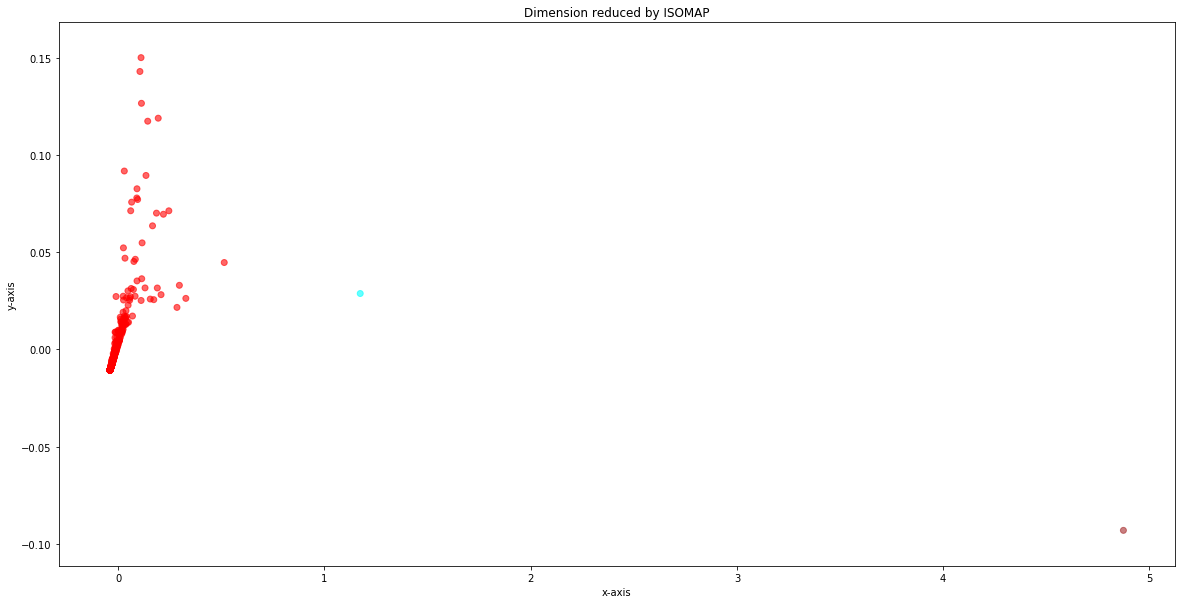

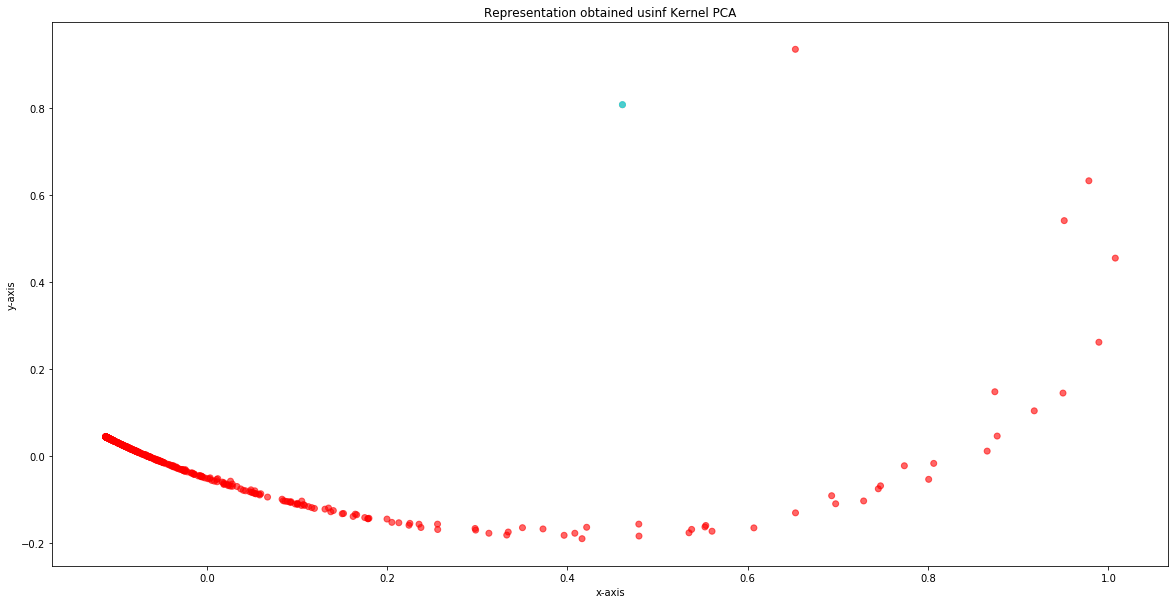

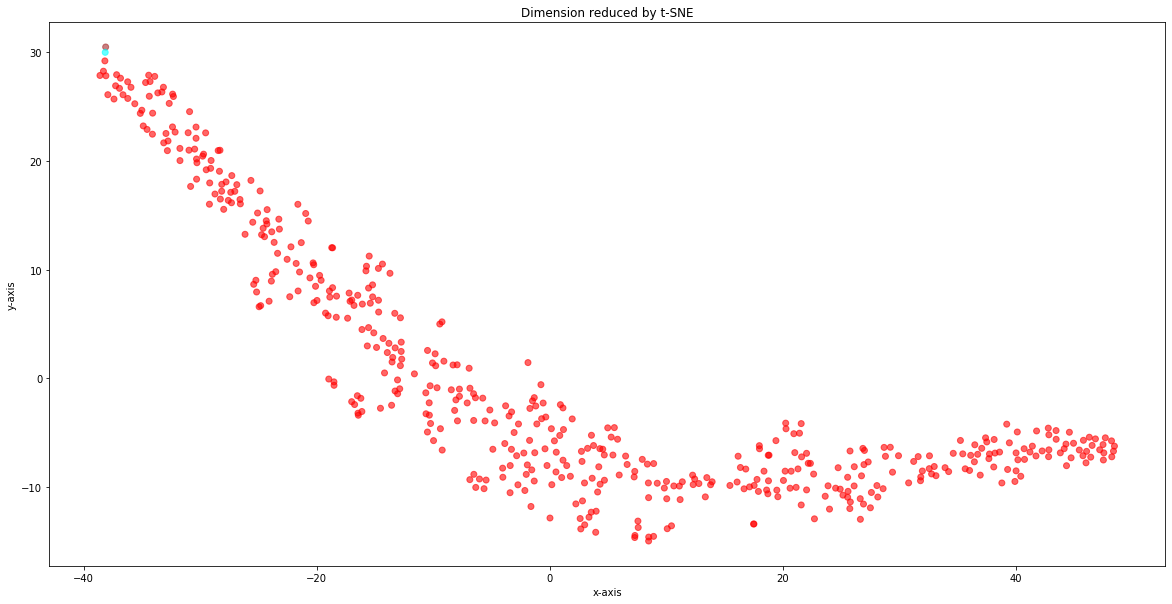

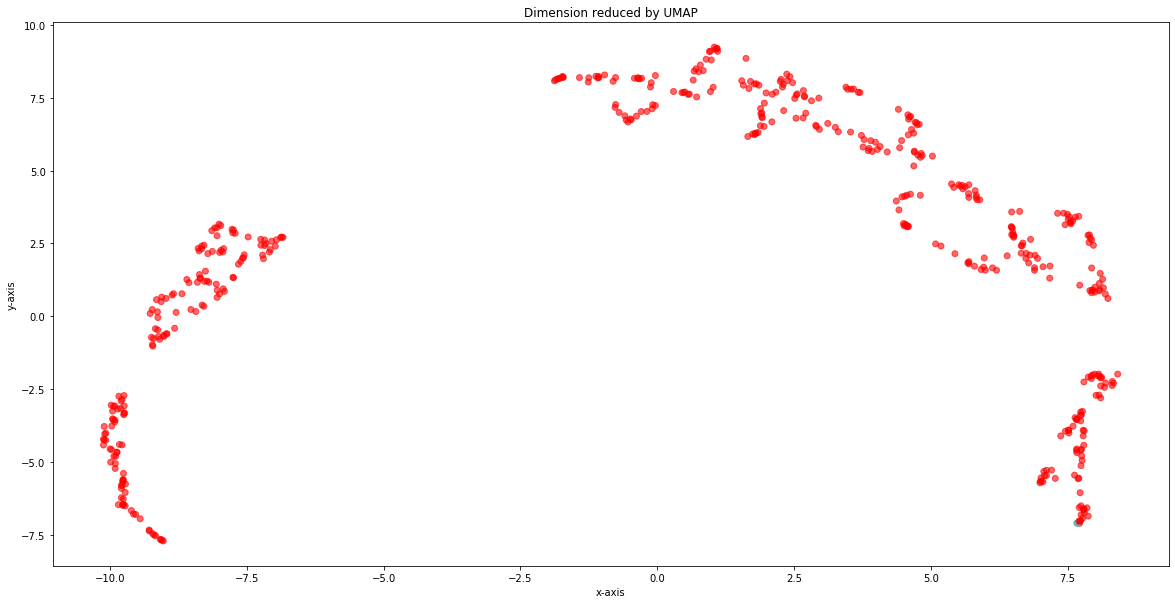

In [696]:
p = performAgglomerativeClustering(ncl=3, X=pivot.values, pivot=pivot)

In [697]:
p[p.index.get_level_values("cluster") ==1 ]

hour                           0             1        2             3   \
building_id cluster                                                      
778         1        69381.311111  66095.288889  66688.6  65619.222222   

hour                           4             5             6             7   \
building_id cluster                                                           
778         1        63949.835165  63698.659341  61679.197802  63096.516484   

hour                           8             9   ...            14  \
building_id cluster                              ...                 
778         1        57155.164835  53306.678022  ...  59739.120879   

hour                           15            16            17            18  \
building_id cluster                                                           
778         1        62393.666667  68239.466667  70165.422222  67785.611111   

hour                           19       20            21            22  \
building_id cluster                                                      
778         1        61494.088889  59207.7  59736.877778  64059.611111   

hour                           23  
building_id cluster                
778         1        61477.177778  

[1 rows x 24 columns]

### Test with DTW distance

pivot generated
dis-similarity matrix generated.


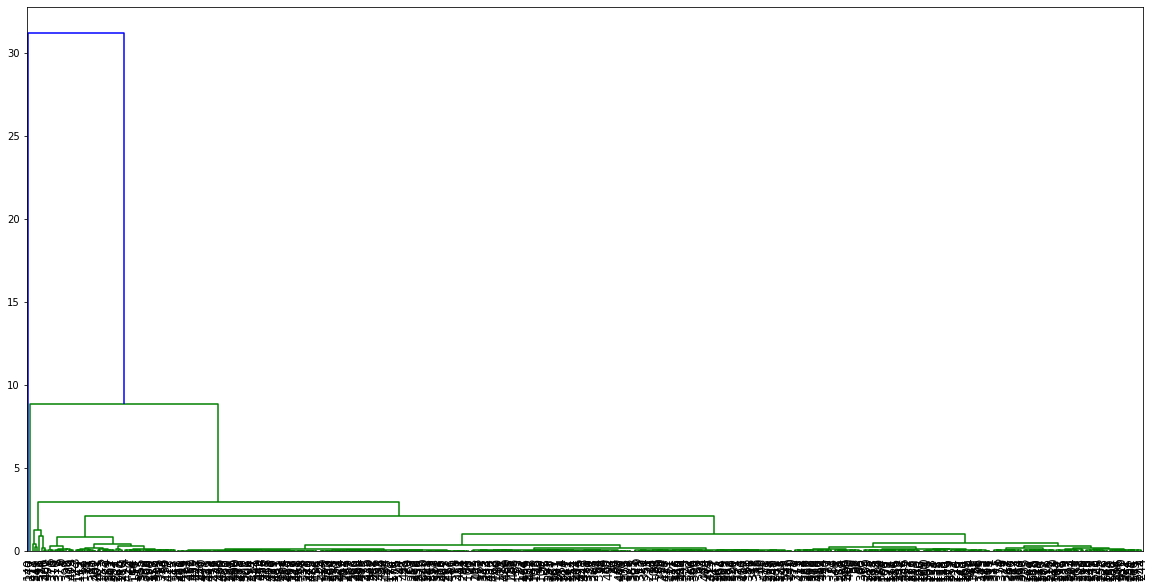

In [698]:
dtwMatrix = generate_quarter_pivot_matrix(0, aggTrain)
#print(dtwMatrix)
print("pivot generated")
dtwMatrix = generate_dtw_matrix(dtwMatrix.values)
print("dis-similarity matrix generated.")
plot_scipy_edndogram(pivot = dtwMatrix)

silhouette sample on euclidean metric:  [0.98621924 0.99543283 0.99063541 0.98864584 0.99166792 0.99422585
 0.98025318 0.98723565 0.98701196 0.99620353 0.99160114 0.99571612
 0.97783674 0.99202851 0.95854299 0.99316752 0.99615747 0.98952246
 0.99606759 0.98805327 0.98454233 0.98867056 0.98785877 0.99427941
 0.99586554 0.99617198 0.99619299 0.99472764 0.99613297 0.99480464
 0.99302875 0.99605192 0.99617821 0.99614364 0.99614218 0.99616918
 0.99619775 0.99610547 0.99615297 0.995905   0.99609673 0.99581117
 0.9961898  0.99620955 0.99601882 0.99608632 0.99582257 0.99602745
 0.99619051 0.99615249 0.99602982 0.99620028 0.99572349 0.99618261
 0.99617787 0.9960865  0.99561618 0.99609556 0.99553295 0.99596632
 0.99611285 0.99617116 0.99616945 0.99599299 0.99169113 0.99614605
 0.99259907 0.99614742 0.99570159 0.99605146 0.996195   0.99577752
 0.9959733  0.9958164  0.99419626 0.99605677 0.99619951 0.99618273
 0.99607868 0.99604695 0.99617469 0.99616244 0.99520977 0.99590163
 0.99590877 0.99617551

C:\Users\ashuk\.conda\envs\udacityDL\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


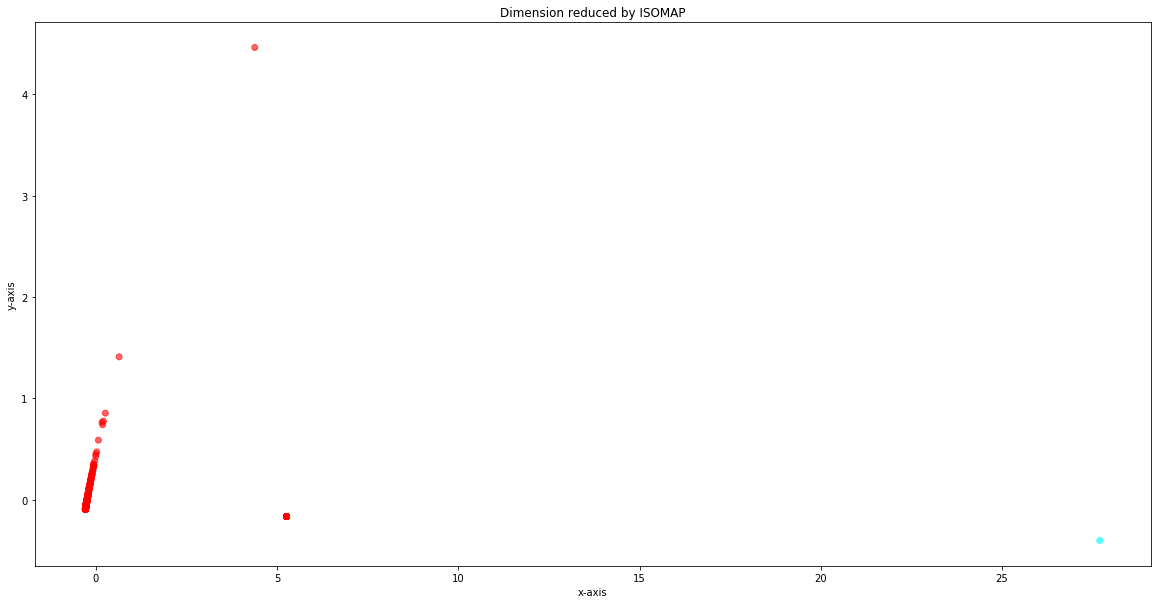

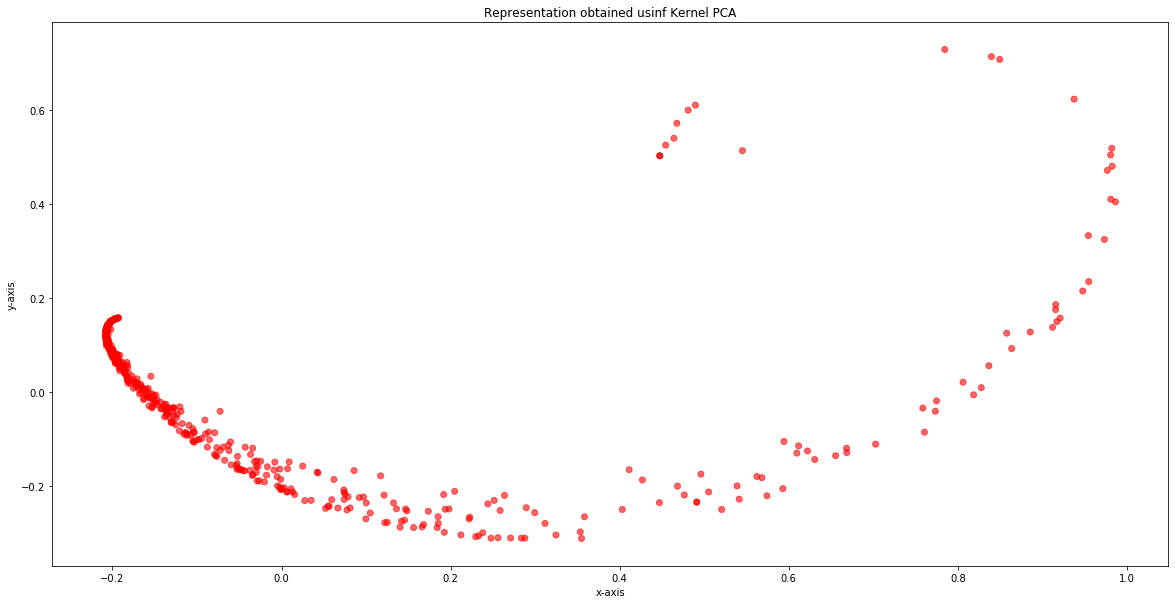

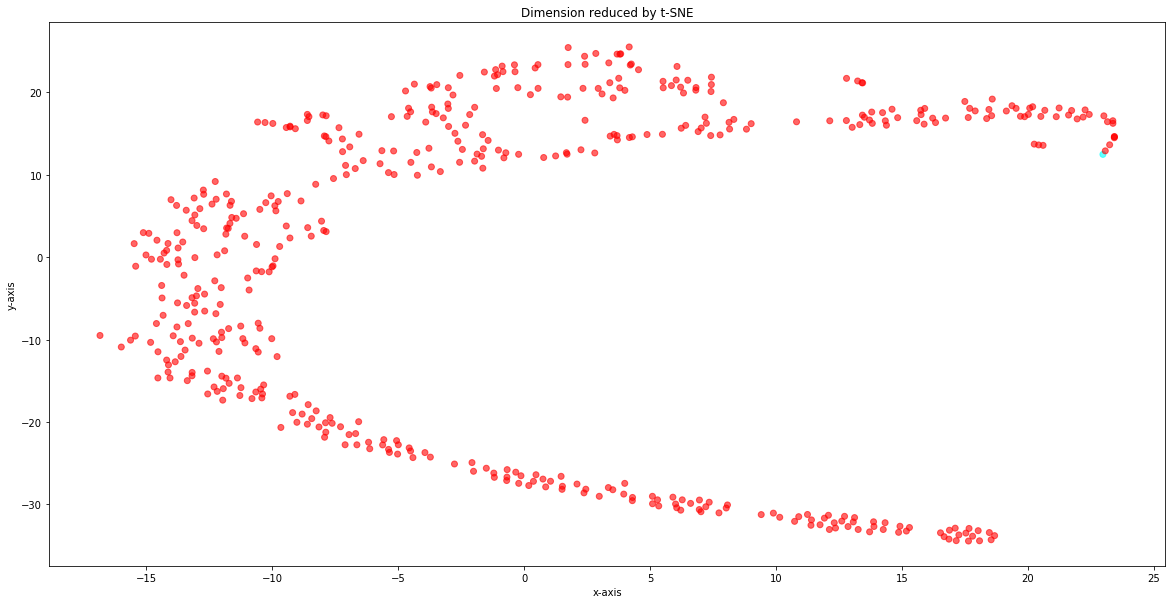

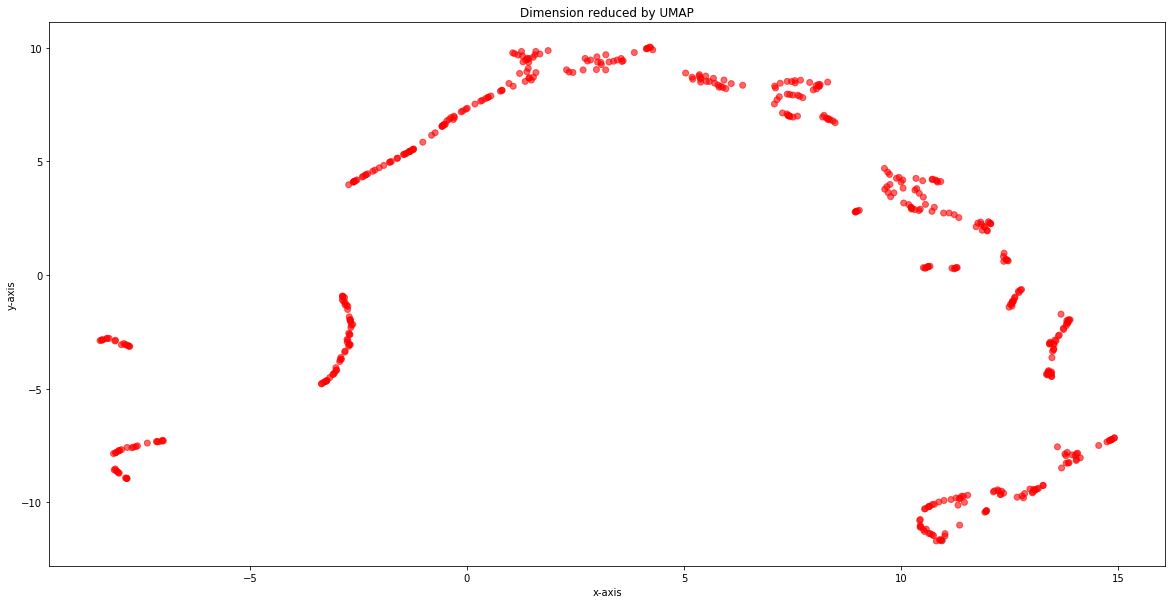

In [699]:
p = performAgglomerativeClustering(ncl=2, X=dtwMatrix, pivot=generate_quarter_pivot_matrix(0, aggTrain))

In [700]:
p[p.index.get_level_values("cluster") ==1 ]

timestamp            2016-01-01 00:00:00  2016-01-01 01:00:00  \
building_id cluster                                             
778         1                        0.0                  0.0   

timestamp            2016-01-01 02:00:00  2016-01-01 03:00:00  \
building_id cluster                                             
778         1                        0.0                  0.0   

timestamp            2016-01-01 04:00:00  2016-01-01 05:00:00  \
building_id cluster                                             
778         1                        0.0                  0.0   

timestamp            2016-01-01 06:00:00  2016-01-01 07:00:00  \
building_id cluster                                             
778         1                        0.0                  0.0   

timestamp            2016-01-01 08:00:00  2016-01-01 09:00:00  ...  \
building_id cluster                                            ...   
778         1                        0.0                  0.0  ...   

timestamp            2016-12-31 14:00:00  2016-12-31 15:00:00  \
building_id cluster                                             
778         1                        0.0                  0.0   

timestamp            2016-12-31 16:00:00  2016-12-31 17:00:00  \
building_id cluster                                             
778         1                        0.0                  0.0   

timestamp            2016-12-31 18:00:00  2016-12-31 19:00:00  \
building_id cluster                                             
778         1                        0.0                  0.0   

timestamp            2016-12-31 20:00:00  2016-12-31 21:00:00  \
building_id cluster                                             
778         1                        0.0                  0.0   

timestamp            2016-12-31 22:00:00  2016-12-31 23:00:00  
building_id cluster                                            
778         1                        0.0                  0.0  

[1 rows x 8784 columns]

pivot generated
dis-similarity matrix generated.


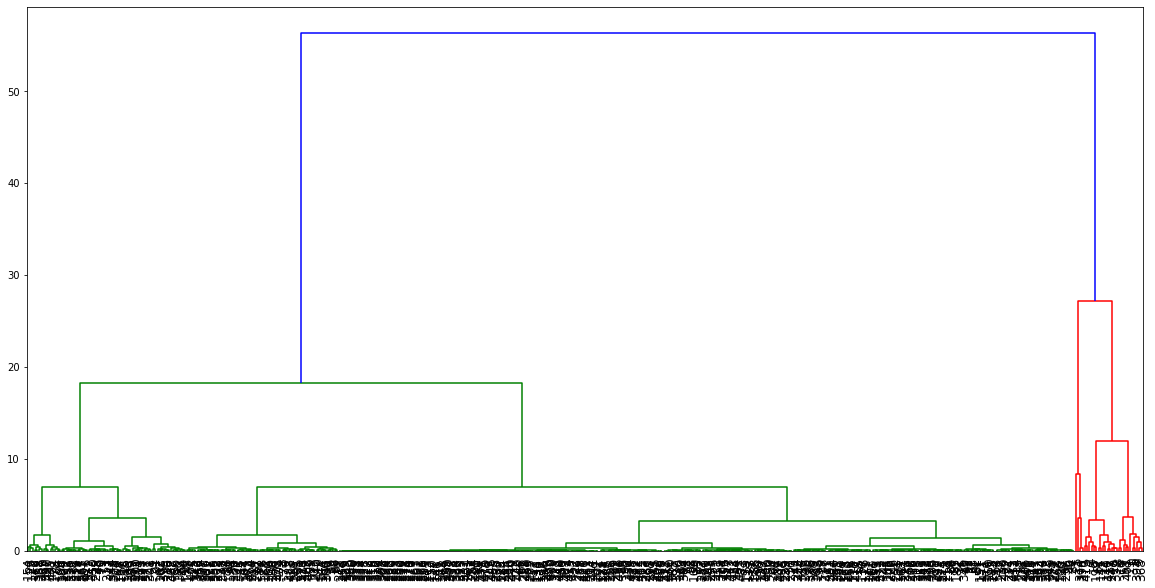

In [701]:
dtwMatrix1 = generate_quarter_pivot_matrix(1, aggTrain)
#print(dtwMatrix)
print("pivot generated")
dtwMatrix1 = generate_dtw_matrix(dtwMatrix1.values)
print("dis-similarity matrix generated.")
plot_scipy_edndogram(pivot = dtwMatrix1)

silhouette sample on euclidean metric:  [ 0.5888152   0.75856874  0.46381331  0.58990255  0.38644679  0.39487025
  0.58442668  0.59642146  0.90566825  0.58773064  0.74365482  0.93769068
  0.31448754  0.30877853  0.2031599   0.92308008  0.57749808  0.93536907
  0.45604618  0.56110934  0.26088641  0.77674713  0.93823968  0.94038529
  0.93917251  0.74403018  0.94032778  0.82950151  0.56318877  0.94021948
  0.9404767   0.93831924  0.93564585  0.93351097  0.9222633   0.94055035
  0.88297243  0.93989578  0.94022547  0.93883113  0.93705723  0.92970521
  0.94015422  0.93976838  0.9399191   0.93864335  0.93938969  0.93613156
  0.84345455  0.9338384   0.94026878  0.92927686  0.92817009  0.88772374
  0.79410963  0.89684955  0.79263557  0.93993461  0.93642869  0.90553148
  0.93920382  0.93991988 -0.0288529   0.92711122  0.47525762  0.94018627
  0.93787372  0.93993181  0.89367588  0.88754729  0.84714249  0.84578246
  0.6530204   0.93968663  0.90305511  0.91278818  0.93836818  0.94041314
  0.9048199

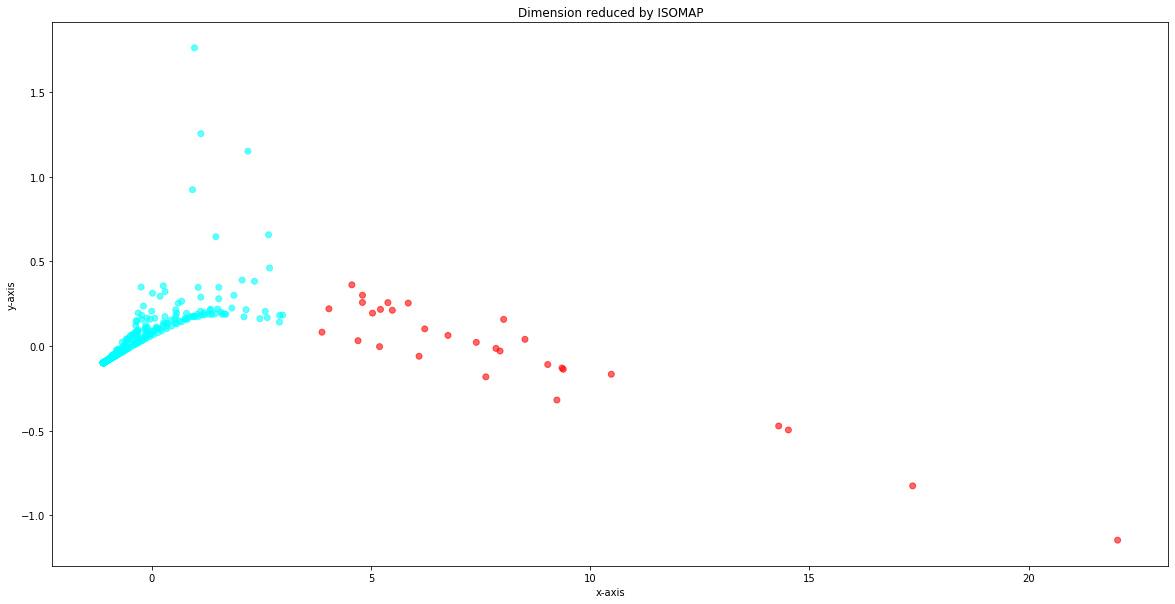

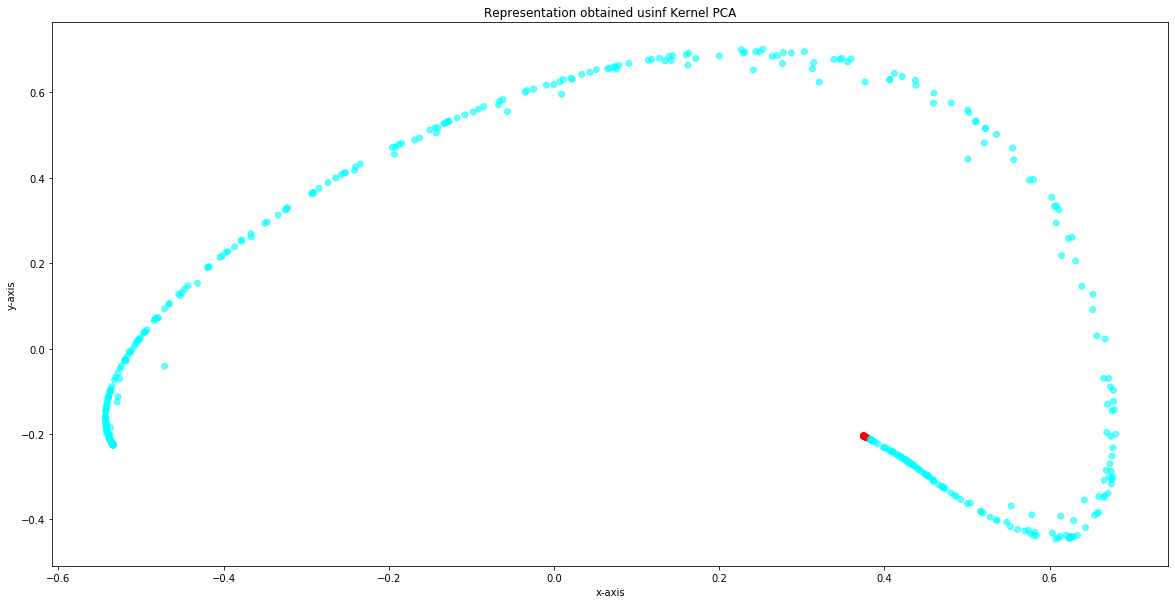

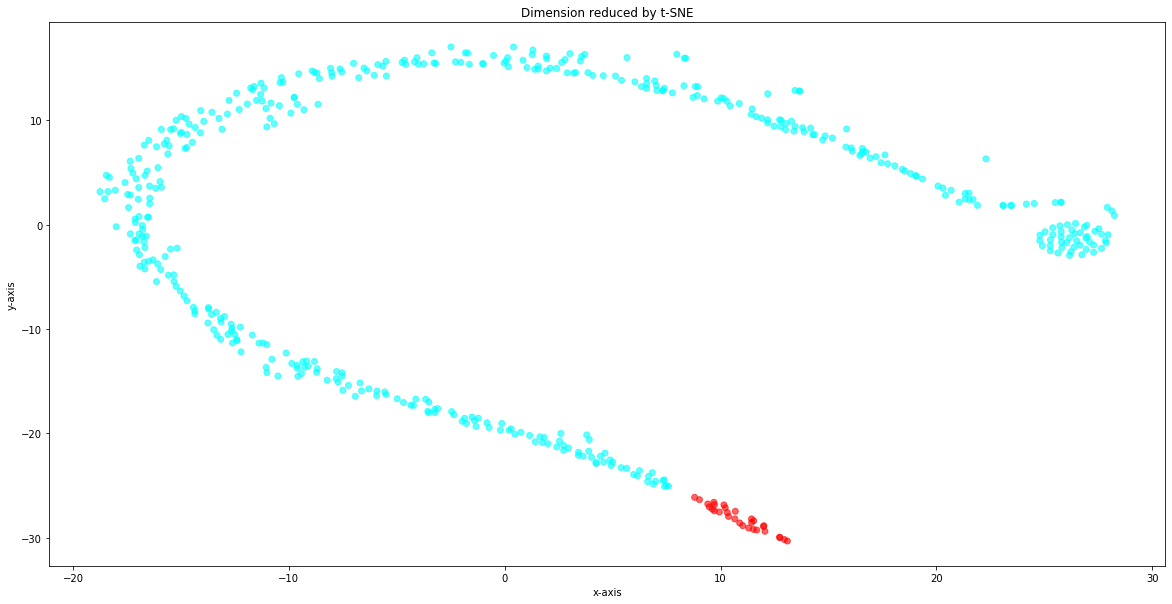

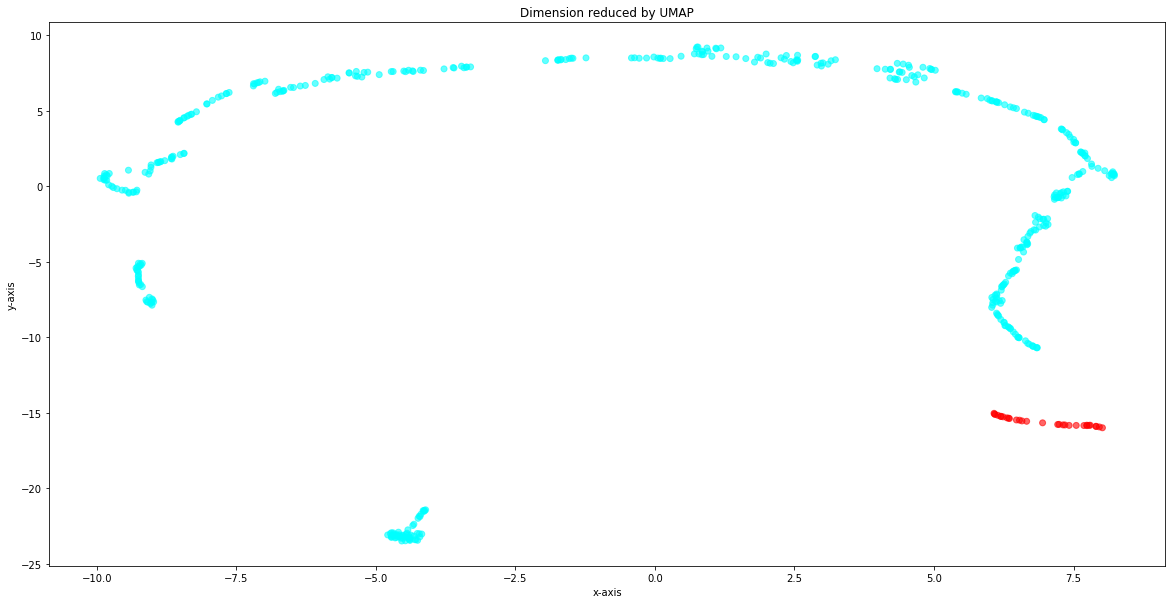

In [702]:
p = performAgglomerativeClustering(ncl=2, X=dtwMatrix1, pivot=generate_quarter_pivot_matrix(1, aggTrain))

pivot generated
dis-similarity matrix generated.


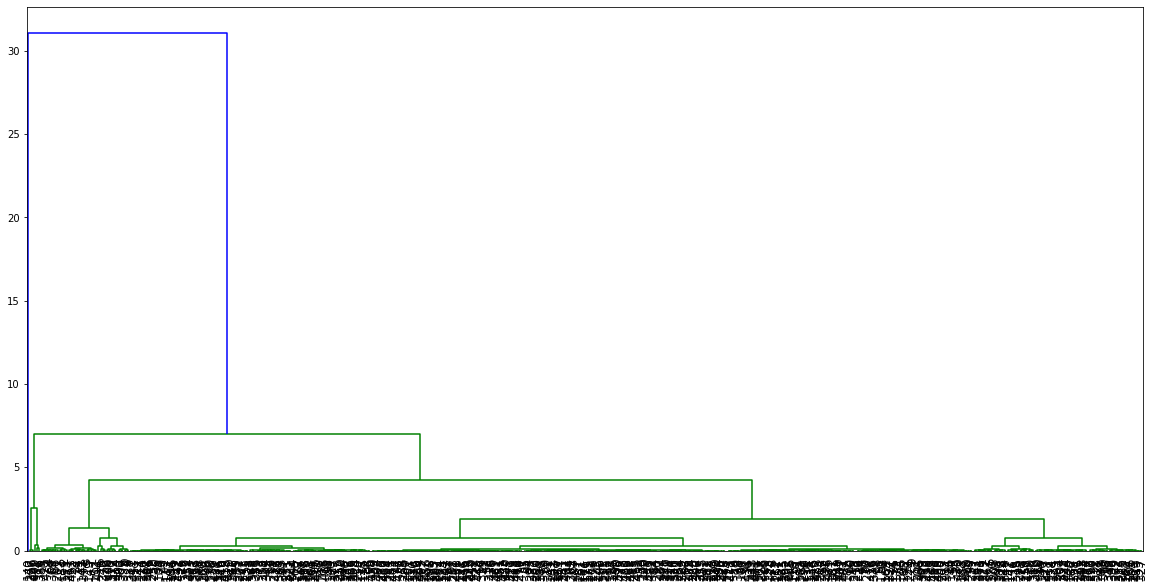

In [703]:
dtwMatrix2 = generate_quarter_pivot_matrix(3, aggTrain)
#print(dtwMatrix)
print("pivot generated")
dtwMatrix2 = generate_dtw_matrix(dtwMatrix2.values)
print("dis-similarity matrix generated.")
plot_scipy_edndogram(pivot = dtwMatrix2)

silhouette sample on euclidean metric:  [0.97458913 0.99328466 0.98346393 0.97973429 0.98457204 0.98958384
 0.9624312  0.97731526 0.97307778 0.99477378 0.98378657 0.99380102
 0.97848201 0.98825363 0.91465371 0.98796763 0.99475361 0.98226853
 0.99473856 0.98072362 0.96891256 0.98076738 0.98025233 0.99410494
 0.99452581 0.99472717 0.99464124 0.99047404 0.99475973 0.99096351
 0.98620427 0.99472281 0.99479458 0.99474253 0.99473613 0.99471225
 0.99461309 0.99470614 0.99440747 0.99461145 0.99475169 0.99451843
 0.99470192 0.99469703 0.99468663 0.99462248 0.99459802 0.9945426
 0.99468724 0.99474986 0.99431903 0.99479996 0.99451379 0.99478059
 0.99469164 0.99458075 0.99257012 0.99396633 0.99220747 0.99472836
 0.99476058 0.99457687 0.99468225 0.99468175 0.98447933 0.9942395
 0.98507951 0.99474027 0.99450172 0.99472905 0.99474729 0.9934643
 0.99365778 0.99366744 0.98901108 0.99458849 0.99464181 0.99461491
 0.99475015 0.99475    0.99445181 0.99476462 0.99463942 0.99386538
 0.99461169 0.99477479 0.

C:\Users\ashuk\.conda\envs\udacityDL\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


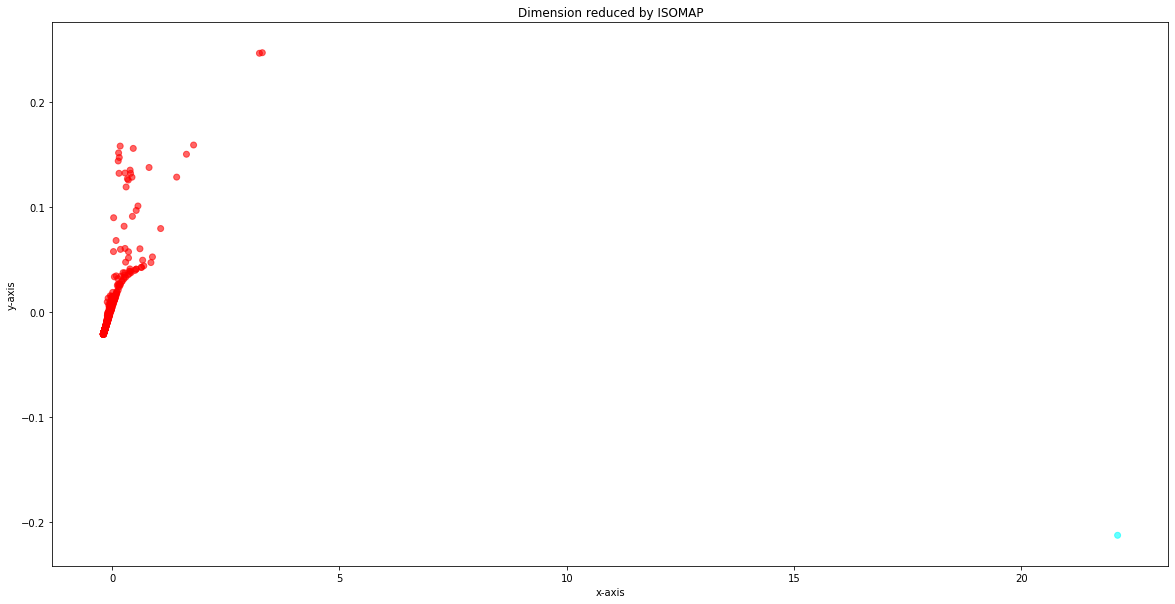

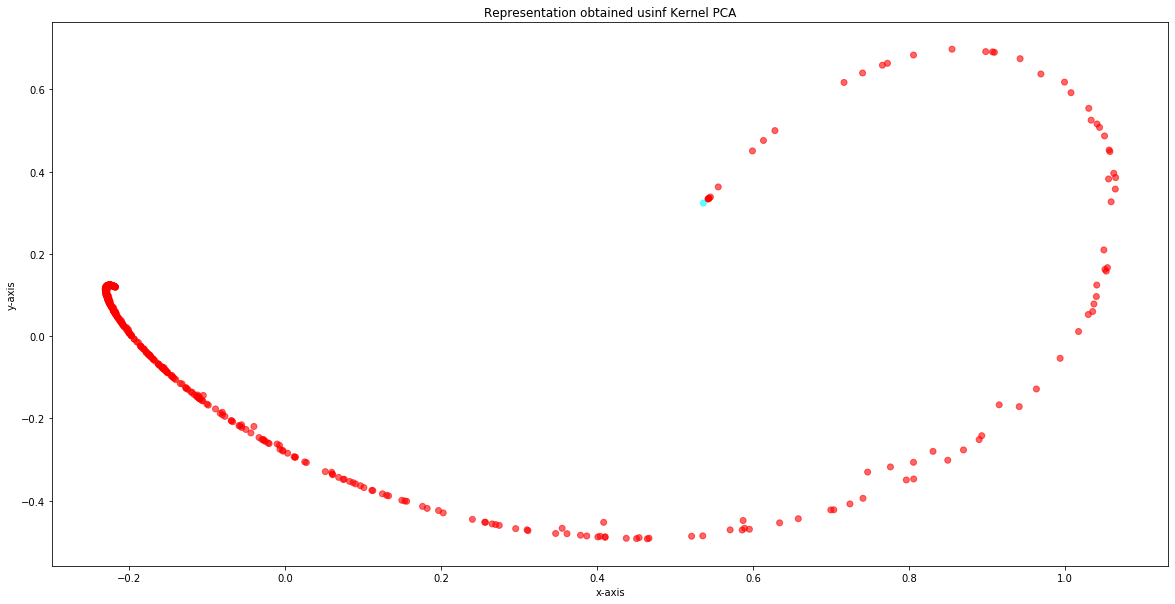

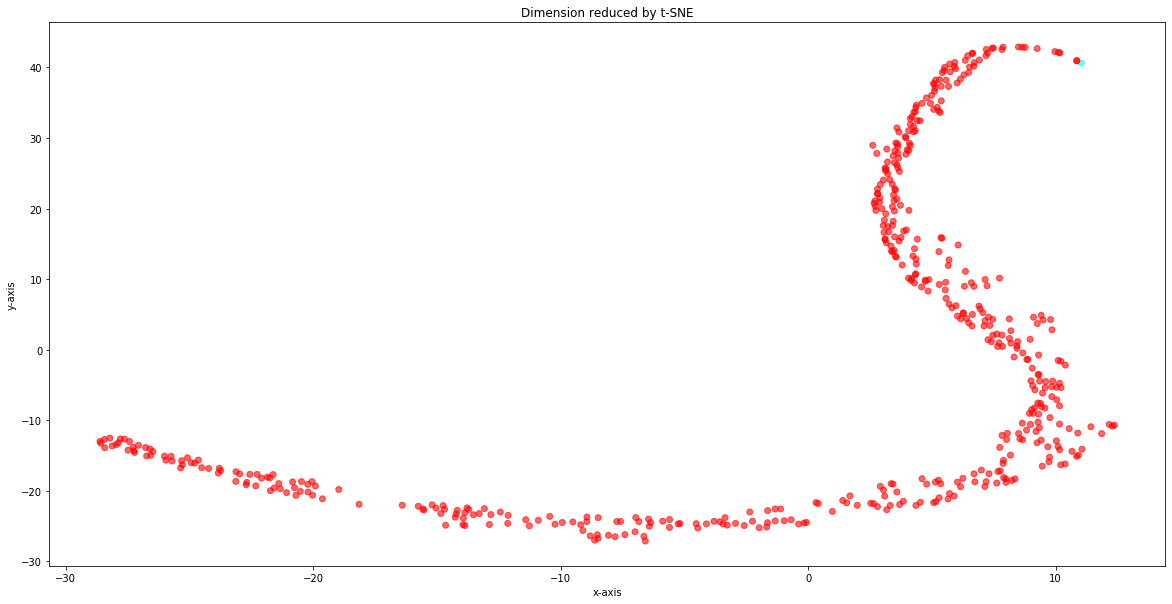

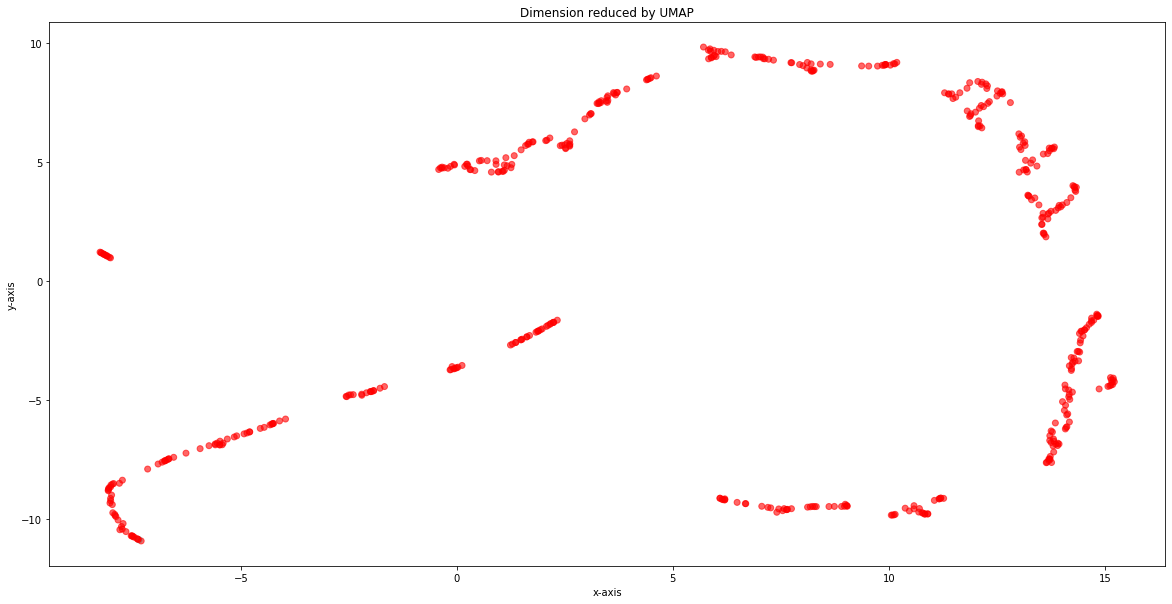

In [704]:
p = performAgglomerativeClustering(ncl=2, X=dtwMatrix2, pivot=generate_quarter_pivot_matrix(2, aggTrain))

pivot generated
dis-similarity matrix generated.


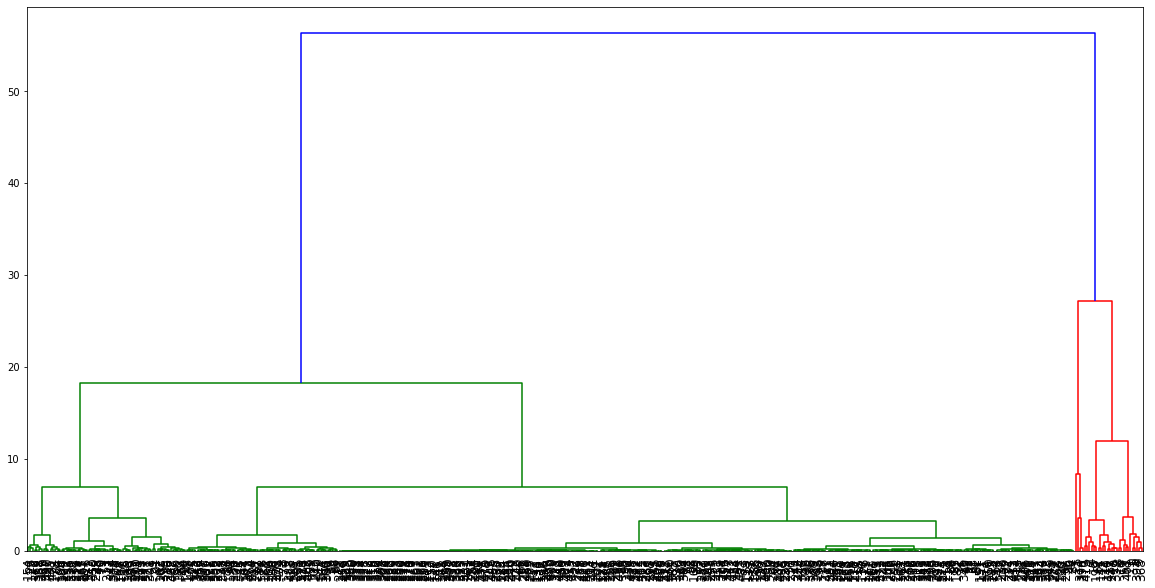

In [705]:
dtwMatrix3 = generate_quarter_pivot_matrix(1, aggTrain)
#print(dtwMatrix)
print("pivot generated")
dtwMatrix3 = generate_dtw_matrix(dtwMatrix3.values)
print("dis-similarity matrix generated.")
plot_scipy_edndogram(pivot = dtwMatrix3)

silhouette sample on euclidean metric:  [0.98621924 0.99543283 0.99063541 0.98864584 0.99166792 0.99422585
 0.98025318 0.98723565 0.98701196 0.99620353 0.99160114 0.99571612
 0.97783674 0.99202851 0.95854299 0.99316752 0.99615747 0.98952246
 0.99606759 0.98805327 0.98454233 0.98867056 0.98785877 0.99427941
 0.99586554 0.99617198 0.99619299 0.99472764 0.99613297 0.99480464
 0.99302875 0.99605192 0.99617821 0.99614364 0.99614218 0.99616918
 0.99619775 0.99610547 0.99615297 0.995905   0.99609673 0.99581117
 0.9961898  0.99620955 0.99601882 0.99608632 0.99582257 0.99602745
 0.99619051 0.99615249 0.99602982 0.99620028 0.99572349 0.99618261
 0.99617787 0.9960865  0.99561618 0.99609556 0.99553295 0.99596632
 0.99611285 0.99617116 0.99616945 0.99599299 0.99169113 0.99614605
 0.99259907 0.99614742 0.99570159 0.99605146 0.996195   0.99577752
 0.9959733  0.9958164  0.99419626 0.99605677 0.99619951 0.99618273
 0.99607868 0.99604695 0.99617469 0.99616244 0.99520977 0.99590163
 0.99590877 0.99617551

C:\Users\ashuk\.conda\envs\udacityDL\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


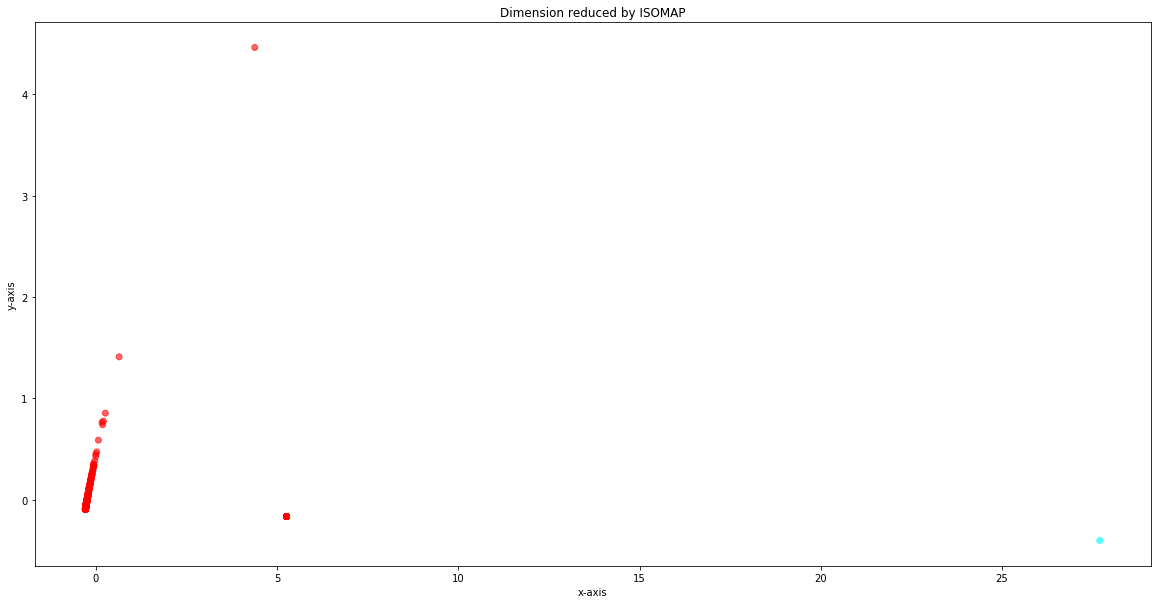

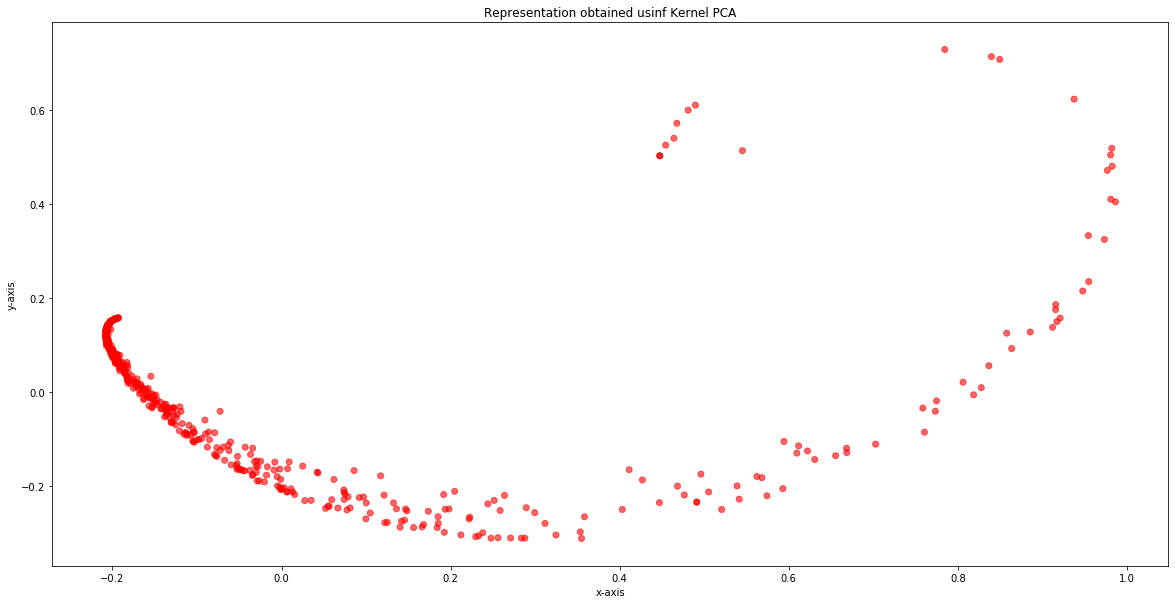

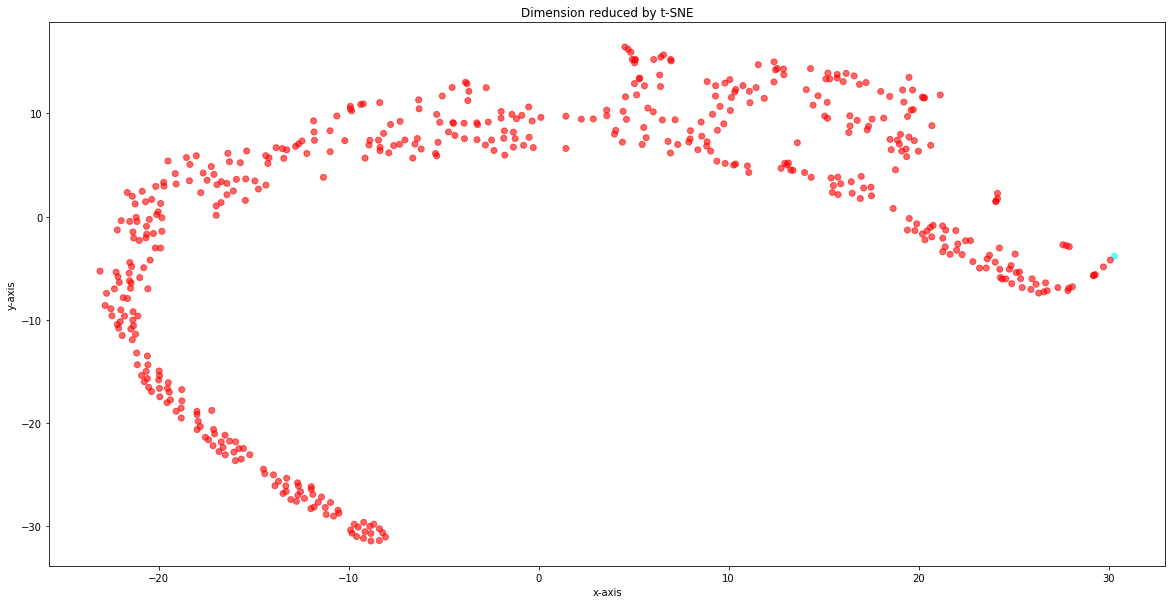

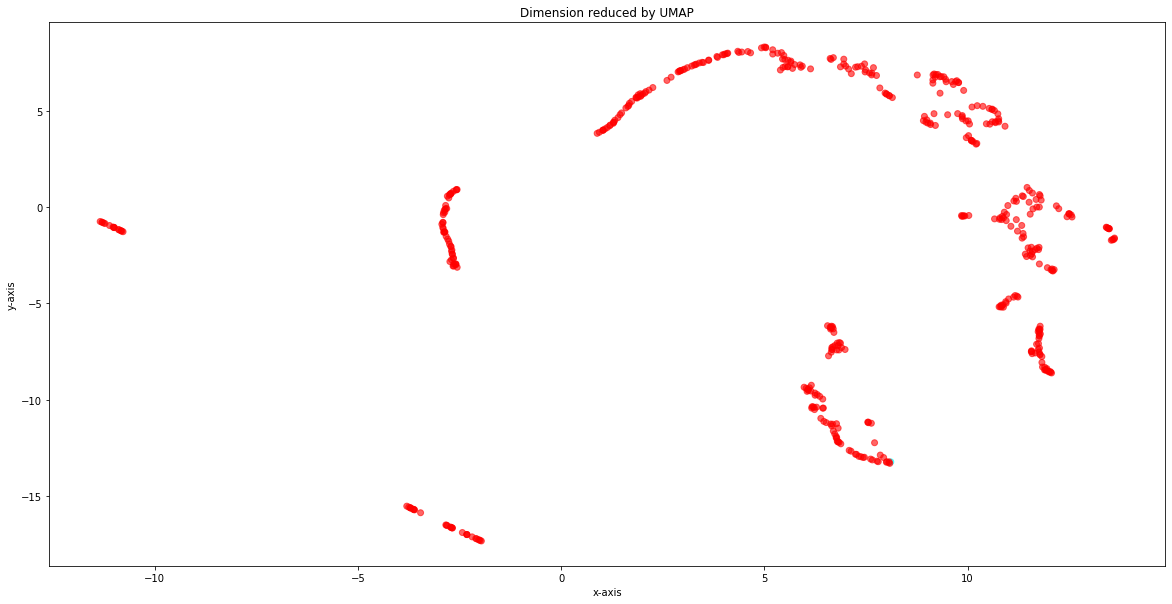

In [706]:
p = performAgglomerativeClustering(ncl=2, X=dtwMatrix, pivot=generate_quarter_pivot_matrix(0, aggTrain))